# Making the 95th efficiency plots 

In [1]:
#Import stuff
import uproot4
import numpy as np
import awkward as ak
from scipy.stats import norm
from scipy.optimize import curve_fit
import os
import copy

import tensorflow.keras as keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential, load_model

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split

import optparse
import importlib
import pathlib
from keras import optimizers


import hist
from hist import Hist

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.ROOT)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 5

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=500)])
    except RuntimeError as e:
        print(e)

model_name = '../models/merged_11_gamma33.h5'

2023-07-20 16:10:52.287630: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-20 16:10:52.478459: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-20 16:10:52.478488: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-07-20 16:11:02.406701: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

# First we need to reproduce the efficiency plots but with corrected pT

In [2]:
def plot_pt_eff_puppi(ModelName,
                      Model_Regress,
                      DataPath,
                      TreeName='ntuplePupSingle',
                      test_indx=400000,
                      corrected_pt_cut=1.,
                      cut_point = 0.28):
    '''
    cut_point = 0.28. We accept anything larger than this. 
    The corresponding corrected pT cut is 30 GeV.

    dir_path: directory path where the data is saved,
    '''

    sig = uproot4.open(DataPath)
    truth_tau_pt = sig[TreeName]['tree']['genpt1'].array()[test_indx:]
    reco_tau_pt = sig[TreeName]['tree']['pt'].array()[test_indx:]

    #Load model and select out the tau
    model_id = load_model(ModelName)
    model_pt_regress = load_model(Model_Regress)

    #Get all the inputs
    sig_input = sig[TreeName]['tree']['m_inputs'].array()[test_indx:]

    reco_pt_sig = sig[TreeName]['tree']['pt'].array()[test_indx:]
    deltaR_sig = sig[TreeName]['tree']['gendr1'].array()[test_indx:]
    eta_sig = sig[TreeName]['tree']['geneta1'].array()[test_indx:]

    ratio_predict = model_pt_regress.predict(np.asarray(sig_input))[1].flatten()
    corrected_pt_sig = np.multiply(reco_pt_sig, ratio_predict)

    selection_deno = (truth_tau_pt > 1.) & (abs(eta_sig) < 2.1) #"genpt1 > 1. && abs(geneta1) < 2.1 "
    selection_num = selection_deno & (abs(deltaR_sig) < 0.4) & (corrected_pt_sig>corrected_pt_cut) # " abs(gendr1) < 0.4 && pt > 1."
    #Originally (reco_pt_sig>1.) 

    #Selected out the tau pt with the basic cuts first
    truth_tau_pt_select = truth_tau_pt[selection_num]

    X_sig = np.asarray(sig_input[selection_num])
    y_sig = model_id.predict(np.nan_to_num(X_sig))[0]

    nn_cut = y_sig.flatten() > cut_point
    tau_pt_nn = np.asarray(truth_tau_pt_select)[nn_cut]

    #Fill two plots and divide the two.
    pT_egdes = np.linspace(0, 150, 100) #200?
    pT_egdes = list(pT_egdes)
    pT_axis = hist.axis.Variable(pT_egdes, name = r"$ \tau_h$ $p_T^{gen}$")

    hist_all_tau = Hist(pT_axis)
    hist_selected_puppi = Hist(pT_axis)
    hist_selected_tau = Hist(pT_axis)

    hist_all_tau.fill(truth_tau_pt[selection_deno])
    hist_selected_puppi.fill(truth_tau_pt_select)
    hist_selected_tau.fill(tau_pt_nn)

    %matplotlib inline
    fig = plt.figure(figsize=(10, 12))
    _, eff_new_nn_artists = hist_selected_tau.plot_ratio(
        hist_all_tau,
        rp_num_label=r"Selected Taus (New NN Score > {})".format(cut_point),
        rp_denom_label=r"All Taus",
        rp_uncert_draw_type="bar",
        rp_uncertainty_type="efficiency",
    )


    fig = plt.figure(figsize=(10, 12))
    _, eff_puppi_artists = hist_selected_puppi.plot_ratio(
        hist_all_tau,
        rp_num_label=r"Selected Taus (PUPPI)",
        rp_denom_label=r"All Taus",
        rp_uncert_draw_type="bar",
        rp_uncertainty_type="efficiency",
    )


    #The real efficiency plot
    fig = plt.figure()

    eff_new_nn_x = [eff_new_nn_artists.bar.patches[i].get_x() for i in range(len(eff_new_nn_artists.bar.patches))]
    eff_new_nn_y = [eff_new_nn_artists.bar.patches[i].get_y() for i in range(len(eff_new_nn_artists.bar.patches))]
    eff_new_nn_err = [eff_new_nn_artists.bar.patches[i].get_height() for i in range(len(eff_new_nn_artists.bar.patches))]

    eff_puppi_x = [eff_puppi_artists.bar.patches[i].get_x() for i in range(len(eff_puppi_artists.bar.patches))]
    eff_puppi_y = [eff_puppi_artists.bar.patches[i].get_y() for i in range(len(eff_puppi_artists.bar.patches))]
    eff_puppi_err =  [eff_puppi_artists.bar.patches[i].get_height() for i in range(len(eff_puppi_artists.bar.patches))]
    plt.plot([],[], 'none', label=r'$p_T^{{corrected}}$ cut: {} [GeV]'.format(round(corrected_pt_cut)))
    plt.errorbar(eff_new_nn_x, eff_new_nn_y, yerr=eff_new_nn_err,
                fmt='o',
                linewidth=2,
                label = 'Retrained Tau NN (> {})'.format(cut_point))

    plt.errorbar(eff_puppi_x, eff_puppi_y, yerr=eff_puppi_err,
                fmt='o',
                linewidth=2,
                label = 'PUPPI')

    plt.hlines(1, 0, 150, linestyles='dashed', color='black', linewidth=3)
    plt.ylim([0.,1.1])
    plt.xlim([0,150])
    hep.cms.text("Phase 2 Simulation")
    hep.cms.lumitext("PU 200 (14 TeV)")
    plt.xlabel(r"$\tau_h$ $p_T^{gen}$ [GeV]")
    plt.ylabel(r"$\epsilon$(Di-$\tau_h$ trigger rate at 11 kHz)")
    plt.legend(loc = 'center right')
    plt.show()
    return (eff_new_nn_x, eff_new_nn_y)

In [3]:
def plot_pt_eff_puppi_no_nn(ModelName,
                      Model_Regress,
                      DataPath,
                      TreeName='ntuplePupSingle',
                      test_indx=400000,
                      corrected_pt_cut=1.,
                      cut_point = 0.28):
    '''
    cut_point = 0.28. We accept anything larger than this. 
    The corresponding corrected pT cut is 30 GeV.

    dir_path: directory path where the data is saved,
    '''

    sig = uproot4.open(DataPath)
    truth_tau_pt = sig[TreeName]['tree']['genpt1'].array()[test_indx:]
    reco_tau_pt = sig[TreeName]['tree']['pt'].array()[test_indx:]

    #Load model and select out the tau
    model_id = load_model(ModelName)
    model_pt_regress = load_model(Model_Regress)

    #Get all the inputs
    sig_input = sig[TreeName]['tree']['m_inputs'].array()[test_indx:]

    reco_pt_sig = sig[TreeName]['tree']['pt'].array()[test_indx:]
    deltaR_sig = sig[TreeName]['tree']['gendr1'].array()[test_indx:]
    eta_sig = sig[TreeName]['tree']['geneta1'].array()[test_indx:]

    ratio_predict = model_pt_regress.predict(np.asarray(sig_input))[1].flatten()
    corrected_pt_sig = np.multiply(reco_pt_sig, ratio_predict)

    selection_deno = (truth_tau_pt > 1.) & (abs(eta_sig) < 2.1) #"genpt1 > 1. && abs(geneta1) < 2.1 "
    selection_num = selection_deno & (abs(deltaR_sig) < 0.4) & (reco_pt_sig > corrected_pt_cut) # " abs(gendr1) < 0.4 && pt > 1."
    #Originally (reco_pt_sig>1.) 

    #Selected out the tau pt with the basic cuts first
    truth_tau_pt_select = truth_tau_pt[selection_num]

    X_sig = np.asarray(sig_input[selection_num])
    y_sig = model_id.predict(np.nan_to_num(X_sig))

    nn_cut = y_sig.flatten() > cut_point
    tau_pt_nn = np.asarray(truth_tau_pt_select)[nn_cut]

    #Fill two plots and divide the two.
    pT_egdes = np.linspace(0, 150, 100) #200?
    pT_egdes = list(pT_egdes)
    pT_axis = hist.axis.Variable(pT_egdes, name = r"$ \tau_h$ $p_T^{gen}$")

    hist_all_tau = Hist(pT_axis)
    hist_selected_puppi = Hist(pT_axis)
    hist_selected_tau = Hist(pT_axis)

    hist_all_tau.fill(truth_tau_pt[selection_deno])
    hist_selected_puppi.fill(truth_tau_pt_select)
    hist_selected_tau.fill(tau_pt_nn)

    %matplotlib inline
    fig = plt.figure(figsize=(10, 12))
    _, eff_new_nn_artists = hist_selected_tau.plot_ratio(
        hist_all_tau,
        rp_num_label=r"Selected Taus (New NN Score > {})".format(cut_point),
        rp_denom_label=r"All Taus",
        rp_uncert_draw_type="bar",
        rp_uncertainty_type="efficiency",
    )


    fig = plt.figure(figsize=(10, 12))
    _, eff_puppi_artists = hist_selected_puppi.plot_ratio(
        hist_all_tau,
        rp_num_label=r"Selected Taus (PUPPI)",
        rp_denom_label=r"All Taus",
        rp_uncert_draw_type="bar",
        rp_uncertainty_type="efficiency",
    )


    #The real efficiency plot
    fig = plt.figure()

    eff_new_nn_x = [eff_new_nn_artists.bar.patches[i].get_x() for i in range(len(eff_new_nn_artists.bar.patches))]
    eff_new_nn_y = [eff_new_nn_artists.bar.patches[i].get_y() for i in range(len(eff_new_nn_artists.bar.patches))]
    eff_new_nn_err = [eff_new_nn_artists.bar.patches[i].get_height() for i in range(len(eff_new_nn_artists.bar.patches))]

    eff_puppi_x = [eff_puppi_artists.bar.patches[i].get_x() for i in range(len(eff_puppi_artists.bar.patches))]
    eff_puppi_y = [eff_puppi_artists.bar.patches[i].get_y() for i in range(len(eff_puppi_artists.bar.patches))]
    eff_puppi_err =  [eff_puppi_artists.bar.patches[i].get_height() for i in range(len(eff_puppi_artists.bar.patches))]
    plt.plot([],[], 'none', label=r'$p_T^{{corrected}}$ cut: {} [GeV]'.format(round(corrected_pt_cut)))
    plt.errorbar(eff_new_nn_x, eff_new_nn_y, yerr=eff_new_nn_err,
                fmt='o',
                linewidth=2,
                label = 'Retrained Tau NN (> {})'.format(cut_point))

    plt.errorbar(eff_puppi_x, eff_puppi_y, yerr=eff_puppi_err,
                fmt='o',
                linewidth=2,
                label = 'PUPPI')

    plt.hlines(1, 0, 150, linestyles='dashed', color='black', linewidth=3)
    plt.ylim([0.,1.1])
    plt.xlim([0,150])
    hep.cms.text("Phase 2 Simulation")
    hep.cms.lumitext("PU 200 (14 TeV)")
    plt.xlabel(r"$\tau_h$ $p_T^{gen}$ [GeV]")
    plt.ylabel(r"$\epsilon$(Di-$\tau_h$ trigger rate at 11 kHz)")
    plt.legend(loc = 'center right')
    plt.show()
    return (eff_new_nn_x, eff_new_nn_y)

2023-07-20 16:11:28.574096: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1840/1840 [==============================] - 2s 979us/step


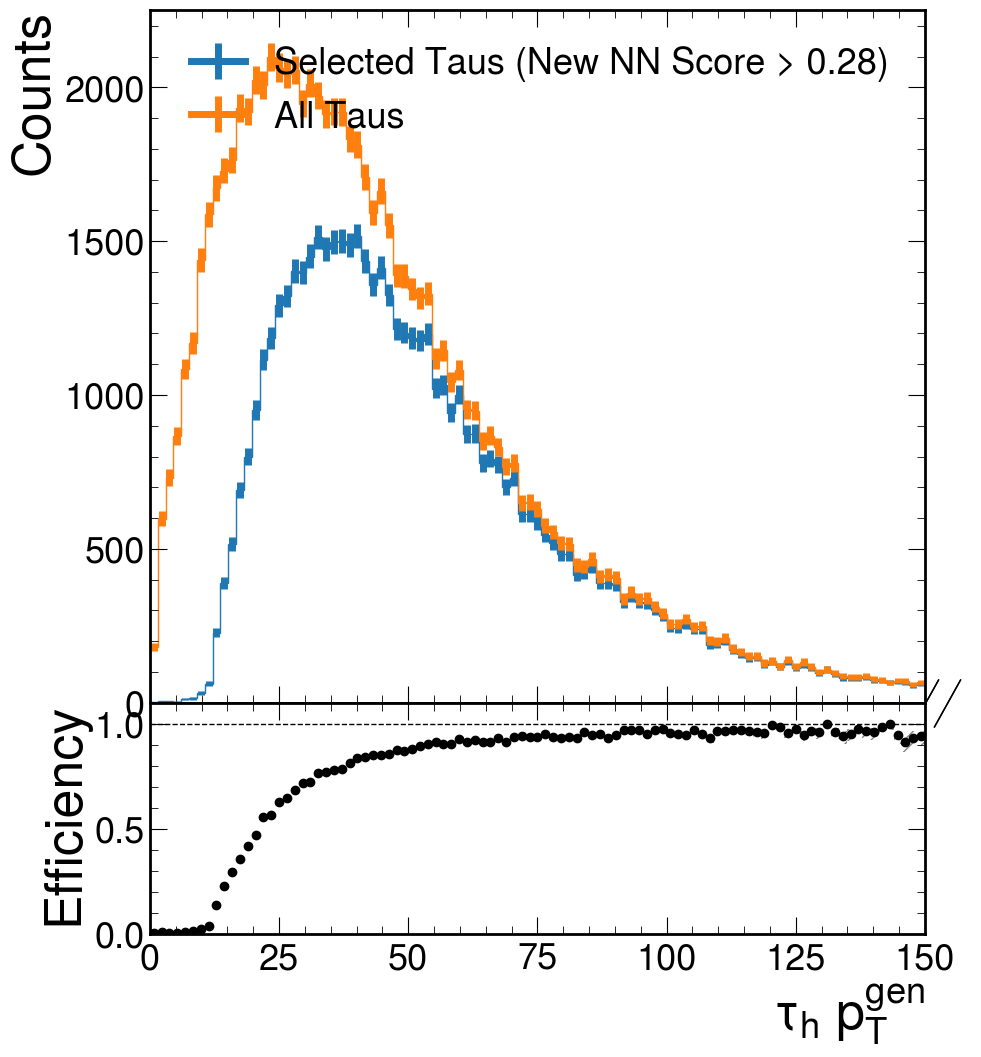

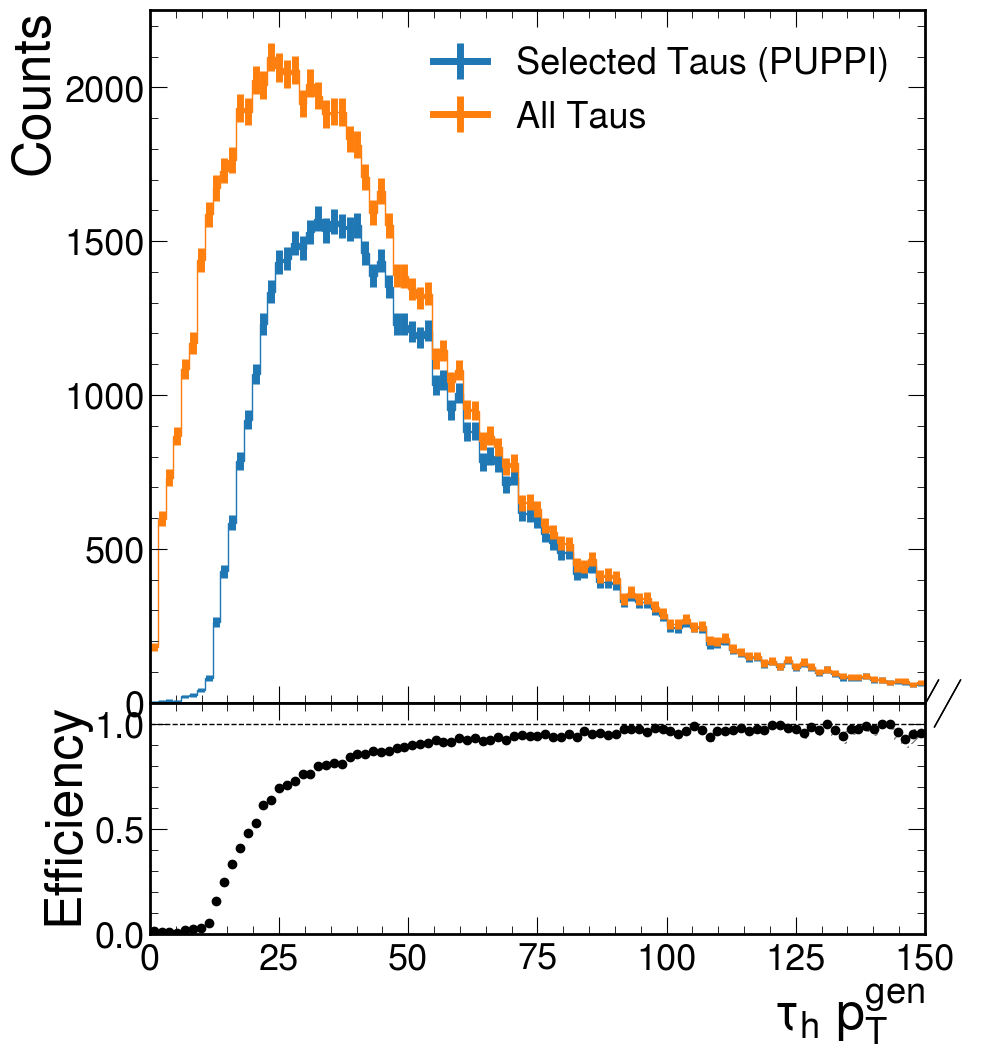

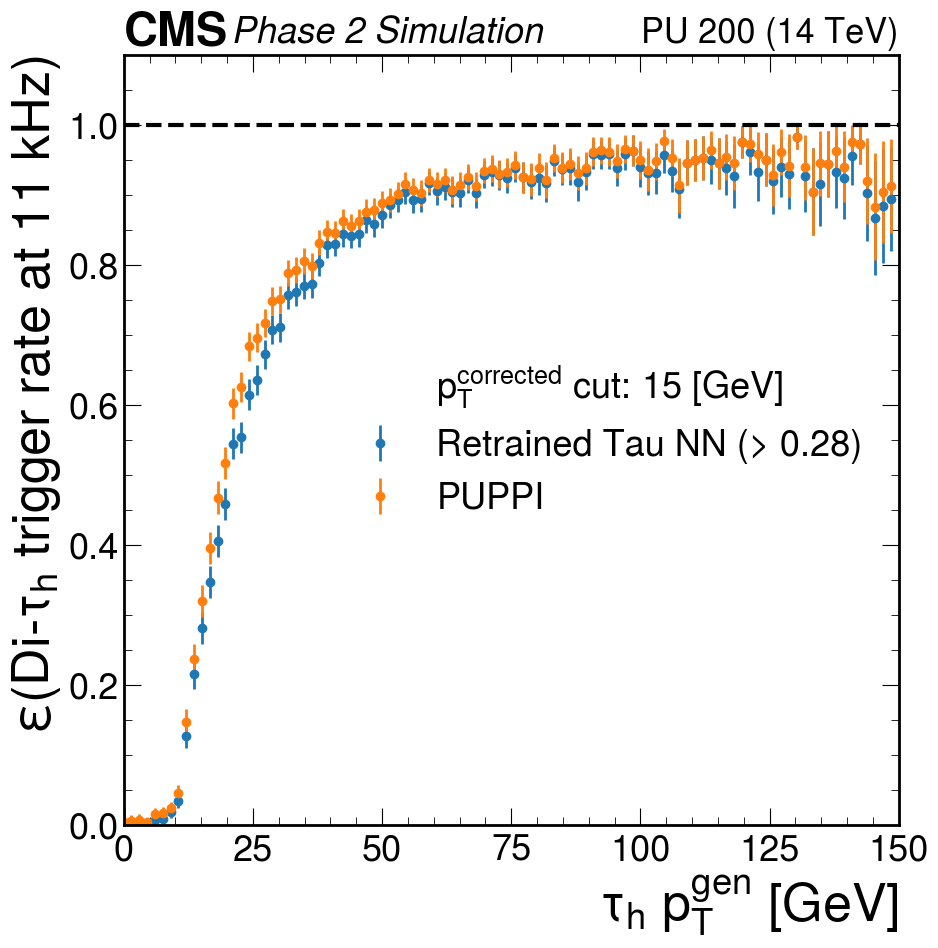

In [4]:
results = plot_pt_eff_puppi(model_name,
                            model_name,
                            '../../ntuples/Jan_25_2023/test_sig_v12_emseed.root',
                            corrected_pt_cut=15.,
                            cut_point = 0.28)

1905/1905 [==============================] - 2s 1ms/step


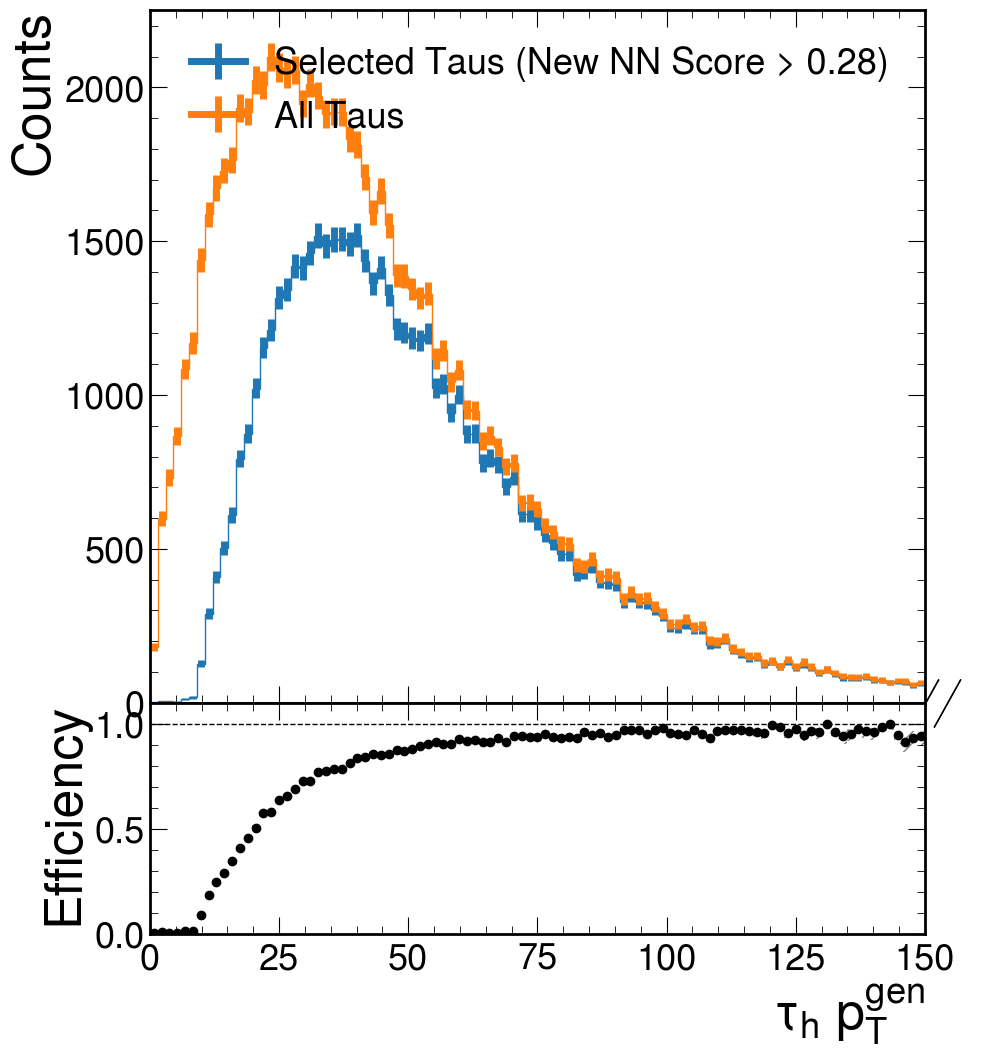

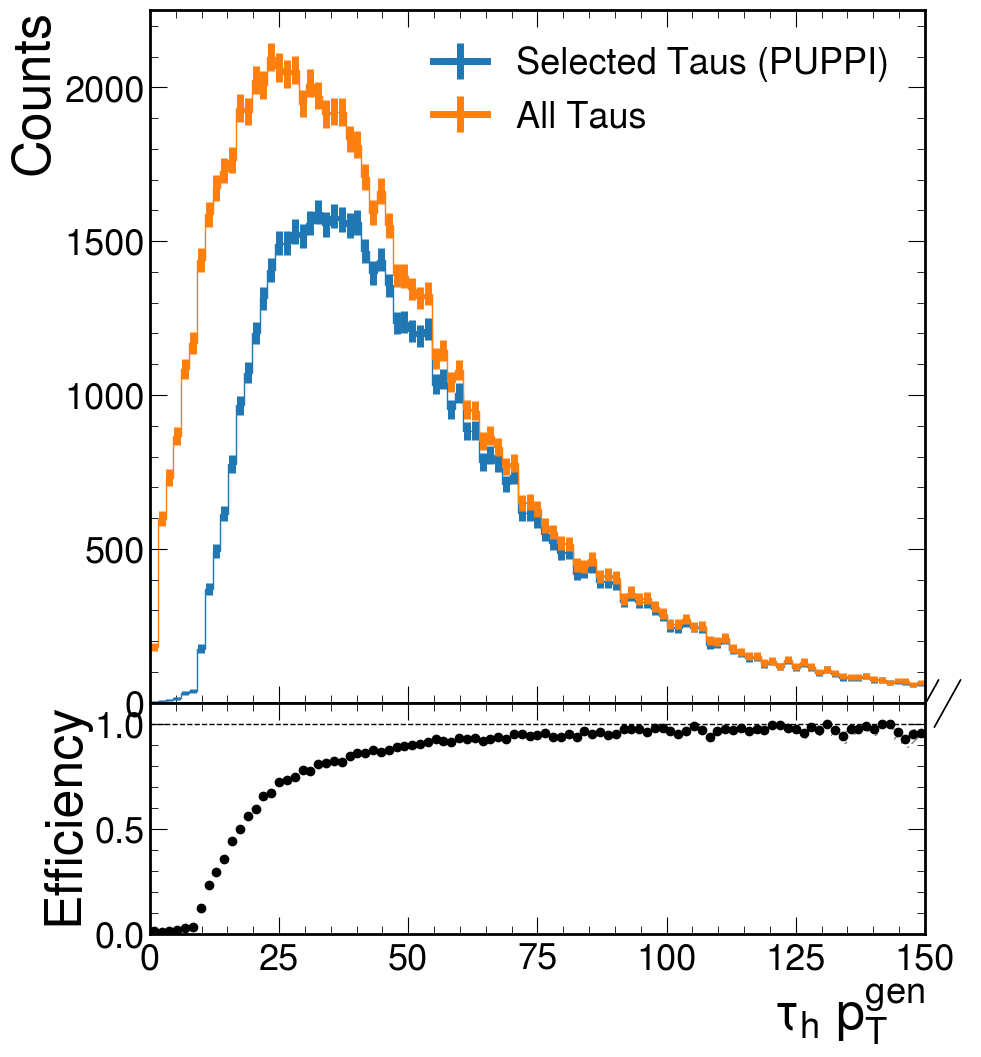

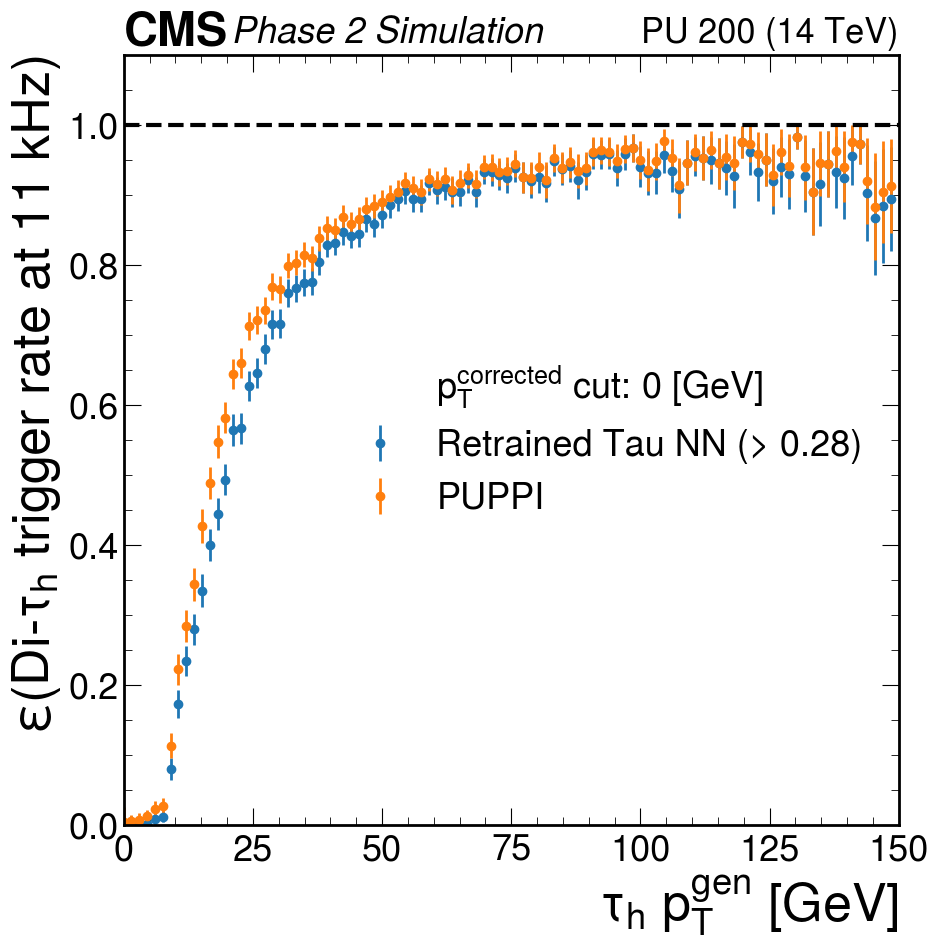

1840/1840 [==============================] - 2s 1ms/step


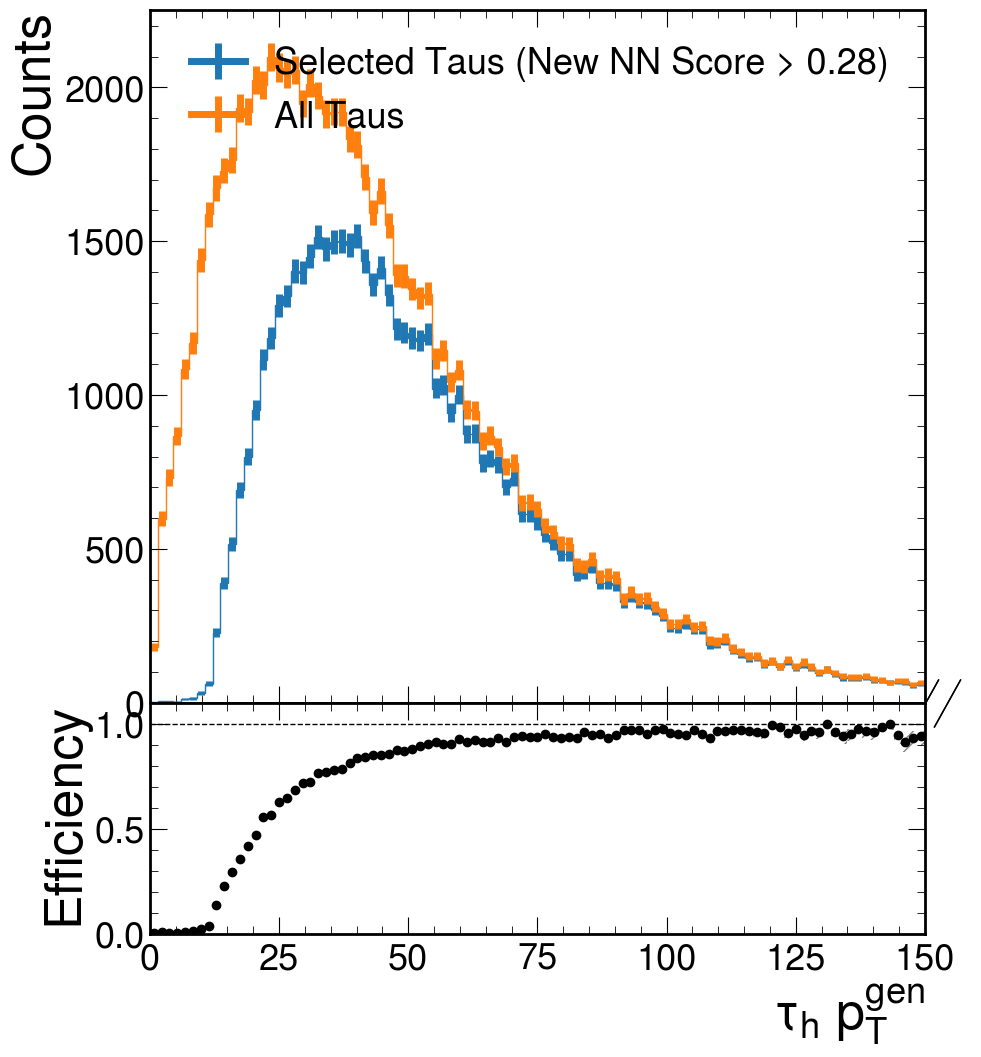

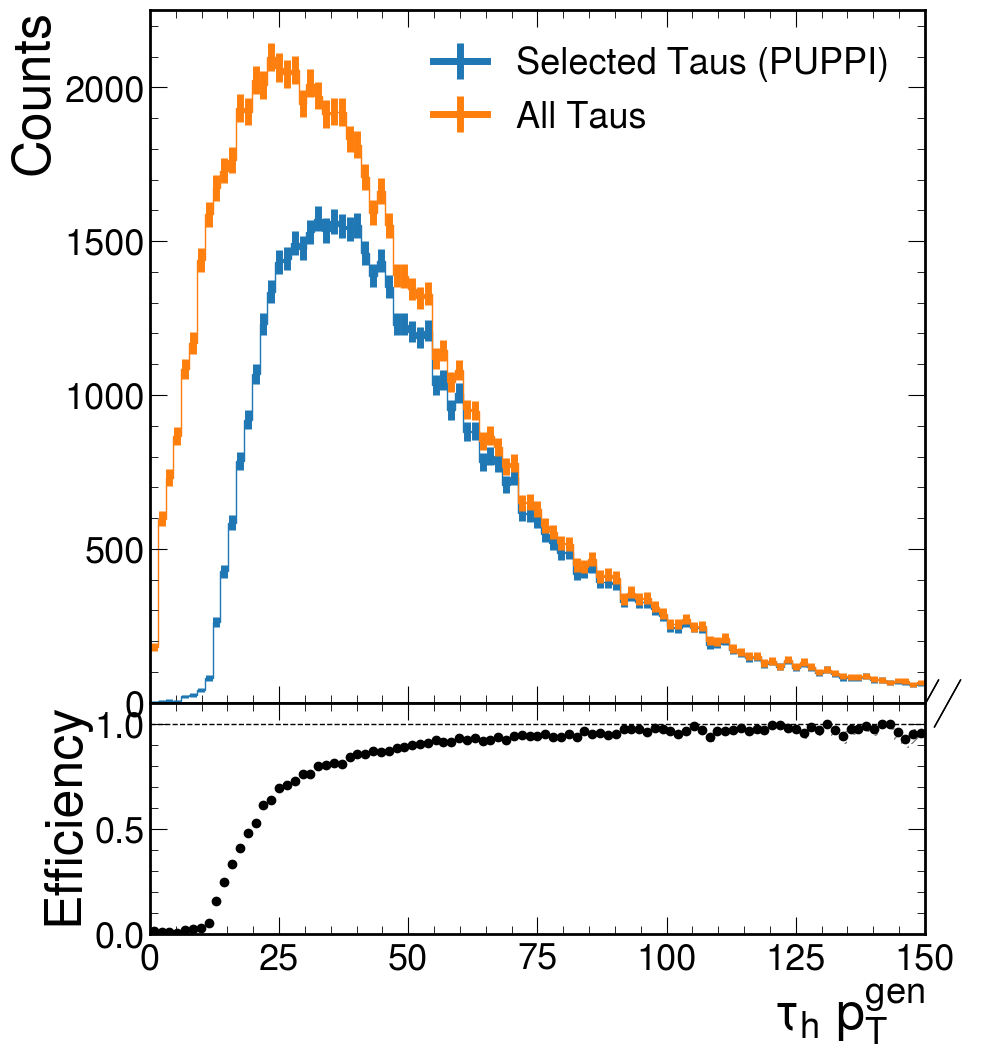

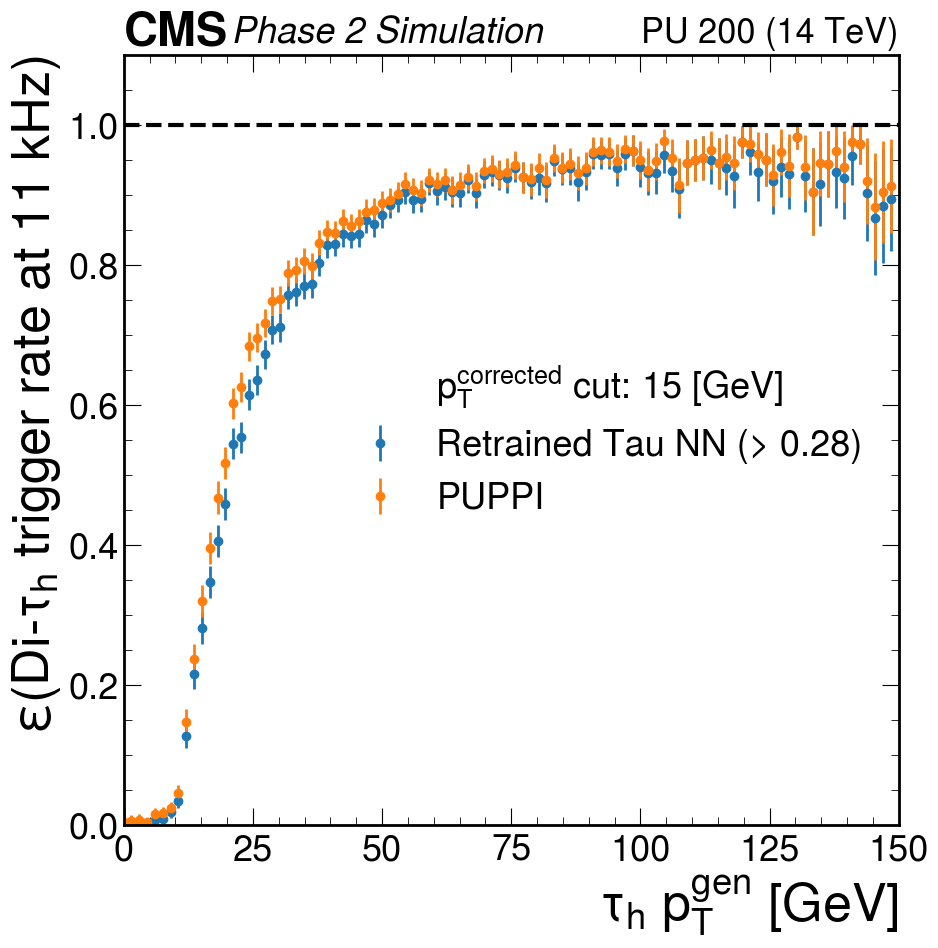

[1.         1.         1.         1.         0.90088786 0.79748638
 0.22136359 0.19500858 0.5455388  0.76923872 0.84048418 0.8684884
 0.91342059 0.92993574 0.9654419  0.97720903 0.98056663 0.98473677
 0.98845409 0.98910584 0.99228147 0.99594099 0.99308046 0.99453622
 0.99590715 0.99930808 0.99864108 0.99856185 0.99620024 1.
 1.         0.99828683 1.         1.         1.         0.99912728
 0.99896912 0.99898435 1.         1.         0.99878742 1.
 1.         0.99866378 1.         0.99848291 0.99560354 1.
 1.         1.         1.         1.         0.99775374 0.99774173
 1.         1.         1.         0.99714737 0.99717534 1.
 1.         1.         1.         1.         1.         0.99579297
 1.         1.         1.         1.         1.         1.
 1.         0.9941563  1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 

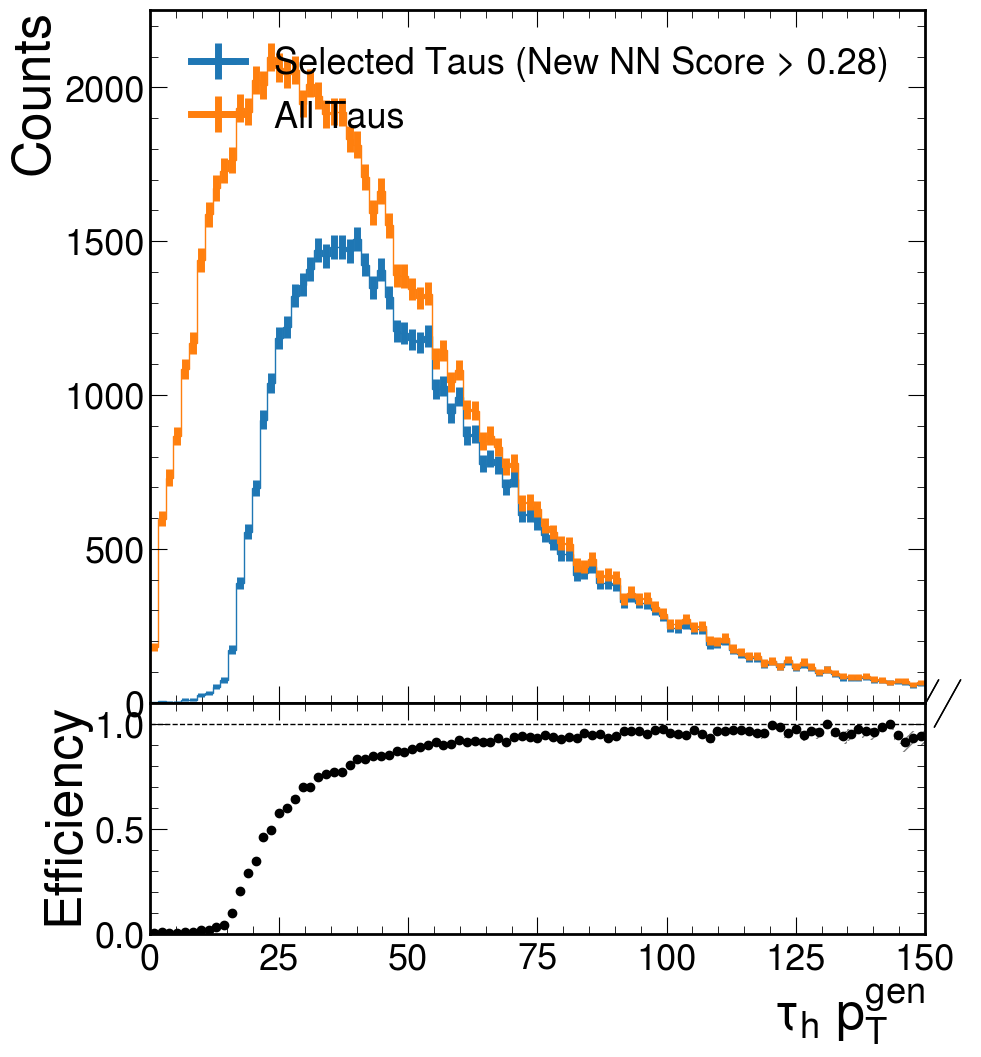

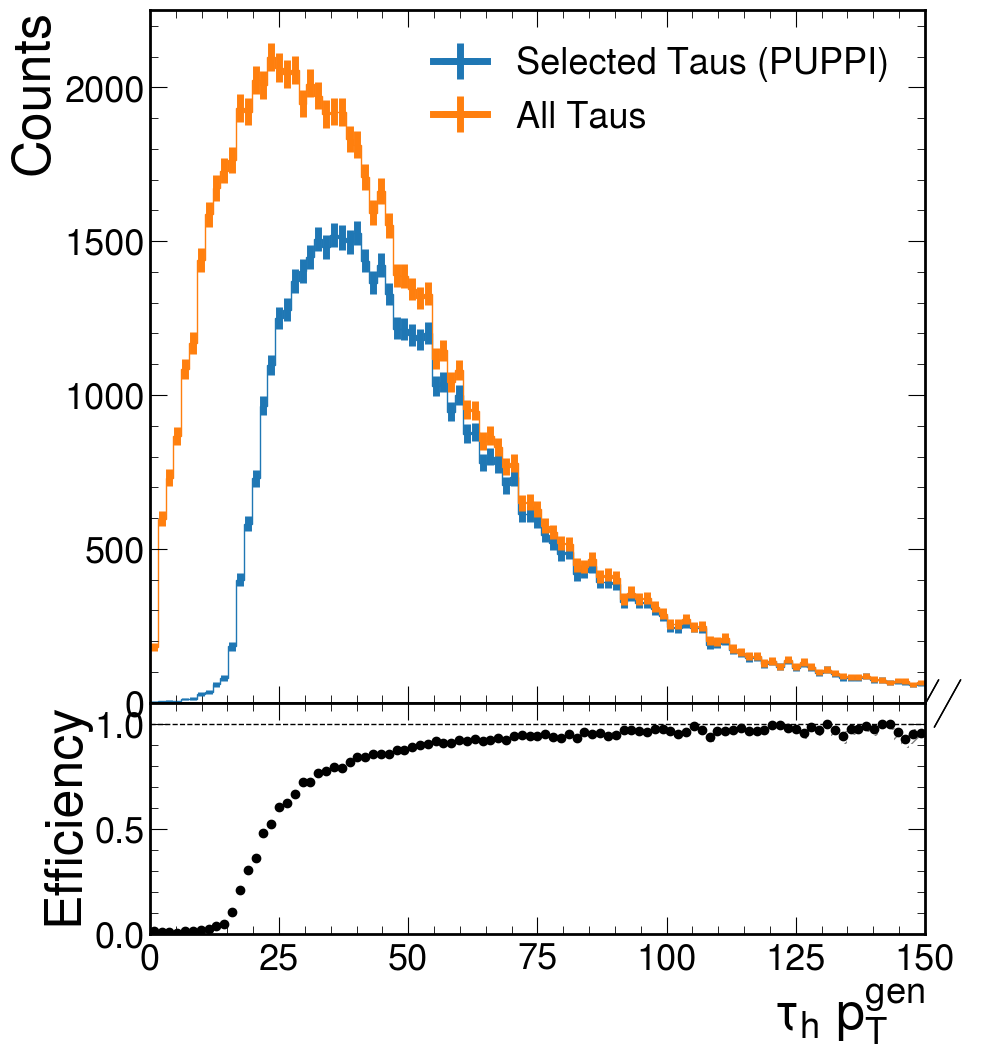

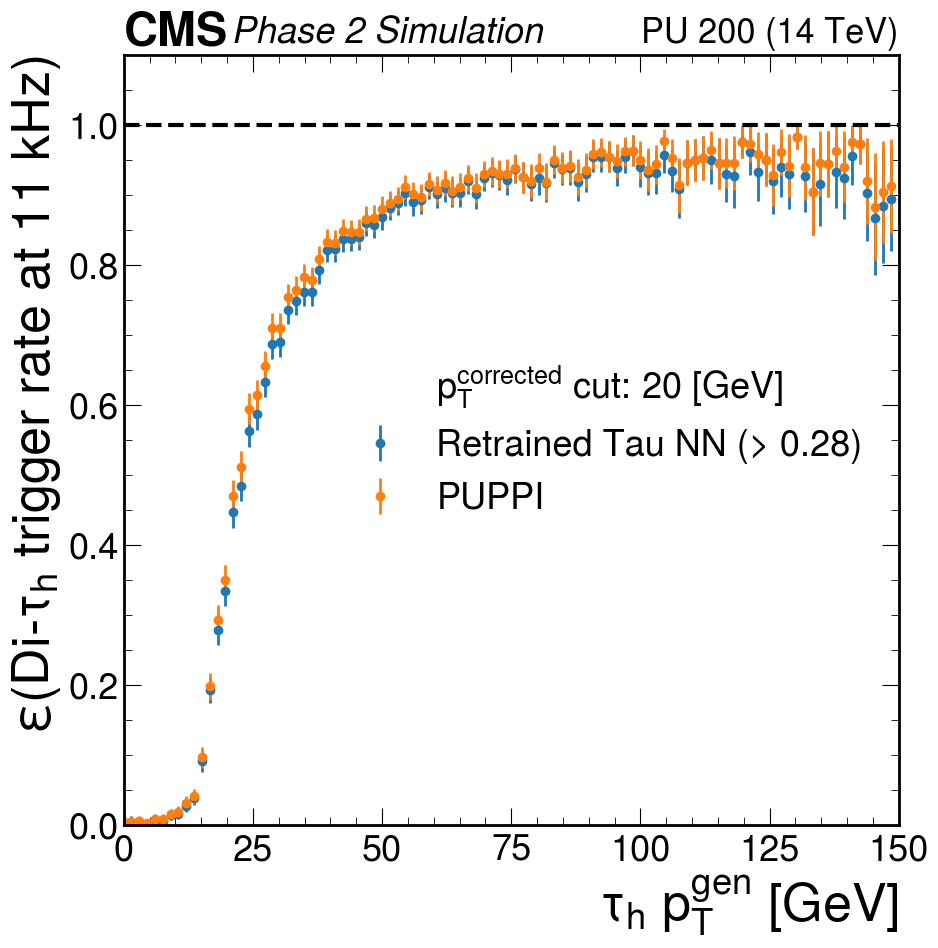

[1.         1.         0.65544255 0.51784426 0.80262524 0.53324888
 0.17413226 0.08991584 0.11505721 0.13578359 0.27041277 0.48144749
 0.62796486 0.67663544 0.79310422 0.85503463 0.89751769 0.90853061
 0.93079575 0.96080486 0.9635347  0.96890345 0.97648465 0.98361402
 0.98159009 0.9854771  0.99117003 0.9899371  0.9886056  0.99487891
 0.99452298 0.99400579 0.99827113 0.99647914 0.99555807 0.99389431
 0.99690823 0.99492411 0.99776737 0.99366282 0.99394151 0.99757418
 0.99863574 0.99866378 0.99861758 0.99696658 0.99121714 0.99822842
 1.         0.99815922 0.99799193 1.         0.99551012 0.99774173
 1.         0.99736353 1.         0.99714737 0.99717534 0.99711405
 0.99647239 0.99669413 0.99646153 1.         0.99615597 0.99579297
 1.         1.         1.         1.         1.         1.
 1.         0.9941563  1.         1.         1.         0.99182001
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.     

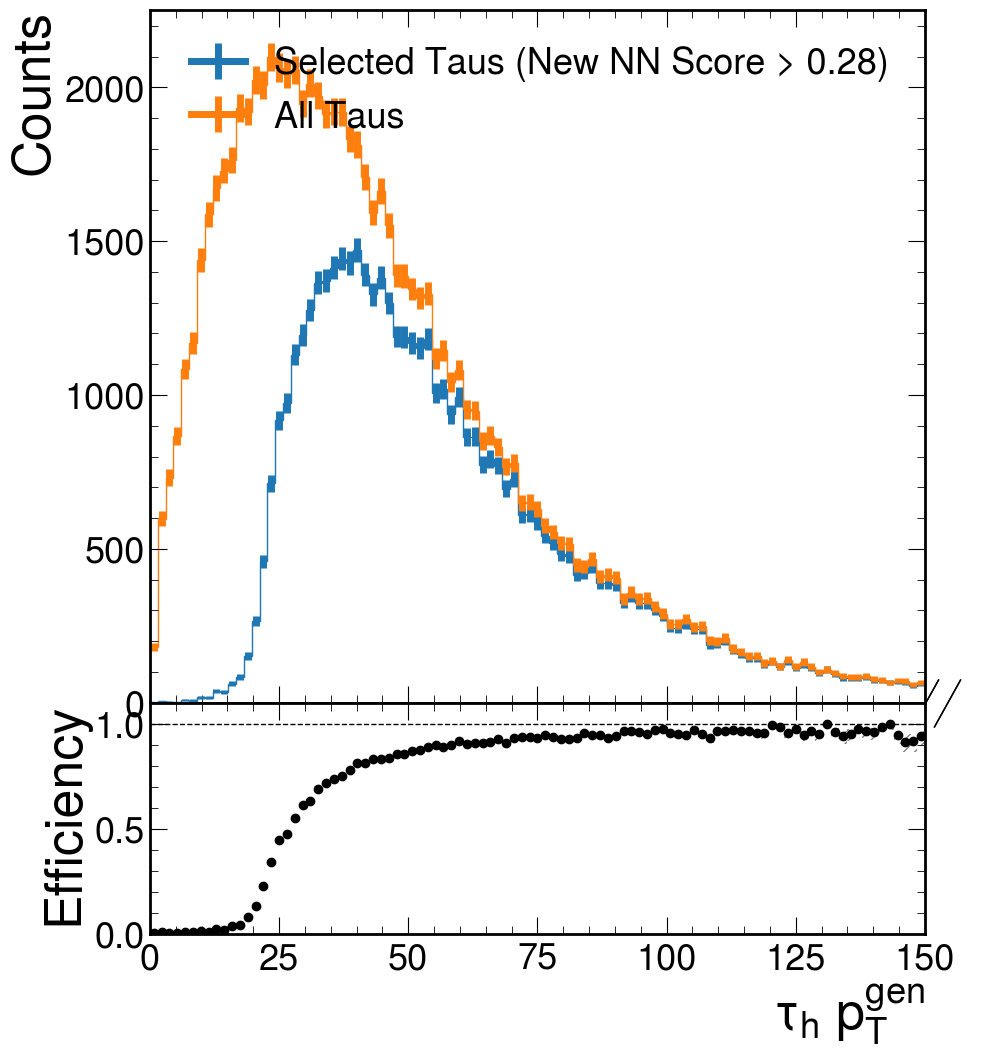

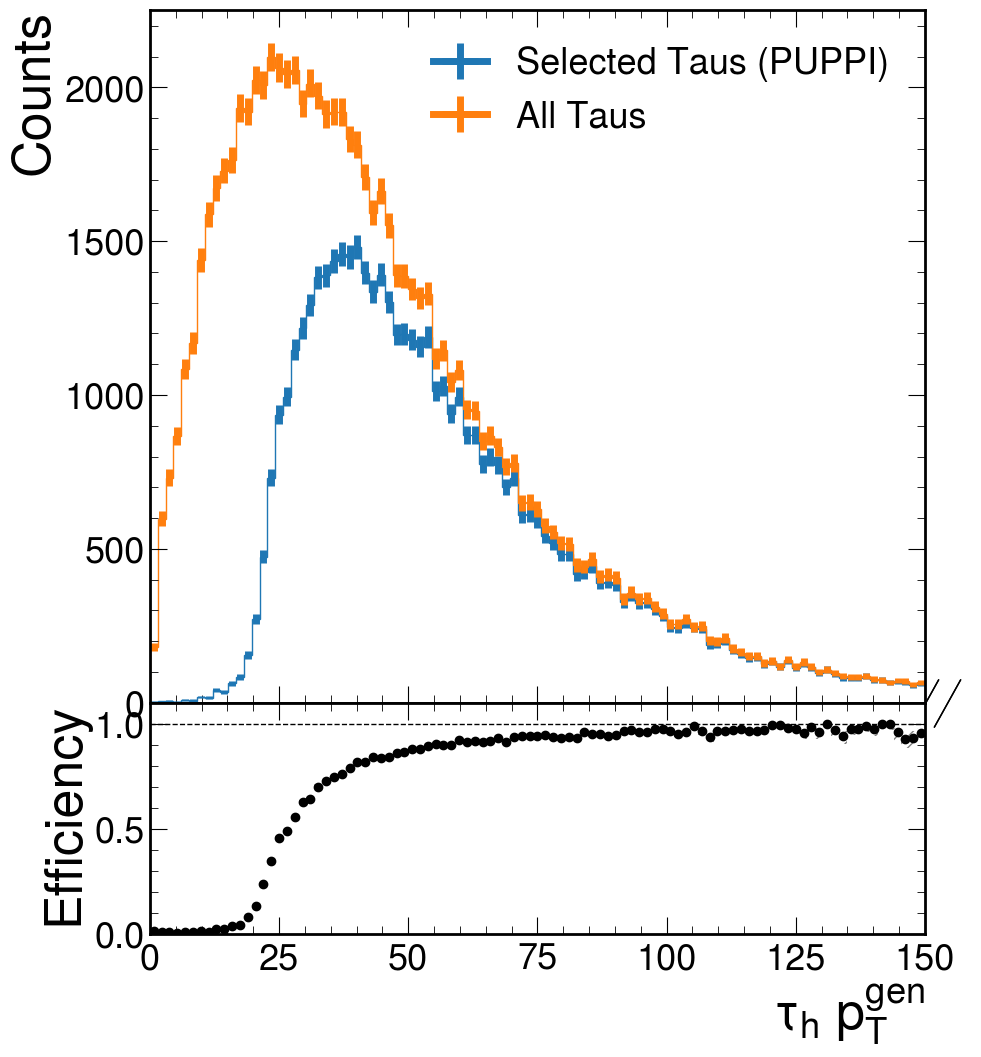

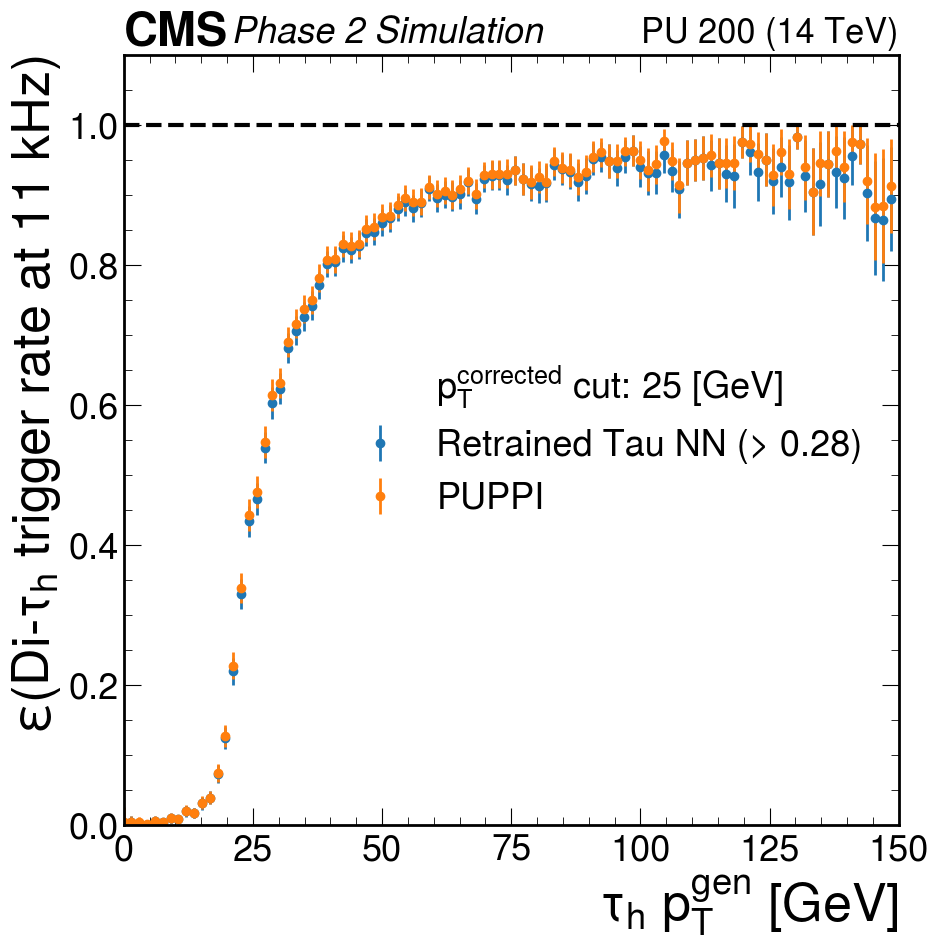

[1.         1.         0.65544255 0.12628835 0.60922601 0.34182805
 0.11224657 0.04407813 0.08178302 0.05848098 0.09200408 0.0972963
 0.16336419 0.25118201 0.38890808 0.5817257  0.69189603 0.7210337
 0.79286004 0.84285939 0.87050571 0.89607932 0.92126926 0.9372687
 0.95639334 0.95854527 0.96675275 0.96625353 0.97267676 0.97588111
 0.97967324 0.97776101 0.98704331 0.98680672 0.97871092 0.98518482
 0.98251241 0.98580166 0.99330568 0.99049909 0.98789354 0.98788947
 0.99318439 0.99599301 0.99585515 0.9893958  0.98975709 0.99469084
 1.         0.99815922 0.99598683 0.99790575 0.99551012 0.98649262
 1.         0.99473437 1.         0.99146395 0.99717534 0.99423437
 0.99296522 0.99669413 0.98944383 1.         0.99615597 0.99579297
 1.         1.         1.         1.         1.         1.
 1.         0.9941563  1.         0.99235507 1.         0.99182001
 1.         1.         1.         1.         1.         1.
 1.         0.98718575 1.         1.         1.         1.
 1.         1.        

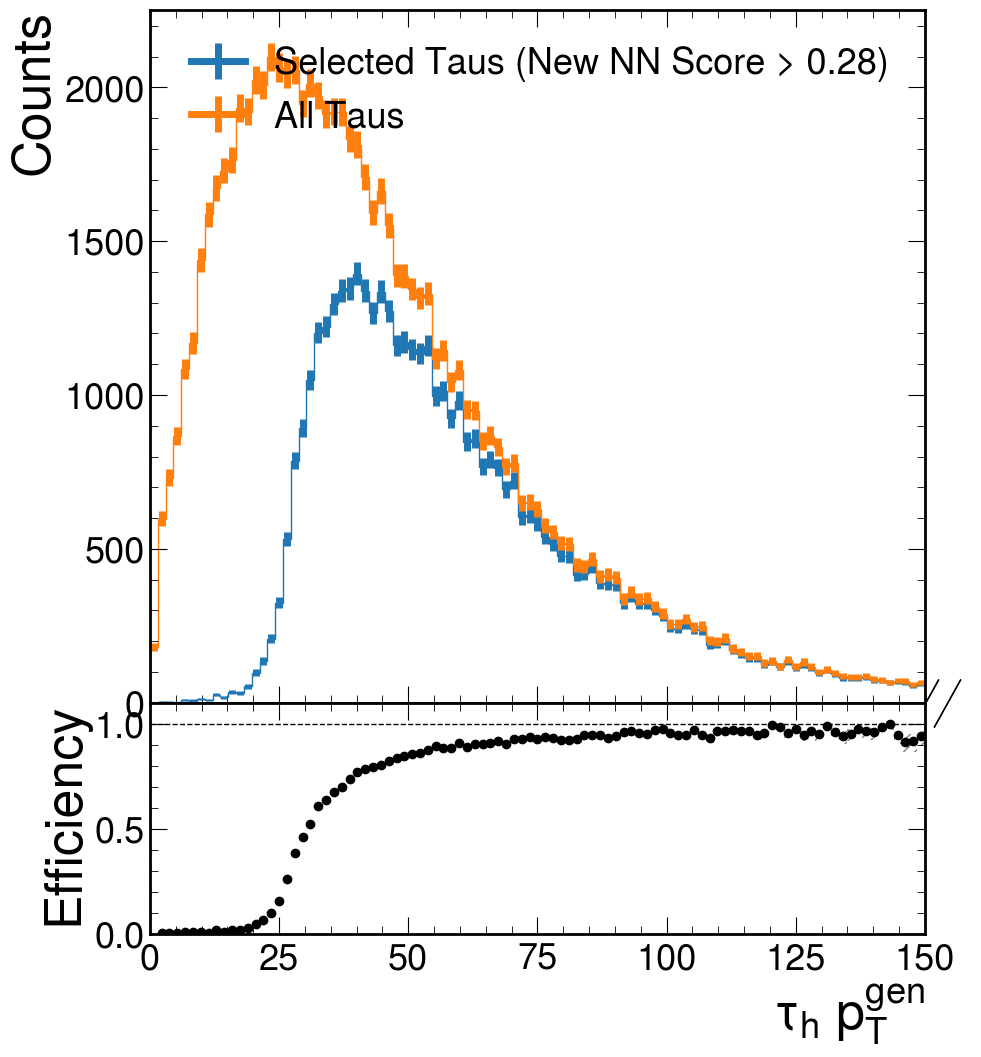

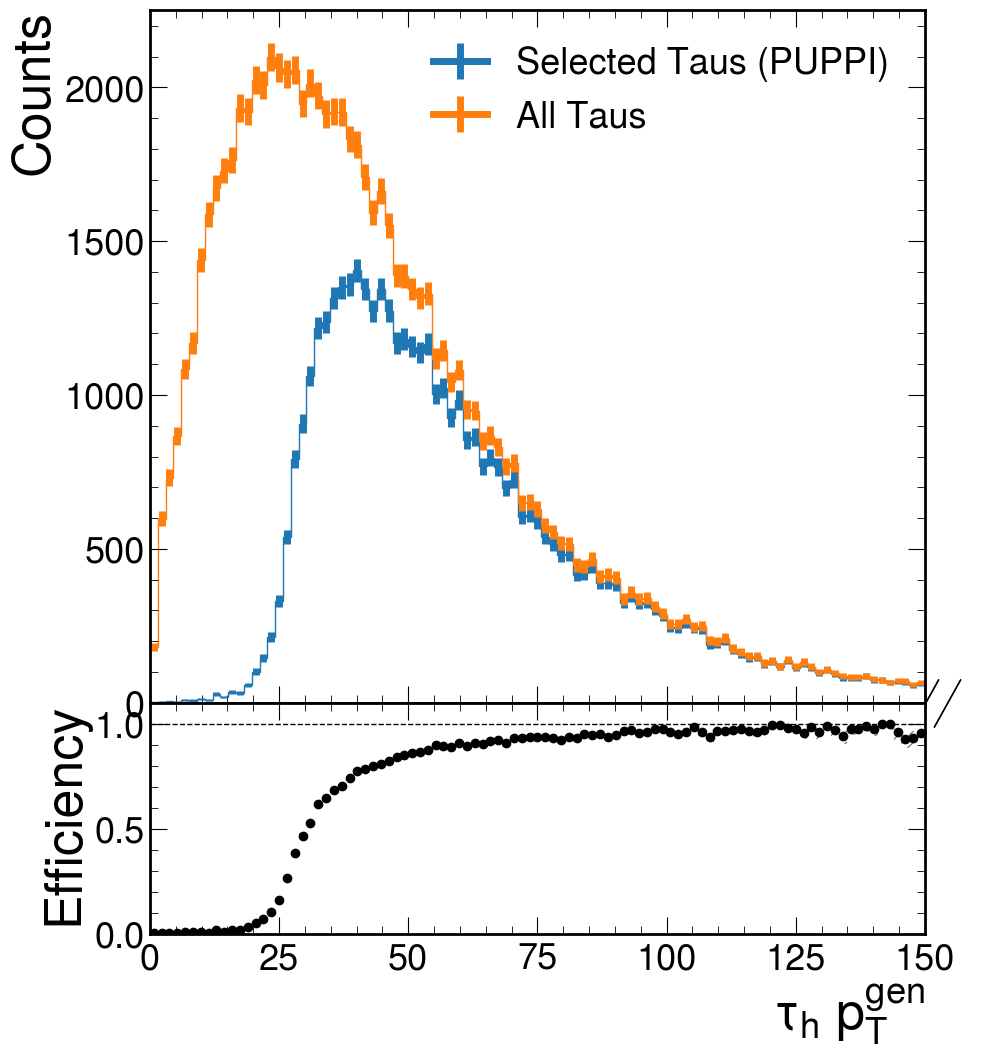

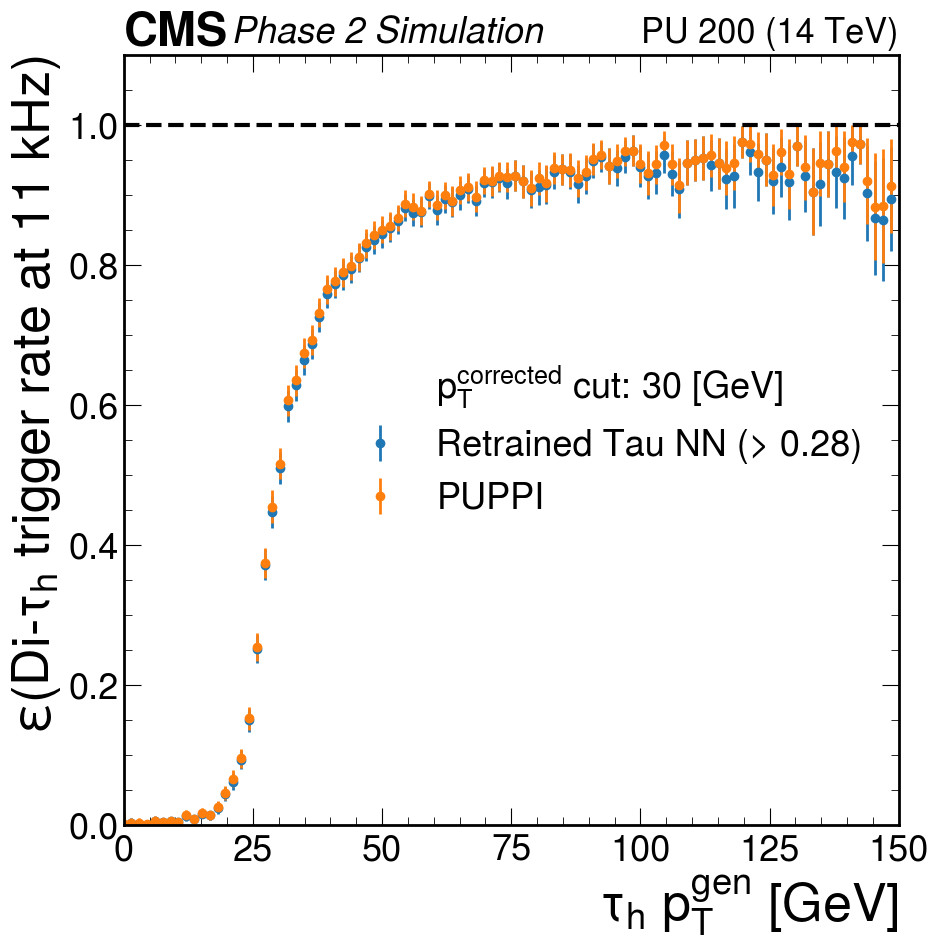

[0.         0.65541447 0.3394046  0.12628835 0.60922601 0.34182805
 0.06718738 0.02216166 0.05371425 0.02677744 0.04788386 0.03424833
 0.05379413 0.08848992 0.10936915 0.16351782 0.23834622 0.38814463
 0.54645967 0.62487431 0.71172513 0.78792935 0.81879952 0.85777387
 0.88574437 0.90206588 0.91535187 0.92902503 0.92729571 0.94307829
 0.95938834 0.95388124 0.9732463  0.96837837 0.96279238 0.96607167
 0.97430784 0.97871807 0.97883569 0.97892378 0.96980544 0.98064379
 0.98502336 0.99465842 0.9862102  0.9863723  0.98247135 0.98411844
 0.99646805 0.99264695 0.98799355 0.99372445 0.98656007 0.98425053
 0.99737341 0.98428167 1.         0.99146395 0.9943554  0.99423437
 0.98947621 0.99669413 0.98249175 1.         0.99615597 0.99579297
 1.         0.99529509 1.         1.         0.99519542 1.
 1.         0.9941563  1.         0.99235507 1.         0.98372892
 1.         1.         1.         1.         1.         1.
 1.         0.98718575 0.98631808 1.         1.         1.
 1.         1.     

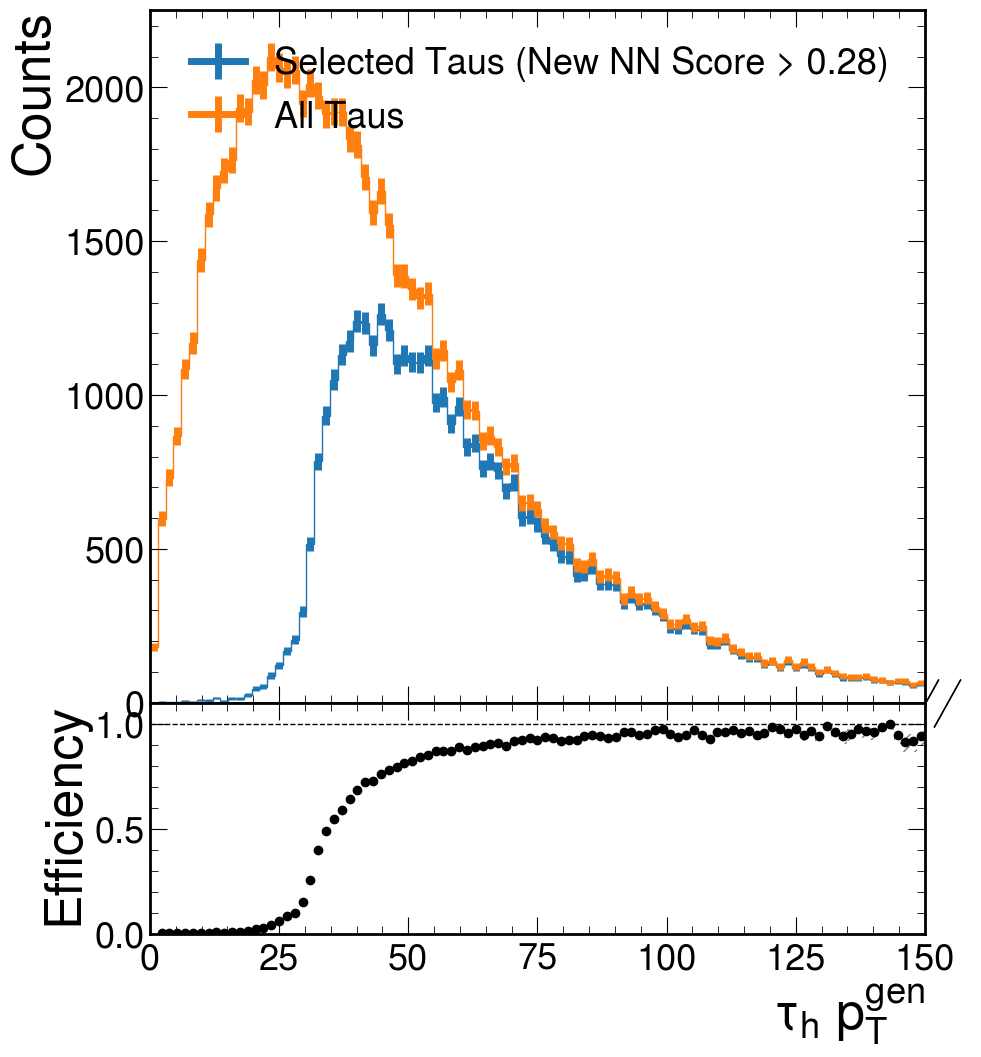

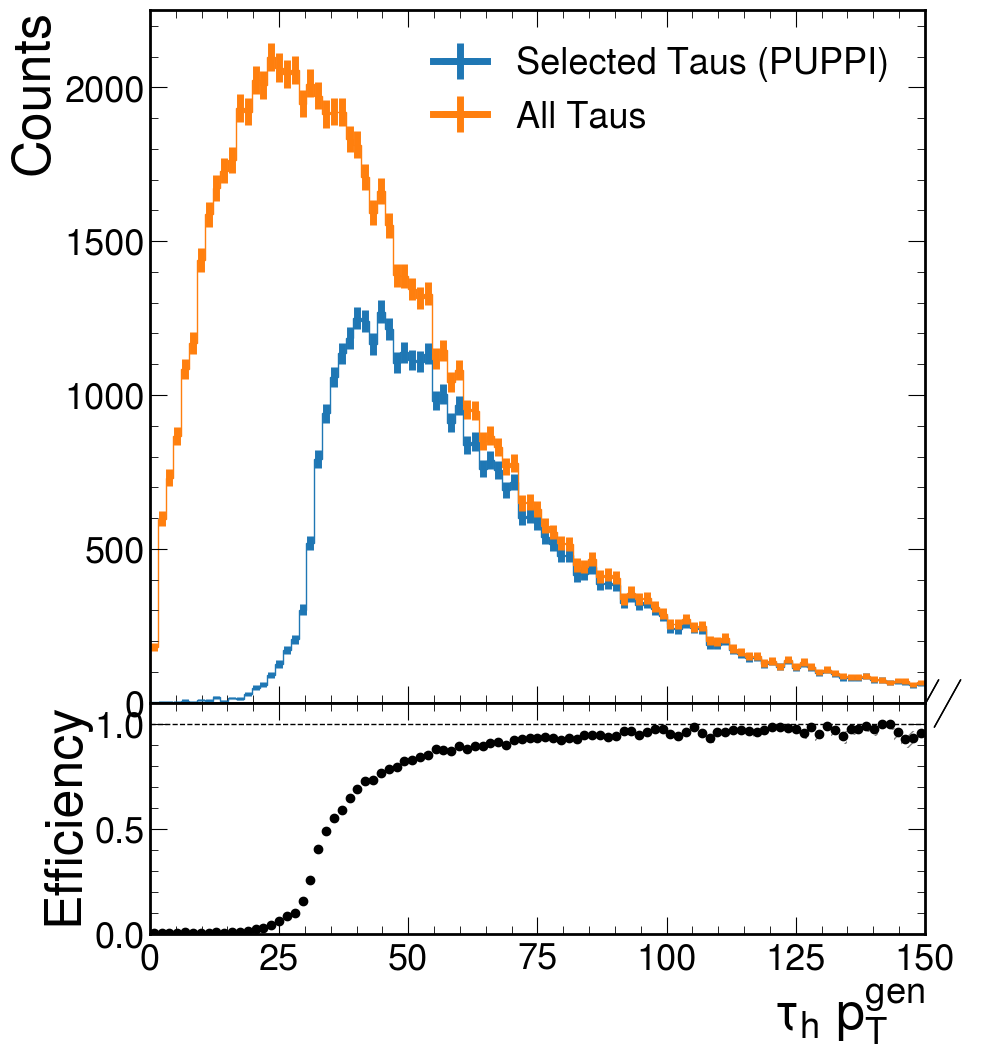

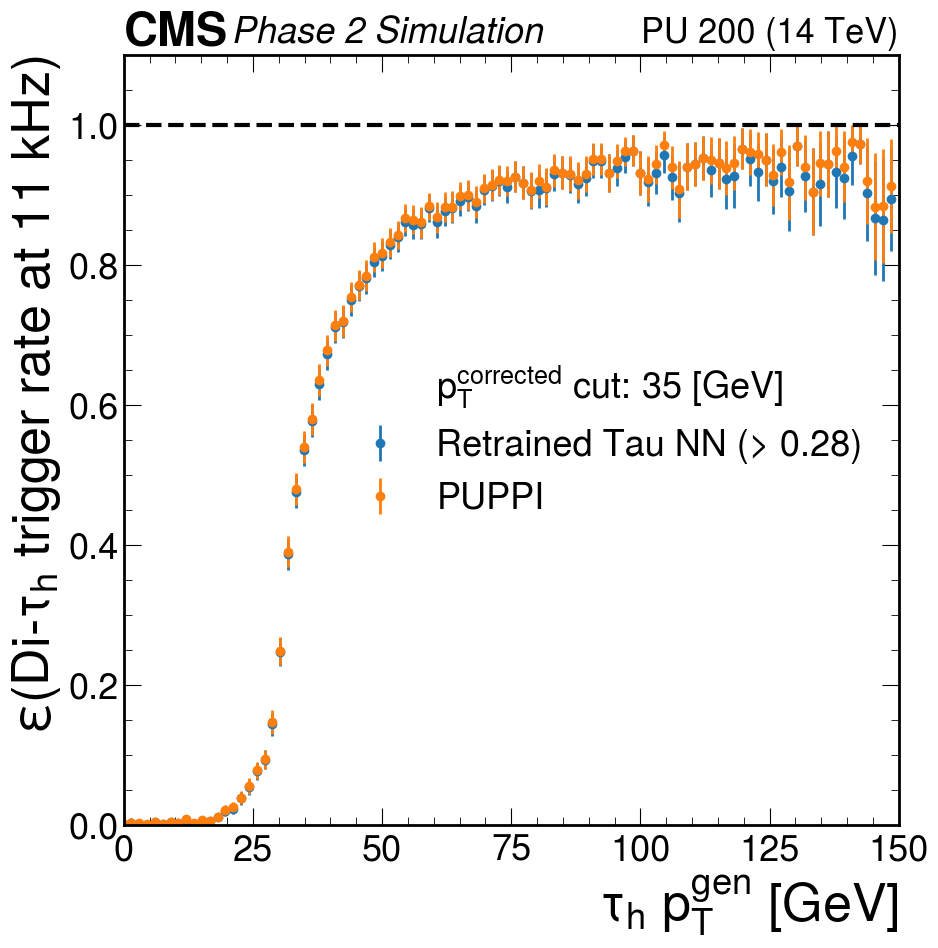

[0.         0.65541447 0.08276753 0.12628835 0.4214843  0.10573418
 0.04543811 0.01616612 0.02865186 0.00588441 0.01748622 0.01225409
 0.02354552 0.03937709 0.03967316 0.0663376  0.08525999 0.11791593
 0.13622951 0.20051957 0.3444954  0.50841883 0.62050618 0.69146973
 0.74441822 0.78412513 0.81168279 0.85484452 0.84749956 0.89004146
 0.91193676 0.90206133 0.93627102 0.93251953 0.93633859 0.93923398
 0.95181427 0.95953697 0.9599754  0.96005589 0.95059038 0.96258763
 0.97552427 0.9853306  0.97385709 0.97731709 0.97230784 0.97885243
 0.99118229 0.98714876 0.98600147 0.99163723 0.98432826 0.97977335
 0.99213106 0.9816826  0.99501139 0.98580668 0.9943554  0.9913606
 0.98947621 0.99013175 0.97216195 1.         0.99615597 0.99579297
 0.99060893 0.98594472 1.         1.         0.99041382 0.99395768
 0.99378425 0.98837452 1.         0.98480971 1.         0.98372892
 1.         0.98997051 0.988899   1.         1.         1.
 1.         0.97458786 0.98631808 1.         1.         1.
 1.         

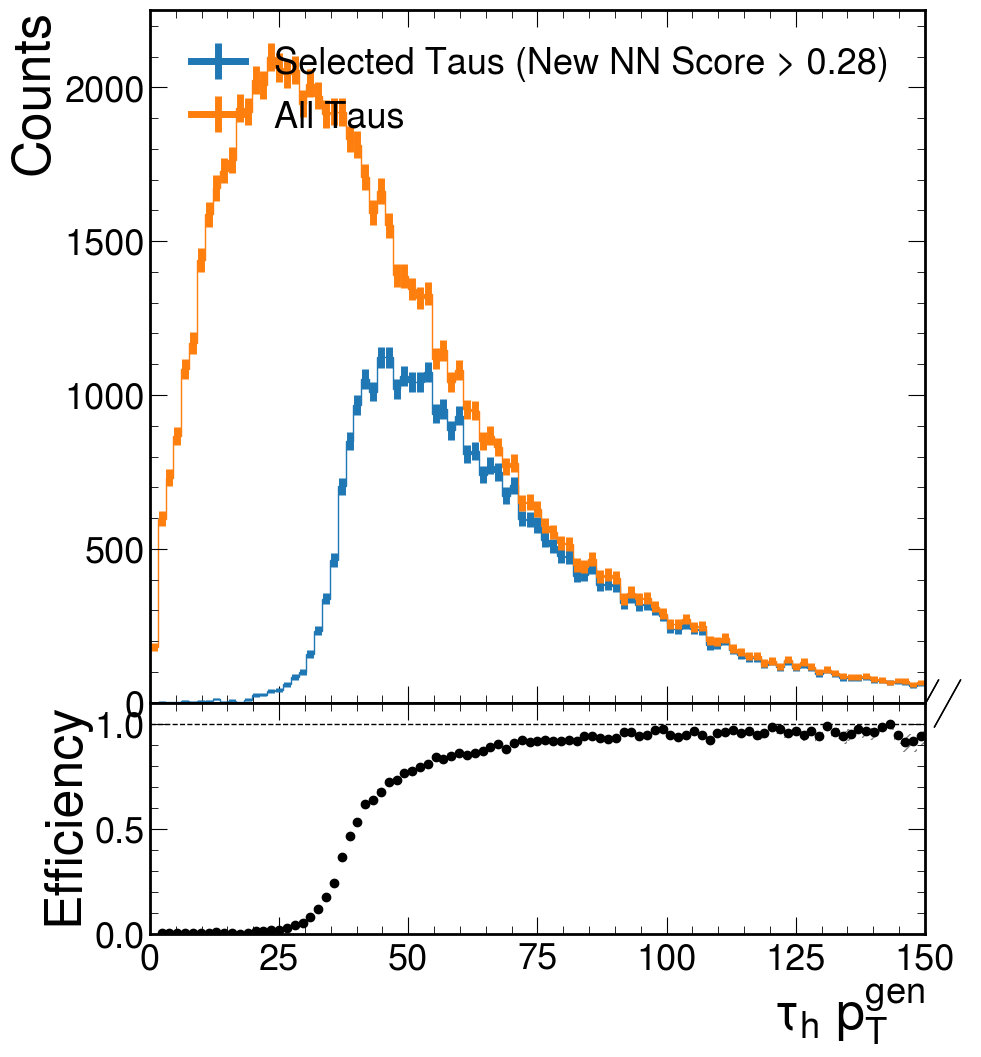

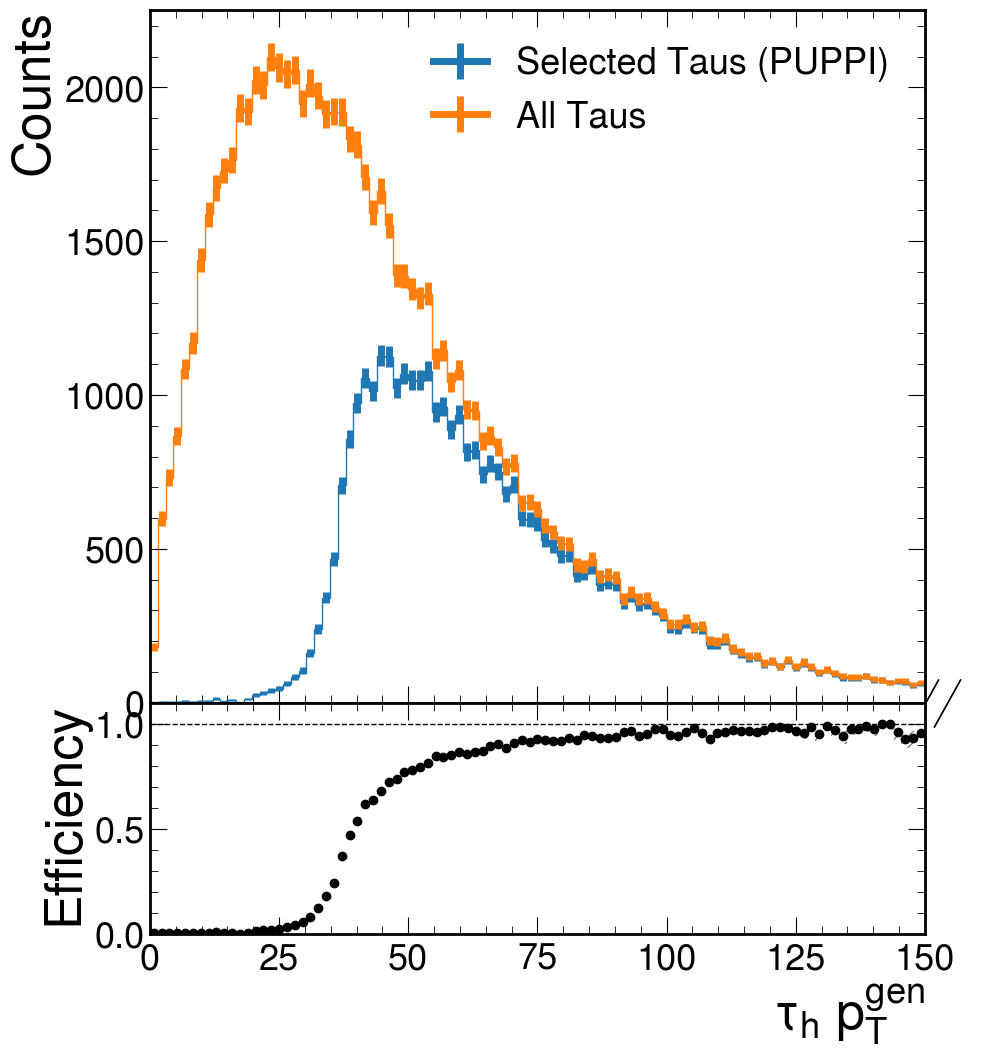

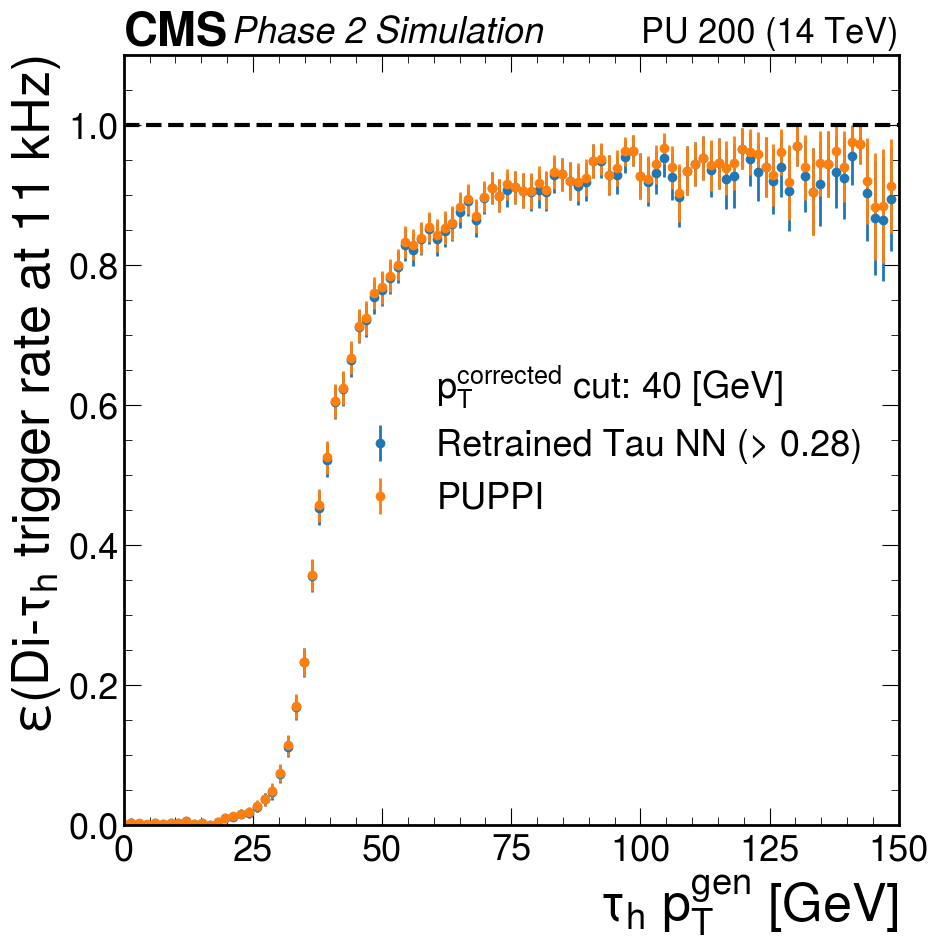

[0.00000000e+00 6.55414473e-01 8.27675299e-02 1.26288353e-01
 3.30663228e-01 1.05734183e-01 3.14371050e-02 1.03904856e-02
 1.98348890e-02 2.83226310e-03 7.49637098e-03 2.24061706e-04
 8.09539382e-03 1.91919652e-02 1.85233645e-02 2.68581328e-02
 2.68015398e-02 3.97025305e-02 5.29971698e-02 6.48379331e-02
 1.01280321e-01 1.46500691e-01 2.19069157e-01 2.99433618e-01
 4.57953042e-01 5.62827376e-01 6.29121852e-01 7.25726667e-01
 7.35209861e-01 7.88089597e-01 8.42992727e-01 8.33591824e-01
 8.78052721e-01 8.76800015e-01 8.82789477e-01 8.91834406e-01
 9.15185078e-01 9.19337729e-01 9.35655873e-01 9.27731182e-01
 9.23085311e-01 9.31451707e-01 9.49844111e-01 9.68066844e-01
 9.67014464e-01 9.56267347e-01 9.59294142e-01 9.75348471e-01
 9.68419227e-01 9.81663473e-01 9.70141287e-01 9.79157270e-01
 9.82098590e-01 9.79773352e-01 9.86902196e-01 9.79088534e-01
 9.92524015e-01 9.77363548e-01 9.91539975e-01 9.85629547e-01
 9.89476212e-01 9.90131751e-01 9.68740797e-01 9.89581871e-01
 9.96155967e-01 9.957929

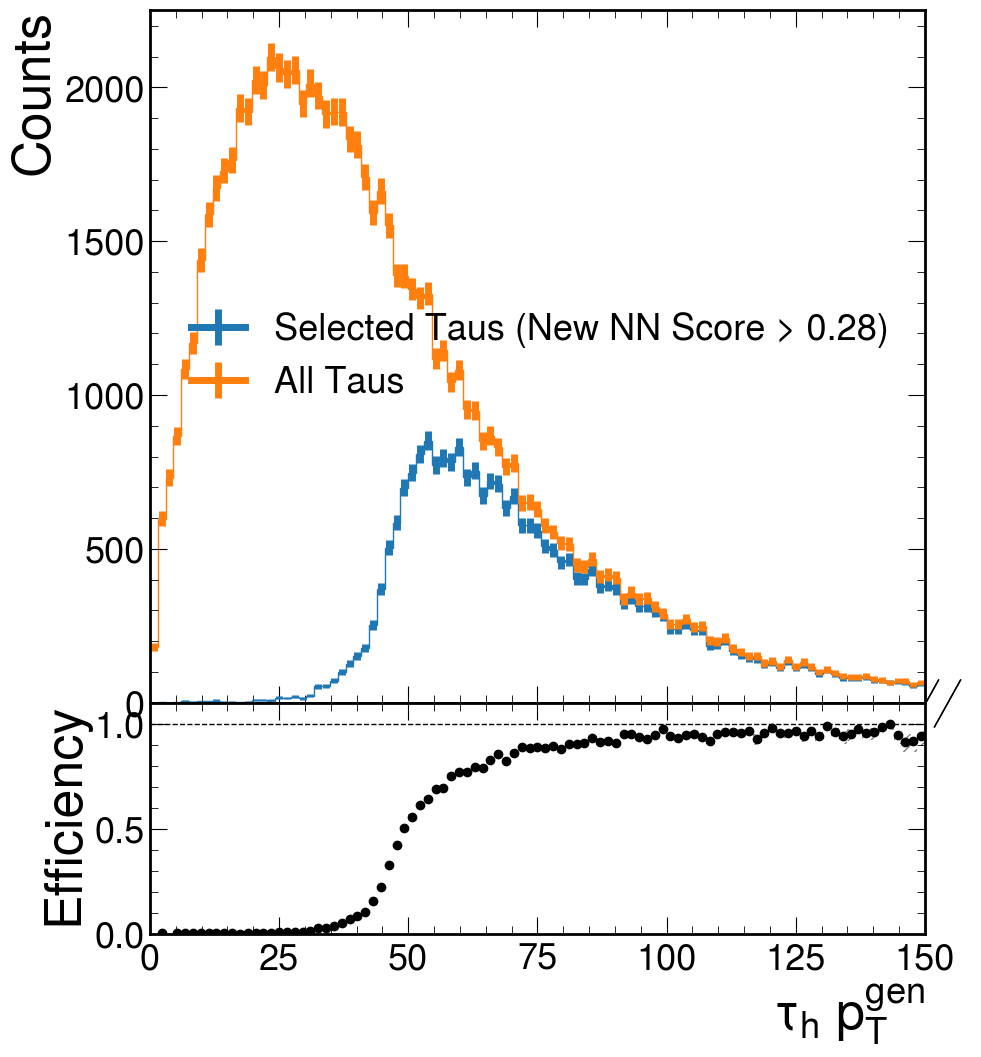

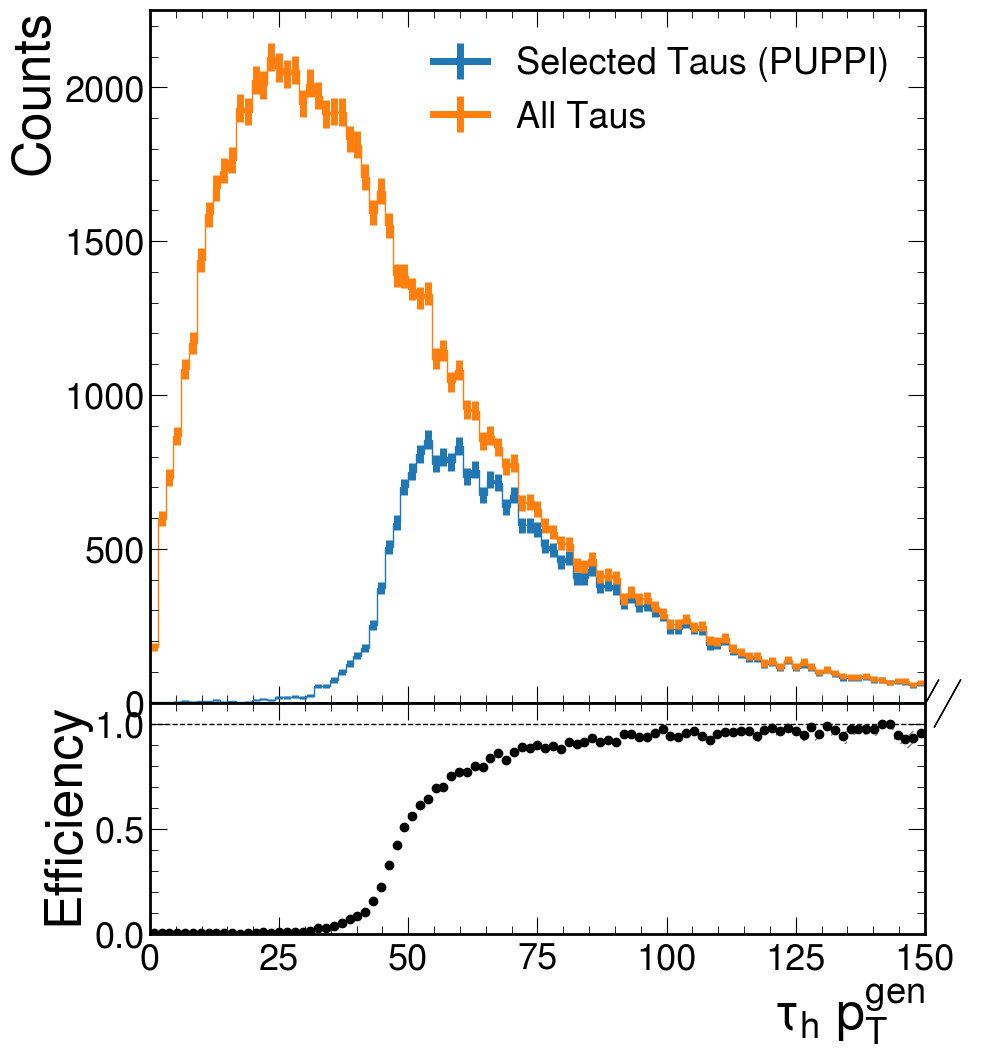

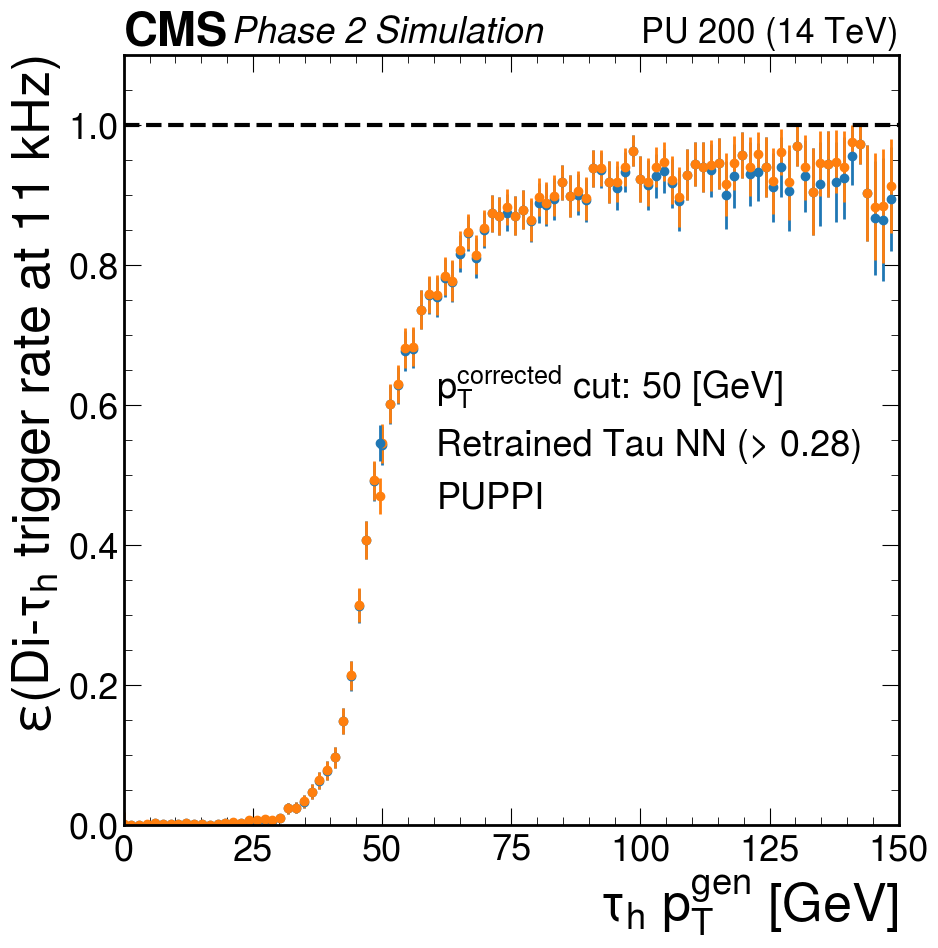

[0.00000000e+00 8.27538798e-02 0.00000000e+00 1.26288353e-01
 3.30663228e-01 1.05734183e-01 1.81091895e-02 7.62922332e-03
 1.13289740e-02 1.46681526e-03 2.31909553e-03 2.24061706e-04
 8.31529395e-04 6.07154784e-03 4.62650993e-03 3.72133282e-03
 9.31628049e-03 8.47572167e-03 1.05140090e-02 7.40926815e-03
 1.26756753e-02 3.05742821e-02 3.18911714e-02 4.28343828e-02
 6.06298784e-02 7.82306230e-02 9.32681876e-02 1.15631516e-01
 1.75291348e-01 2.52271060e-01 3.70634449e-01 4.70297402e-01
 5.71567685e-01 6.21767740e-01 6.78505672e-01 7.02358451e-01
 7.47115701e-01 7.61161318e-01 8.22739212e-01 8.24439508e-01
 8.31731903e-01 8.56616758e-01 8.58819702e-01 9.02206229e-01
 9.16725897e-01 8.95109421e-01 9.10539290e-01 9.37090441e-01
 9.37190752e-01 9.47167359e-01 9.27044607e-01 9.50273067e-01
 9.37872101e-01 9.59728131e-01 9.66103388e-01 9.43183935e-01
 9.80147856e-01 9.55050834e-01 9.77523858e-01 9.57243561e-01
 9.79100789e-01 9.77163972e-01 9.58533164e-01 9.68996600e-01
 9.73533735e-01 9.957929

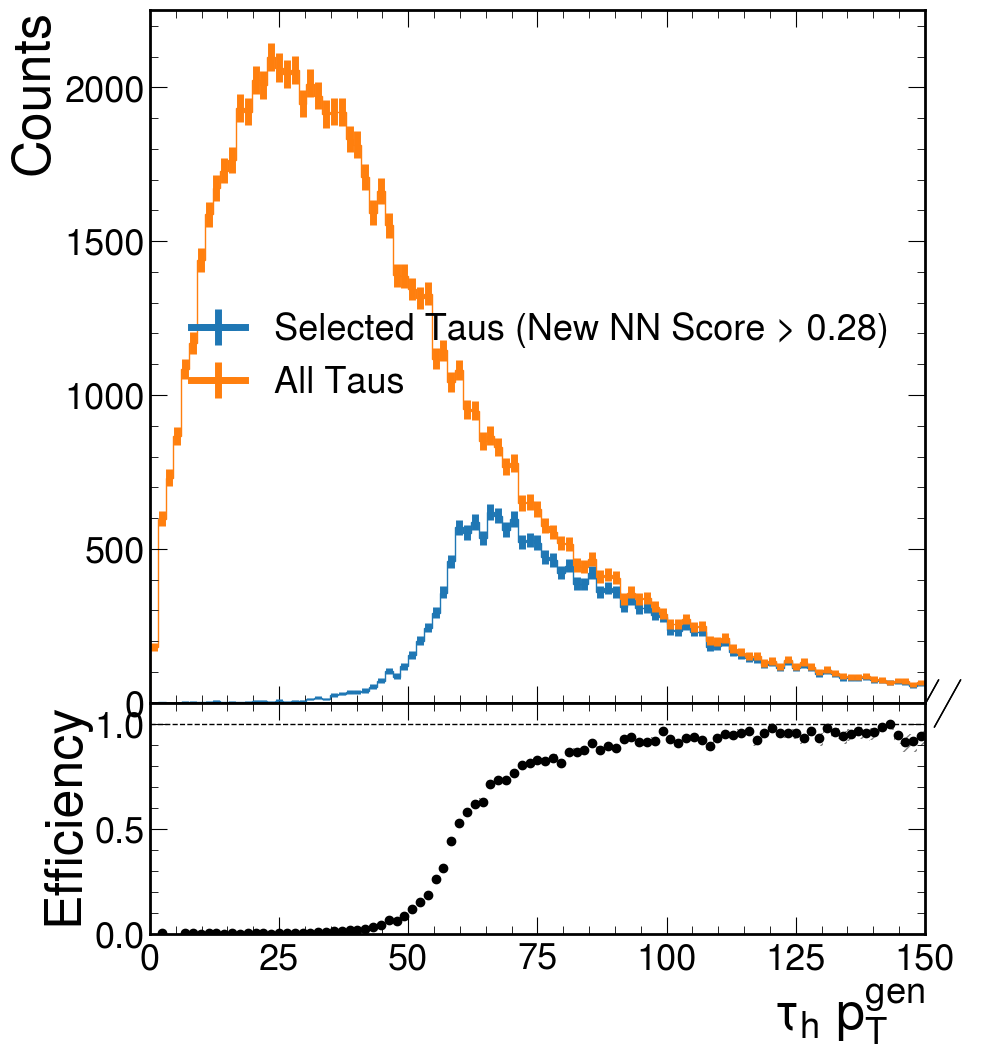

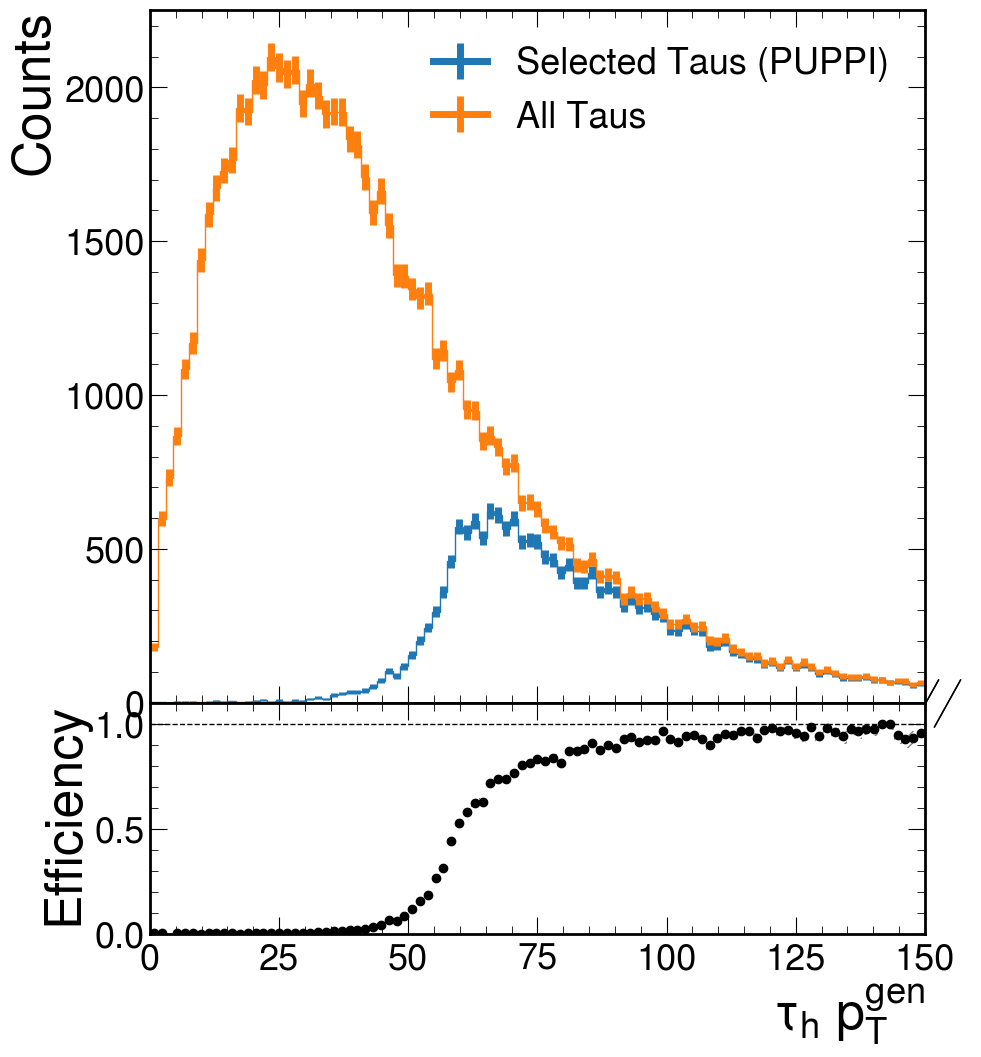

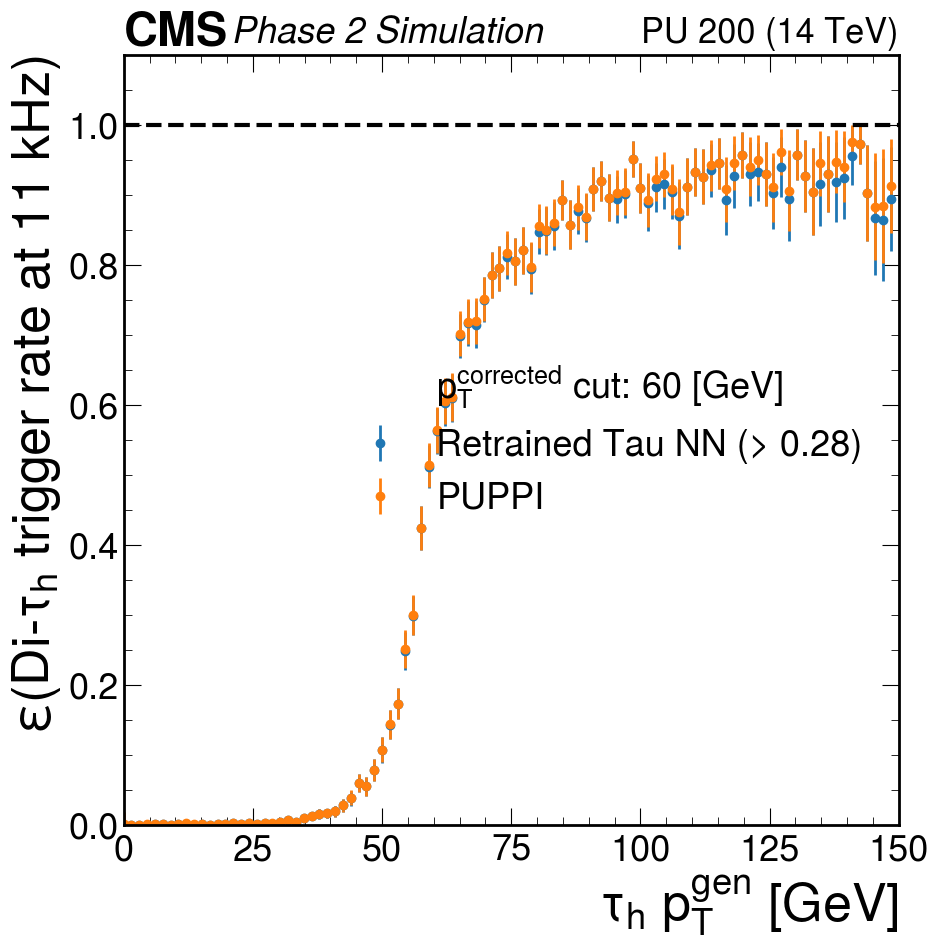

[0.00000000e+00 8.27538798e-02 0.00000000e+00 0.00000000e+00
 1.59139086e-01 5.47566205e-02 1.49940416e-03 5.00104067e-03
 7.28154400e-03 3.57764808e-04 2.31909553e-03 2.24061706e-04
 8.31529395e-04 2.84679500e-03 3.20105005e-03 5.96257833e-04
 3.41719034e-03 1.03687817e-03 2.59155137e-03 2.04166310e-03
 5.37314792e-03 8.04211825e-03 5.85962511e-03 1.28886012e-02
 1.59069095e-02 1.91879082e-02 1.94027354e-02 2.31046370e-02
 3.26134822e-02 4.48551769e-02 7.04174698e-02 6.32619944e-02
 9.04092107e-02 1.22257171e-01 1.61360322e-01 1.93486673e-01
 2.74833389e-01 3.34302726e-01 4.74538682e-01 5.57840277e-01
 6.20947021e-01 6.60801395e-01 6.75353971e-01 7.72109182e-01
 7.77395402e-01 7.90361171e-01 8.04422127e-01 8.42910370e-01
 8.56661067e-01 8.79047236e-01 8.57548343e-01 8.87118088e-01
 8.63783052e-01 9.15640565e-01 9.24938260e-01 9.02797748e-01
 9.53201590e-01 9.11048794e-01 9.52506678e-01 9.29194288e-01
 9.48555638e-01 9.61172294e-01 9.34976388e-01 9.52034792e-01
 9.40476723e-01 9.834076

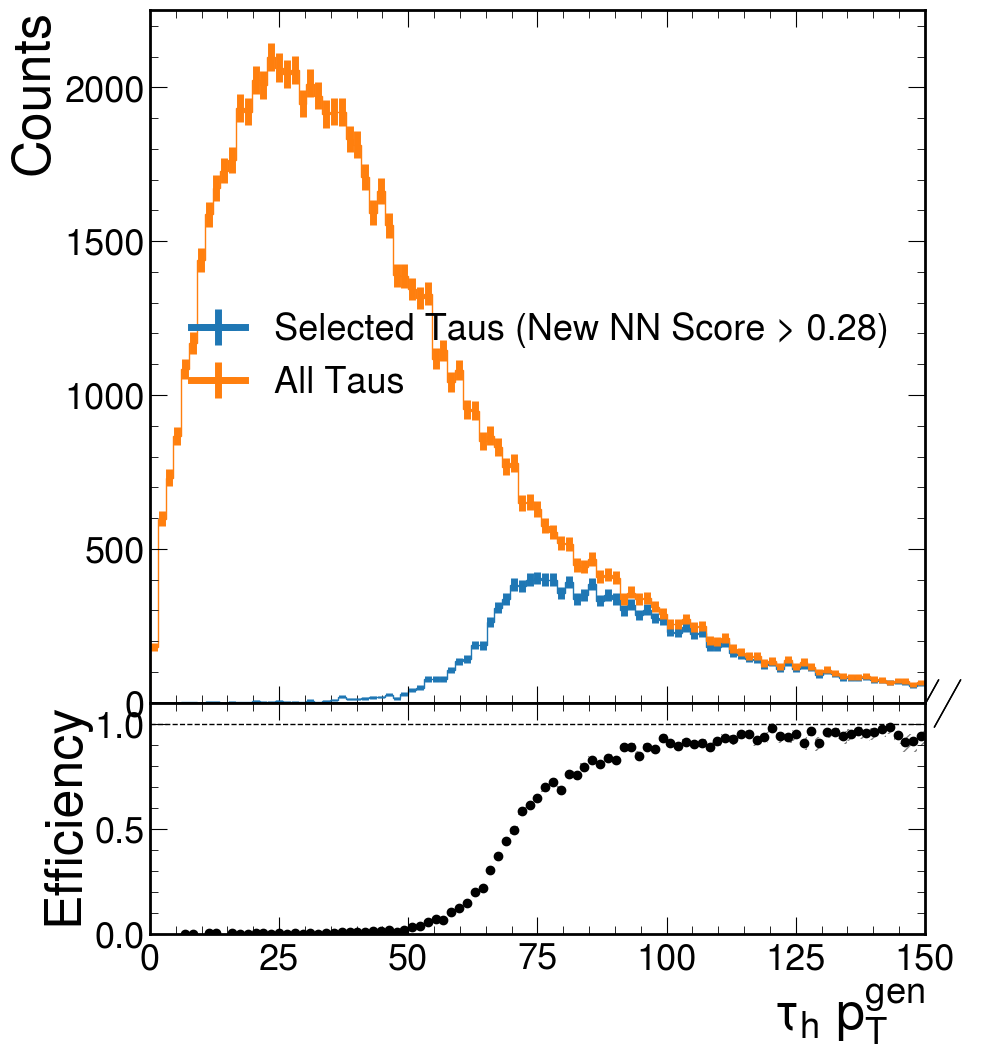

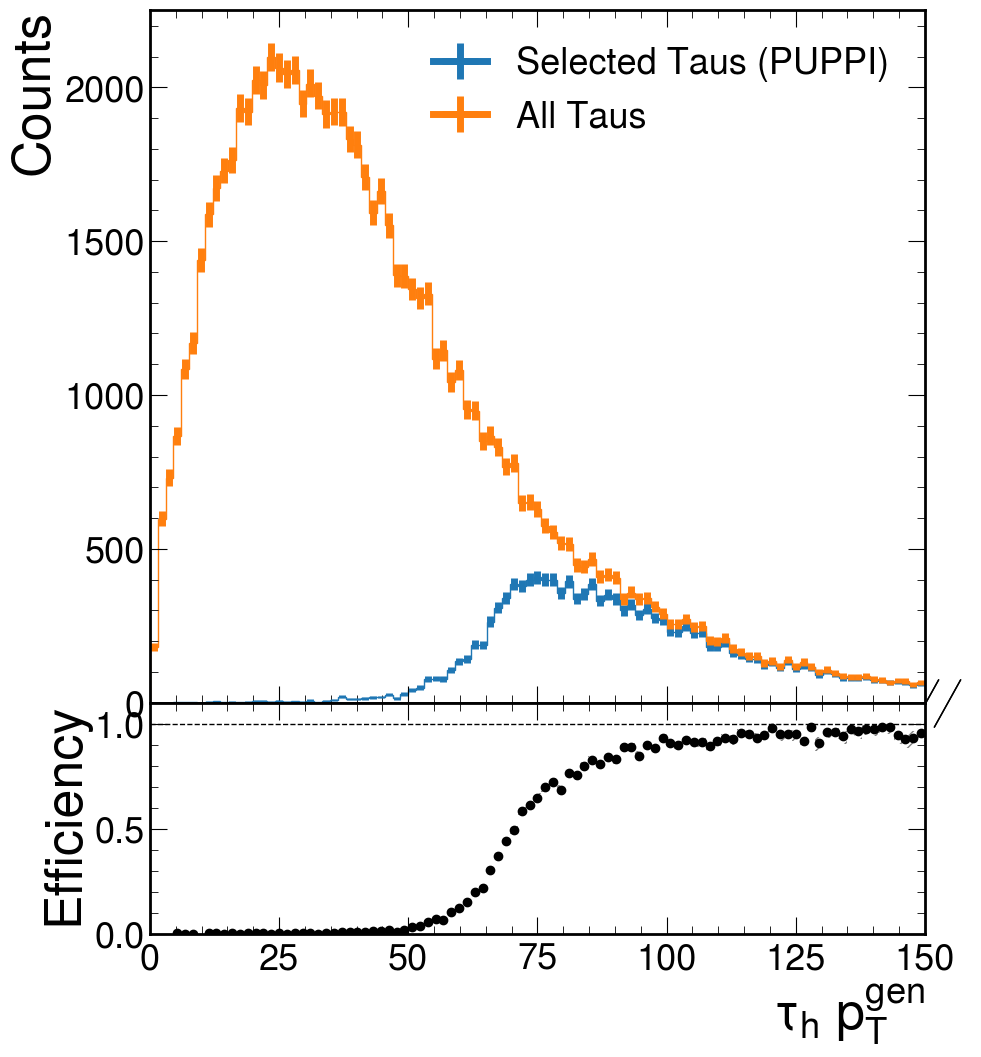

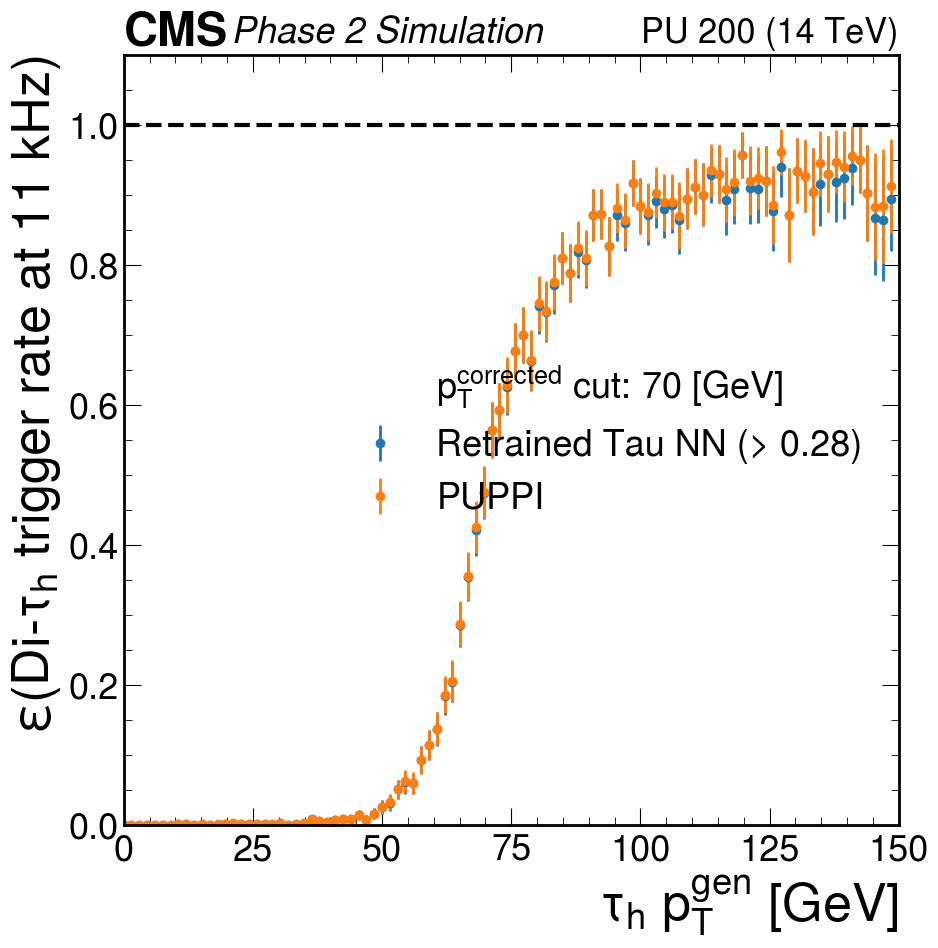

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.00992853e-02 1.33545971e-02 0.00000000e+00 2.58999171e-03
 3.50470684e-03 0.00000000e+00 1.20105062e-03 2.24061706e-04
 2.02817588e-04 2.84679500e-03 1.20880707e-03 5.96257833e-04
 2.19640547e-03 5.37002322e-04 9.78647566e-04 1.24135865e-04
 3.06905532e-03 1.15278114e-04 1.93805285e-03 4.07731687e-03
 9.87252852e-03 5.83784533e-03 5.15106501e-03 7.25647832e-03
 9.59132978e-03 9.87439142e-03 1.60107965e-02 8.58192554e-03
 1.83849941e-02 2.88320998e-02 3.53878987e-02 5.68539631e-02
 6.67573618e-02 6.60098865e-02 1.03113255e-01 1.24122178e-01
 1.50445858e-01 2.01870862e-01 2.25965292e-01 3.16231113e-01
 3.84078761e-01 4.65609268e-01 5.08684393e-01 6.04630155e-01
 6.38047247e-01 6.76686089e-01 7.20723105e-01 7.56816410e-01
 7.20128106e-01 8.00685006e-01 7.98562958e-01 8.13389177e-01
 8.64269224e-01 8.37976570e-01 8.89434884e-01 8.65523364e-01
 9.08665785e-01 9.11006347e-01 8.62441007e-01 9.28507632e-01
 8.97316847e-01 9.474757

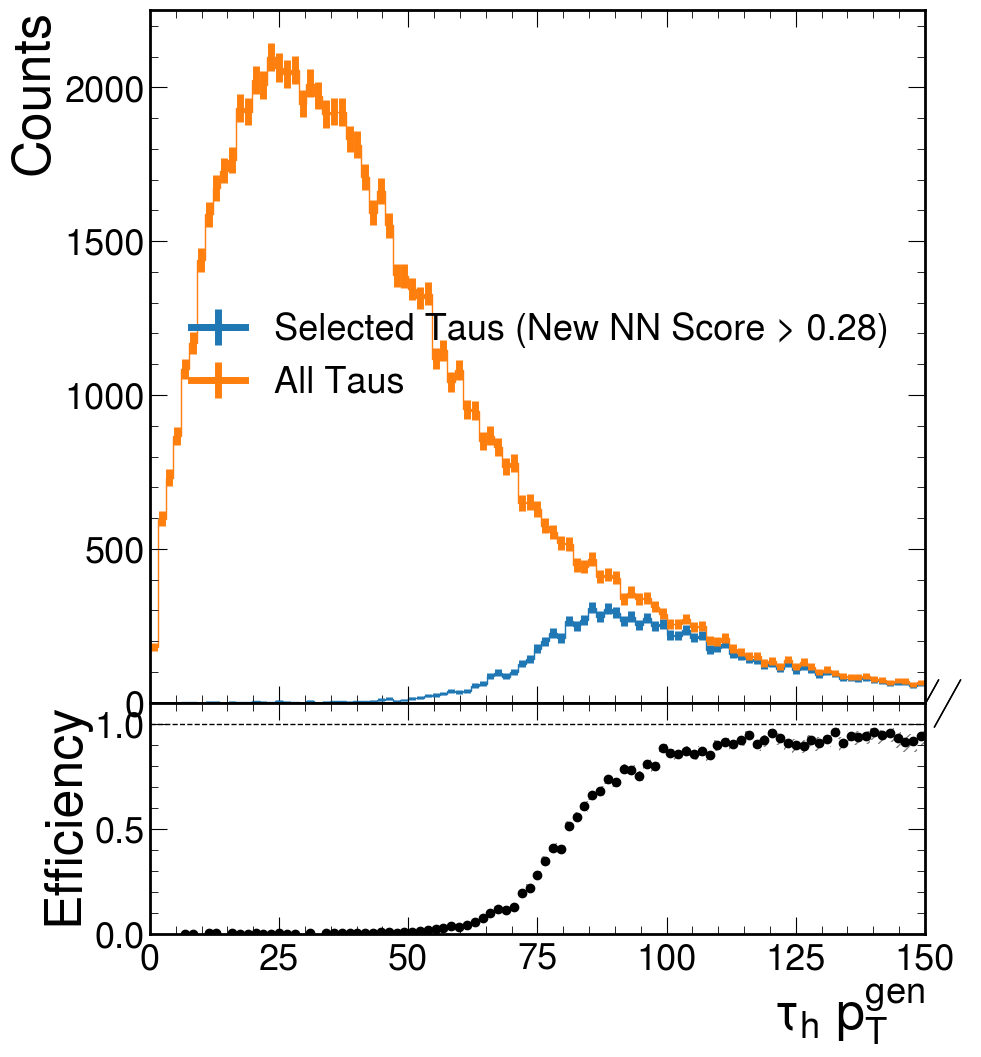

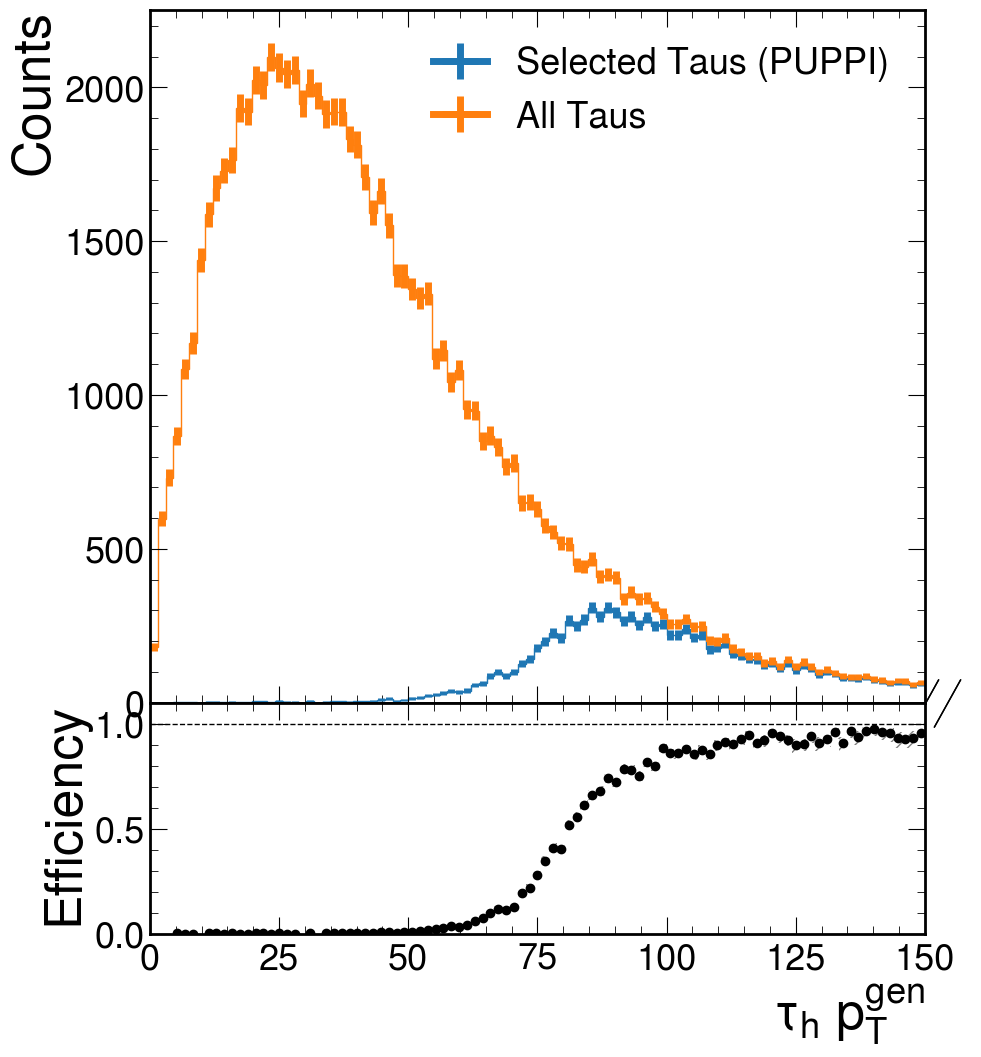

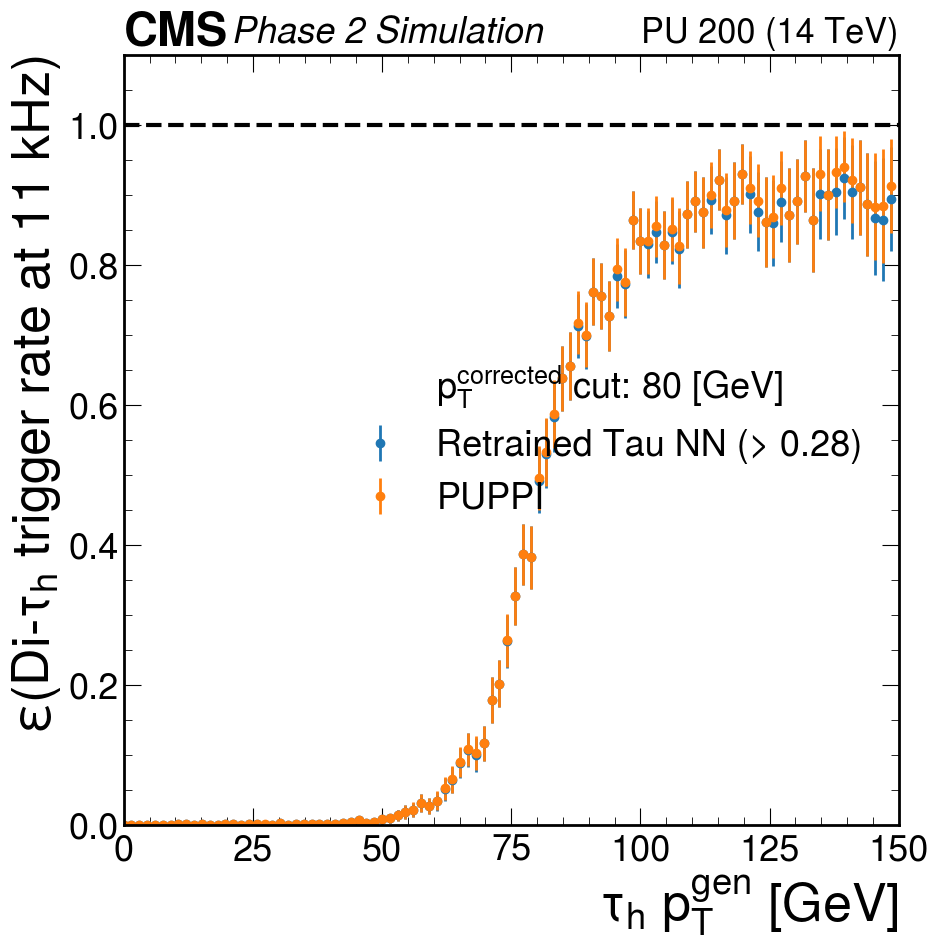

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.00992853e-02 1.33545971e-02 0.00000000e+00 2.58999171e-03
 1.81506448e-03 0.00000000e+00 1.20105062e-03 2.24061706e-04
 2.02817588e-04 2.09029677e-03 6.26043823e-04 1.45434206e-04
 2.19640547e-03 5.37002322e-04 1.23625041e-04 0.00000000e+00
 2.51432815e-03 0.00000000e+00 9.32829947e-04 1.40370868e-03
 1.40177796e-03 9.29343200e-04 1.38851525e-03 1.46810667e-03
 2.68641570e-03 4.93037355e-03 7.21741421e-03 2.36441773e-03
 4.40091543e-03 8.80600759e-03 1.03577604e-02 1.53845053e-02
 1.98374768e-02 2.31572939e-02 3.42519982e-02 2.94307664e-02
 3.70004902e-02 5.52417013e-02 7.07128080e-02 9.82641698e-02
 1.15863340e-01 1.09928395e-01 1.24646845e-01 1.91287679e-01
 2.17001019e-01 2.83671089e-01 3.47594619e-01 4.17805841e-01
 4.15721963e-01 5.31236059e-01 5.78409379e-01 6.13938137e-01
 6.81122450e-01 6.97072638e-01 7.73556943e-01 7.48463945e-01
 7.95108674e-01 7.88977899e-01 7.59224741e-01 8.36060645e-01
 8.05778986e-01 8.933684

In [5]:
results = plot_pt_eff_puppi(model_name,
                            model_name,
                            '../../ntuples/Jan_25_2023/test_sig_v12_emseed.root',
                            corrected_pt_cut=0,
                            cut_point = 0.28)
no_cut_x = np.asarray(results[0])
no_cut_y = np.asarray(results[1])


threshold_list = [15, 20, 25,30,35,40,50,60,70,80]
gen_pT_list = []
for i in threshold_list:
    result = plot_pt_eff_puppi(model_name,
                            model_name,
                            '../../ntuples/Jan_25_2023/test_sig_v12_emseed.root',
                            corrected_pt_cut=i,
                            cut_point = 0.28)
    cut_x = np.asarray(result[0])
    cut_y = np.asarray(result[1])
    y_norm = np.divide(cut_y, no_cut_y)
    print(y_norm)
    for i in range(10):
        if y_norm[i] == 1:
            y_norm[i] = 0
        else:
            break
    gen_pT_list.append(cut_x[y_norm > 0.95][0])
#gen_pT_list = [cut(i) for i in threshold_list]
gen_pT_list_nn = gen_pT_list


1905/1905 [==============================] - 2s 940us/step


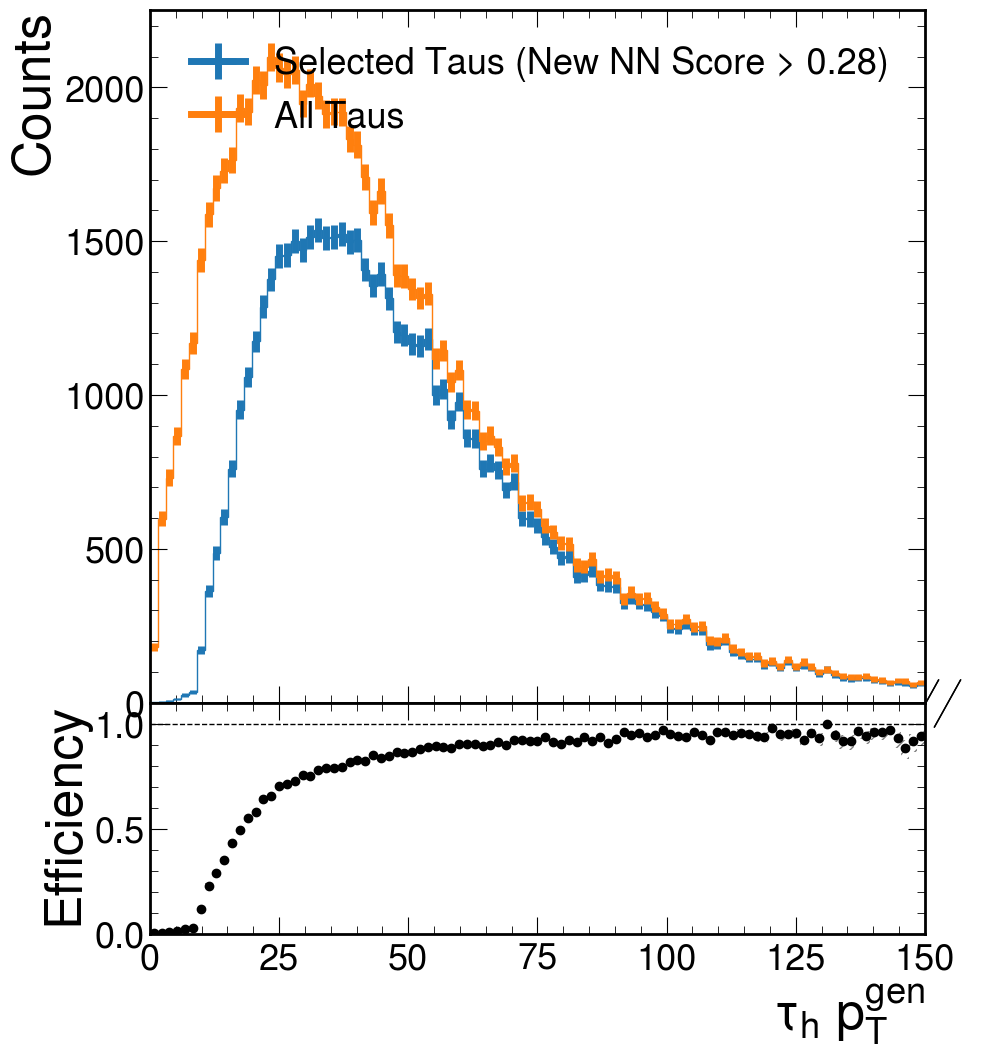

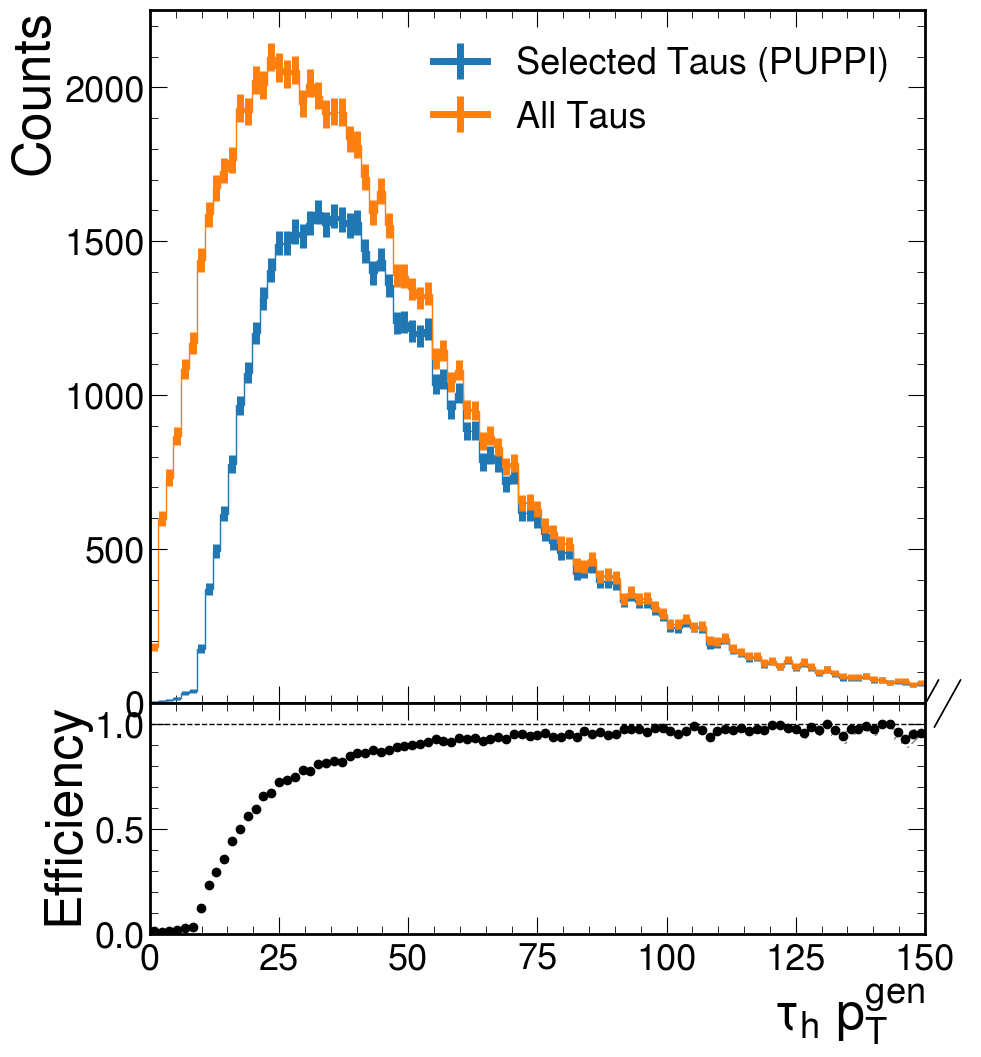

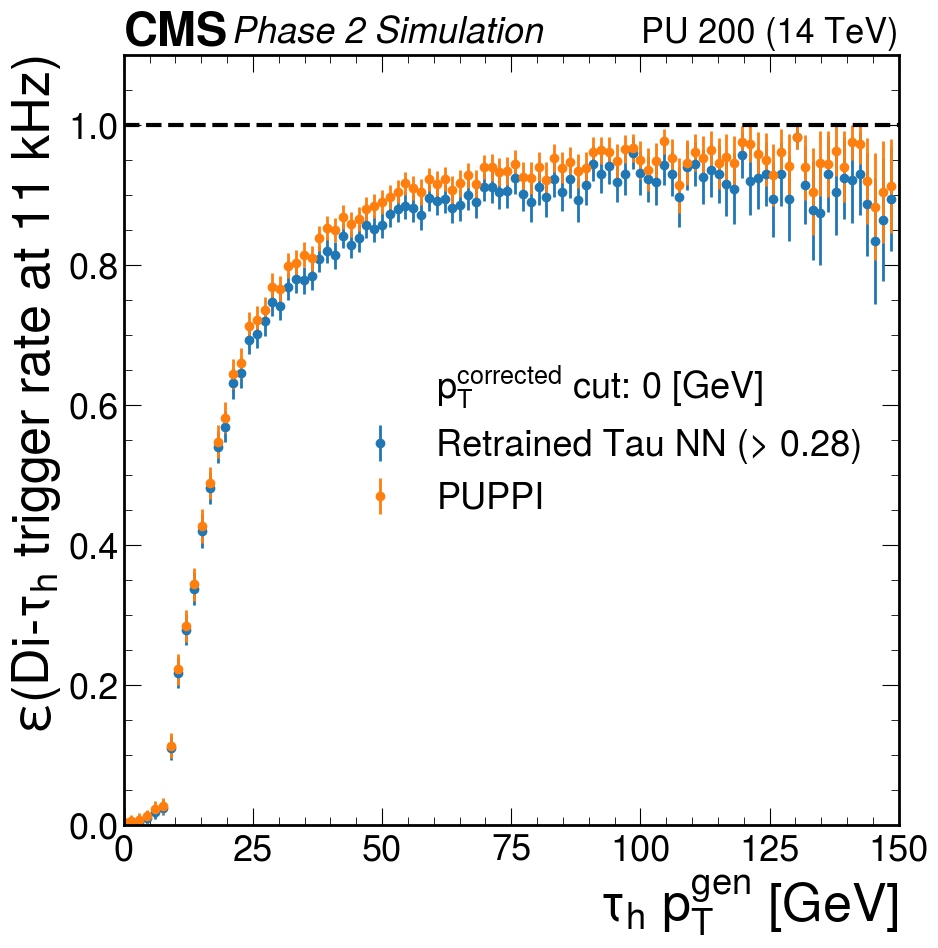

1743/1743 [==============================] - 2s 976us/step


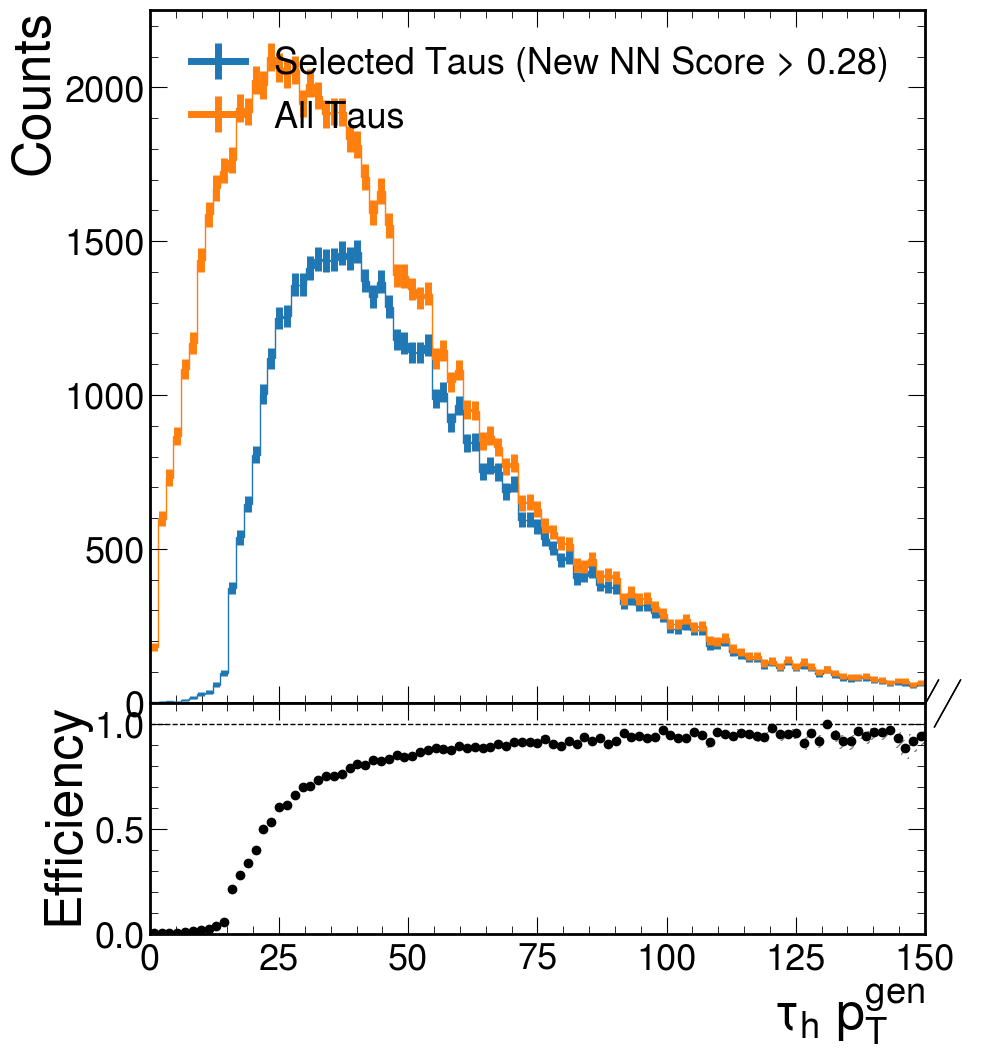

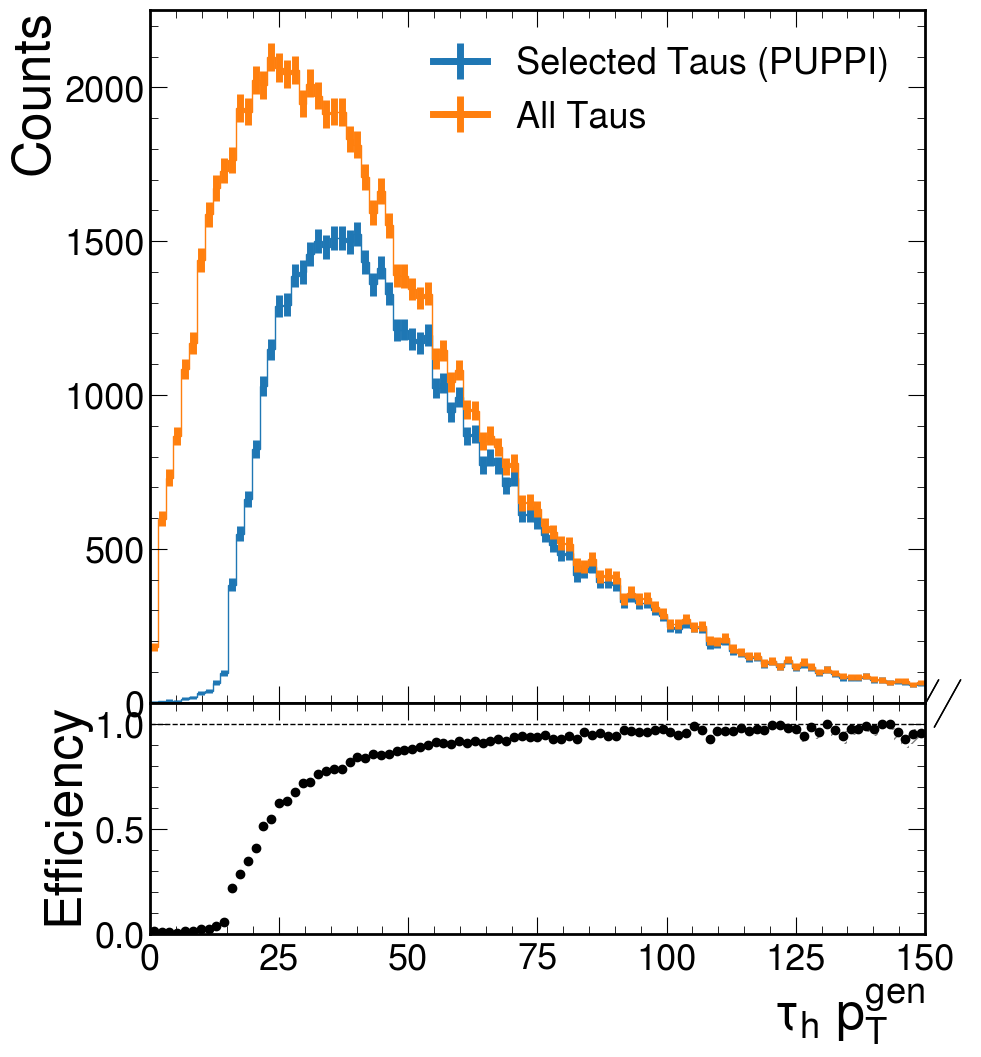

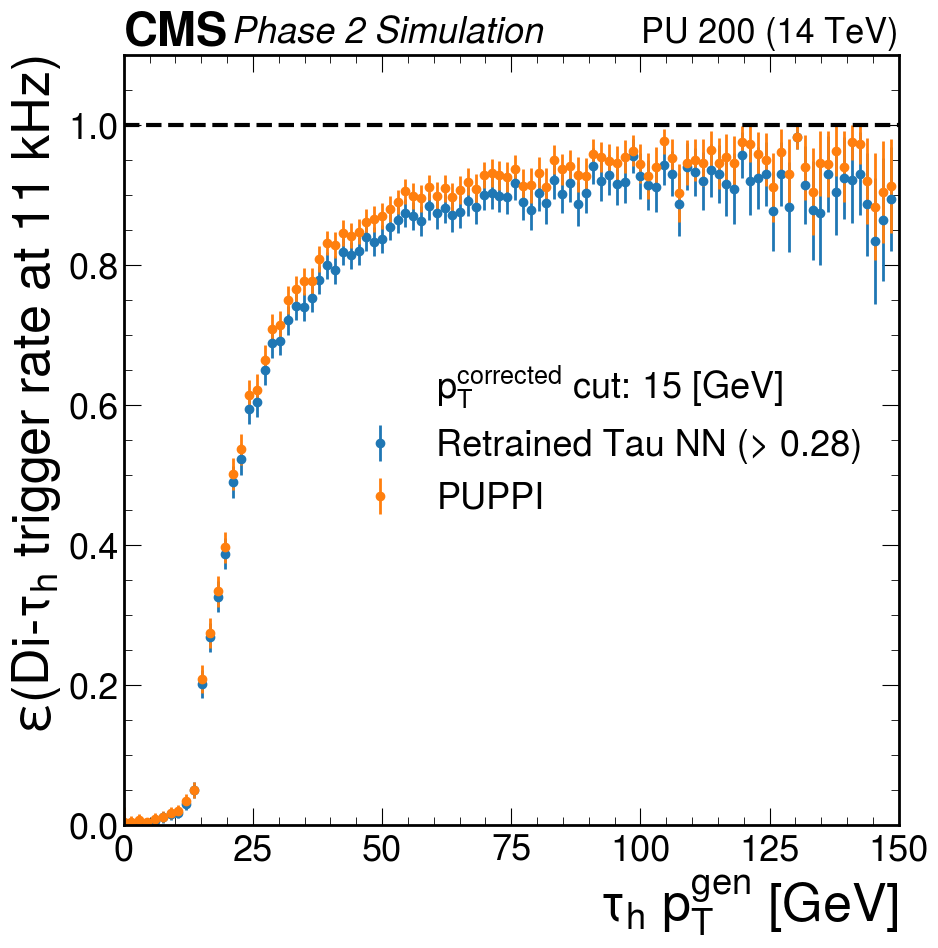

[1.         0.5177983  0.73418389 0.15910602 0.31622655 0.42671831
 0.13870902 0.07918877 0.1083452  0.14667606 0.48075465 0.55623416
 0.60345026 0.68065746 0.77565383 0.80942149 0.85714783 0.86091398
 0.90444505 0.92133143 0.93224309 0.93723179 0.95100642 0.95110827
 0.95950562 0.96287633 0.97396526 0.97362209 0.97252711 0.98146564
 0.97874334 0.97930024 0.97826957 0.9768138  0.98023251 0.98322902
 0.9874272  0.98768769 0.98975291 0.98710939 0.98039848 0.98526373
 0.98751263 0.98915351 0.9901868  0.99233091 0.98813545 0.99105065
 0.99462349 0.99070247 0.99193335 0.98728663 0.98855978 0.99091136
 0.98939006 0.99735037 0.99746589 0.99427322 0.99426126 0.98839861
 0.99649288 0.99014149 0.986004   0.99650123 0.98858055 0.99583853
 0.99529509 0.99059704 0.99116905 1.         1.         0.98788511
 1.         0.98845033 0.9929863  1.         1.         1.
 1.         1.         1.         1.         1.         0.98104266
 1.         0.98723305 1.         1.         1.         1.
 1.        

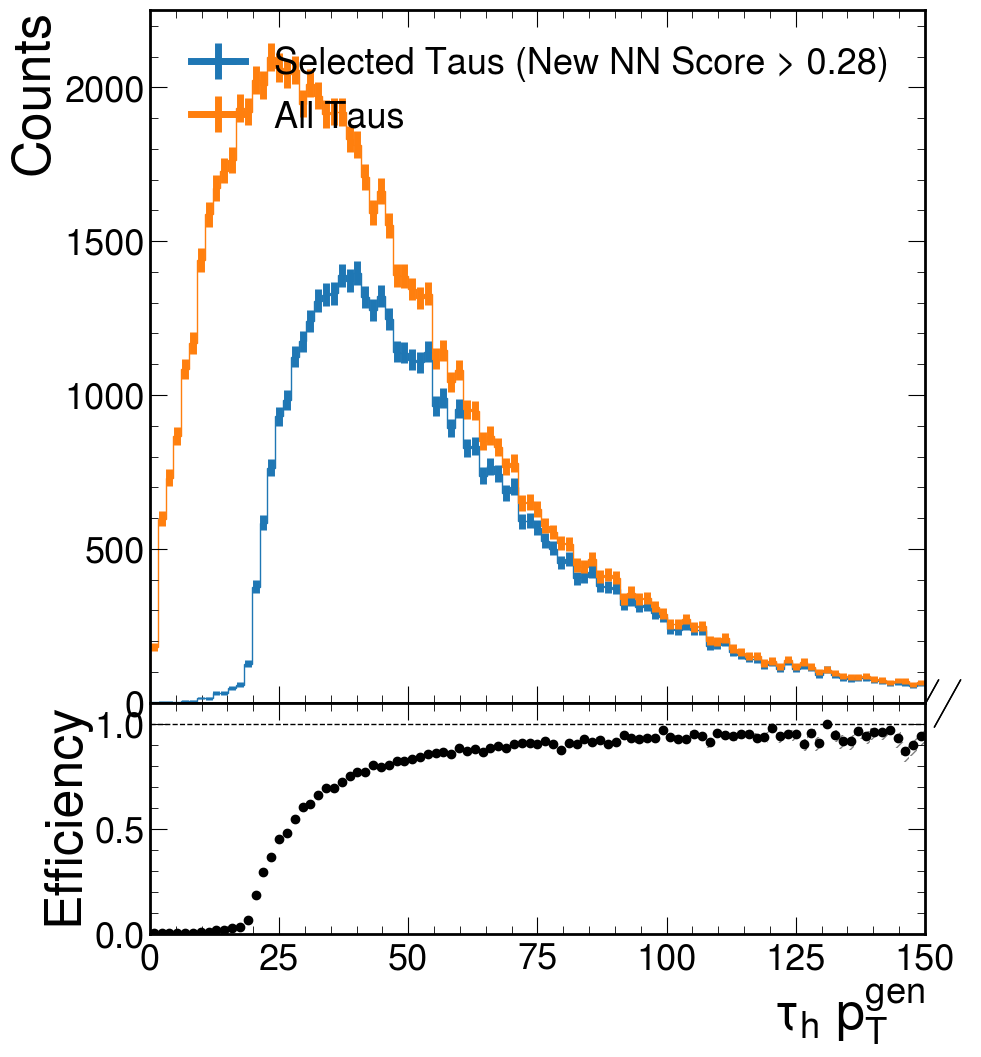

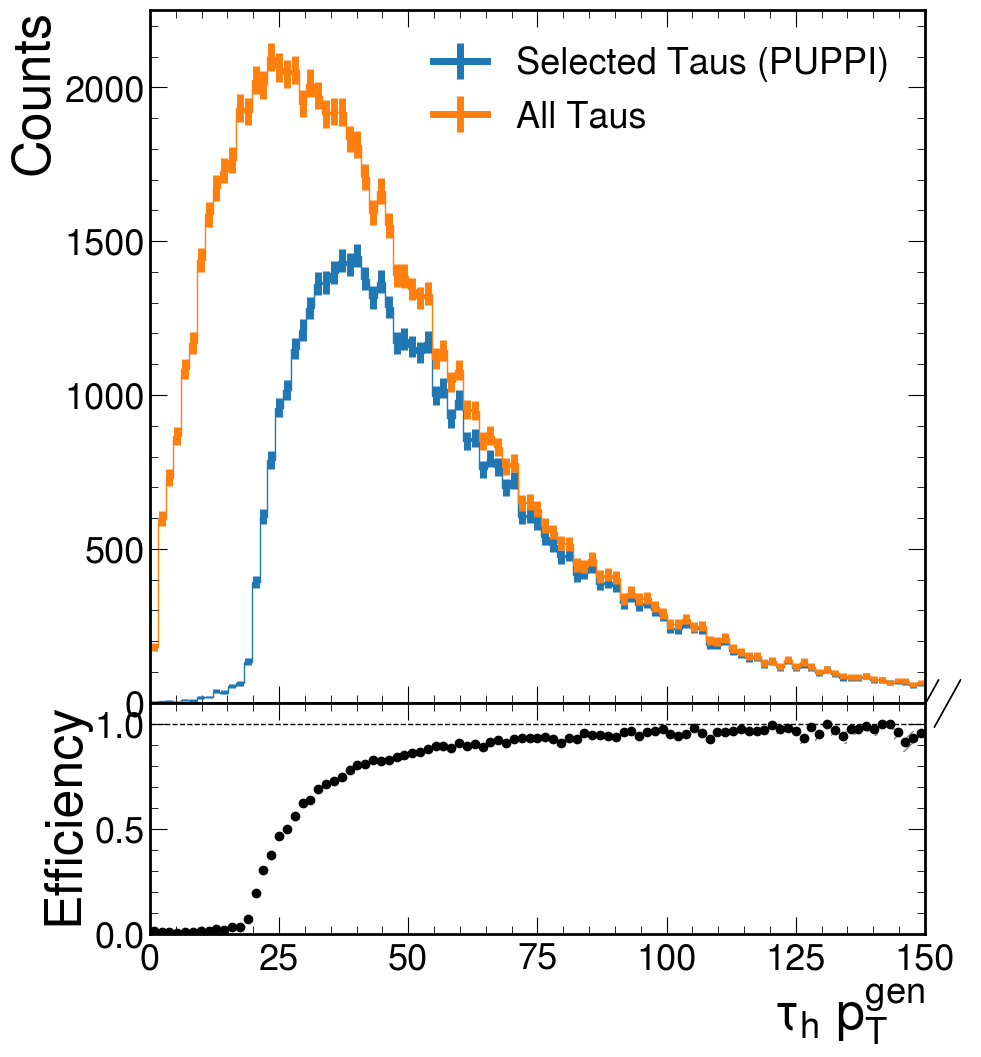

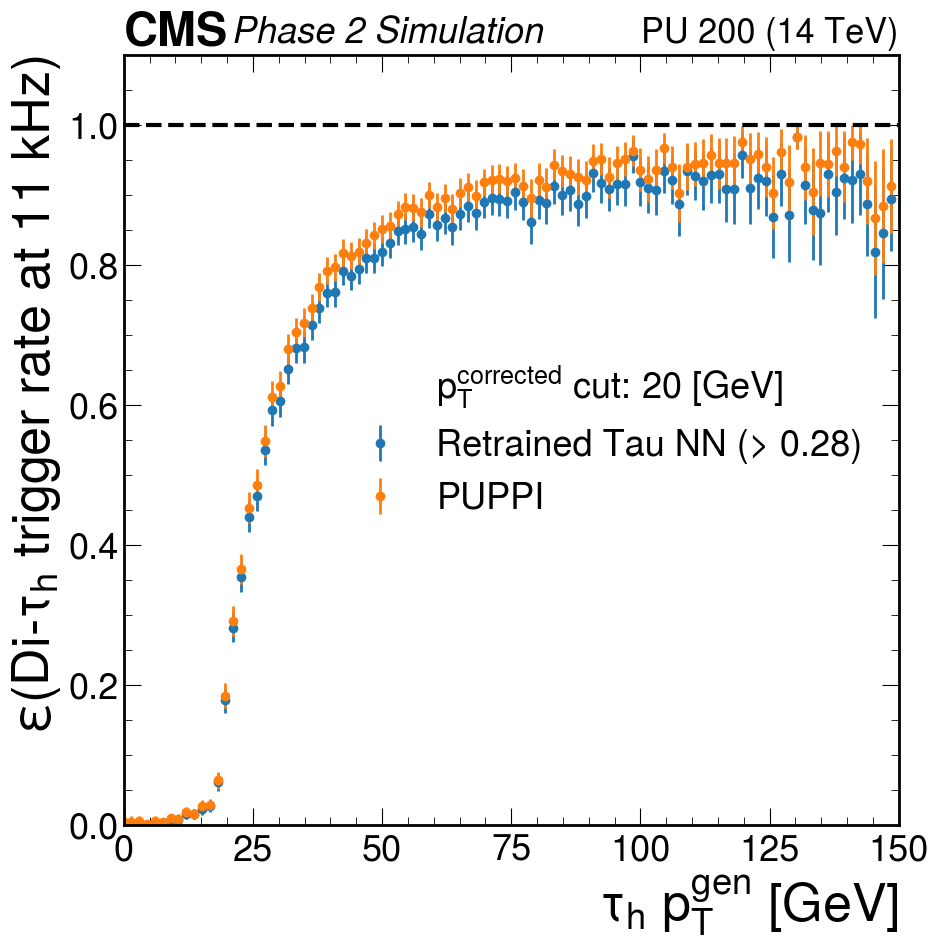

[1.         0.5177983  0.48121536 0.02009324 0.18896319 0.12819086
 0.07092525 0.02988478 0.05665289 0.0453095  0.05438923 0.05532855
 0.11206454 0.3121127  0.44617673 0.54788112 0.63468669 0.67019629
 0.74546643 0.79309687 0.81614391 0.84674992 0.87504441 0.87665306
 0.91036086 0.91351957 0.92613755 0.93488128 0.93980466 0.94670035
 0.94733003 0.94491093 0.95139725 0.95546822 0.95247023 0.96386415
 0.96236668 0.96926864 0.96817719 0.97532432 0.96209343 0.96935337
 0.96815081 0.98644598 0.98179628 0.98314731 0.97631565 0.98213045
 0.98925677 0.9851381  0.97789011 0.98728663 0.96806209 0.9795976
 0.98939006 0.98942597 0.99493449 0.98287552 0.99426126 0.98262216
 0.98604853 0.98687037 0.96529832 0.99650123 0.98479544 0.99583853
 0.98594472 0.98592007 0.98677333 0.99028186 0.99041153 0.98788511
 0.99380179 0.98273697 0.9929863  0.99242102 1.         0.99184982
 1.         1.         0.98931622 1.         0.98919063 0.97164876
 1.         0.97459075 1.         1.         1.         1.
 1. 

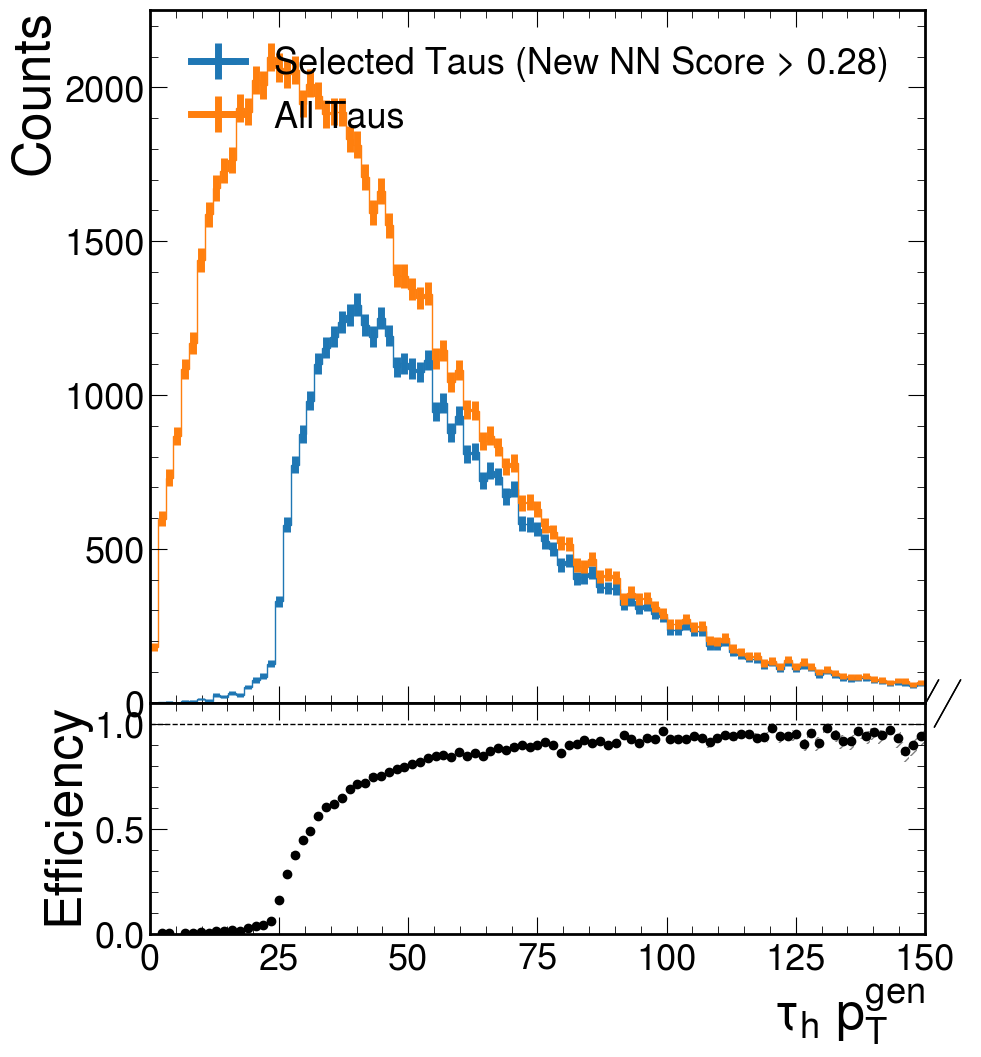

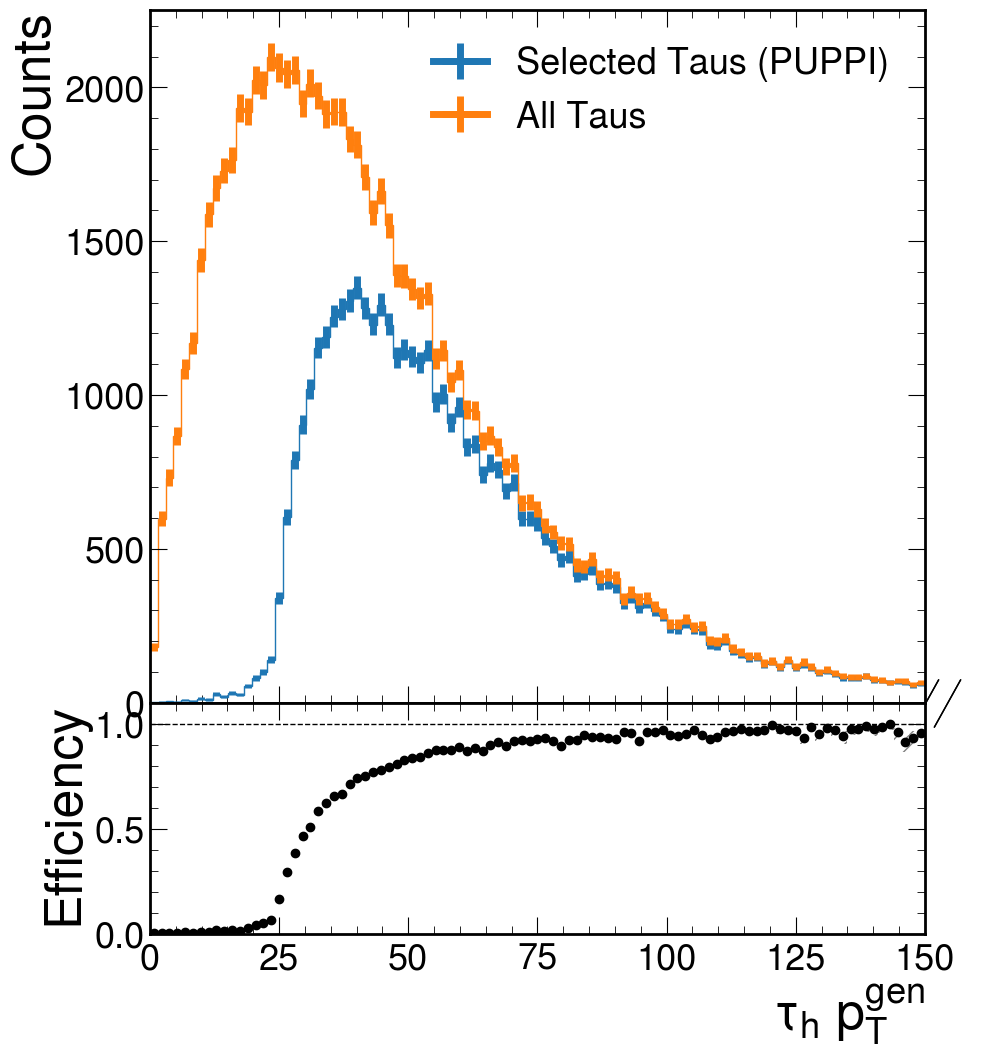

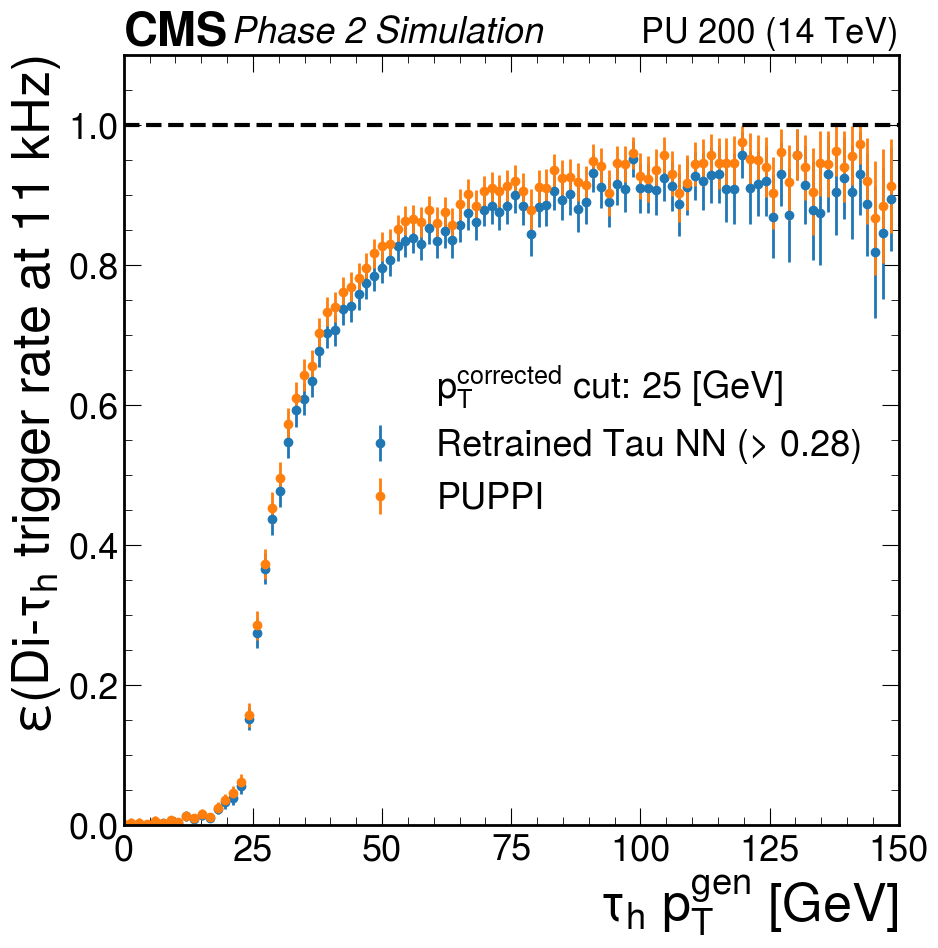

[0.         0.1262619  0.24918539 0.         0.18896319 0.12819086
 0.04909822 0.0128112  0.04302673 0.02521074 0.03323254 0.02060658
 0.04153959 0.05611162 0.0600495  0.08572306 0.21825406 0.38942025
 0.50852721 0.58501554 0.64221612 0.71163556 0.75955223 0.78224428
 0.80906621 0.8370089  0.85669716 0.86785558 0.87460565 0.8936133
 0.90504804 0.9029392  0.92114125 0.92885266 0.92479797 0.94016594
 0.94259547 0.9519204  0.95232307 0.9518309  0.93656254 0.94861933
 0.94747932 0.96753456 0.97063567 0.9678834  0.96453449 0.96968513
 0.96965298 0.97773401 0.97389275 0.98095049 0.94992928 0.96832945
 0.98674407 0.98153473 0.98735568 0.97720145 0.98567562 0.97398436
 0.98604853 0.98034821 0.9448425  0.99650123 0.97725325 0.99170856
 0.97666287 0.98592007 0.98677333 0.98066707 0.98089955 0.98788511
 0.96943491 0.98273697 0.9929863  0.99242102 1.         0.99184982
 1.         1.         0.98931622 0.99110074 0.98919063 0.97164876
 1.         0.97459075 0.97379898 1.         1.         1.
 1. 

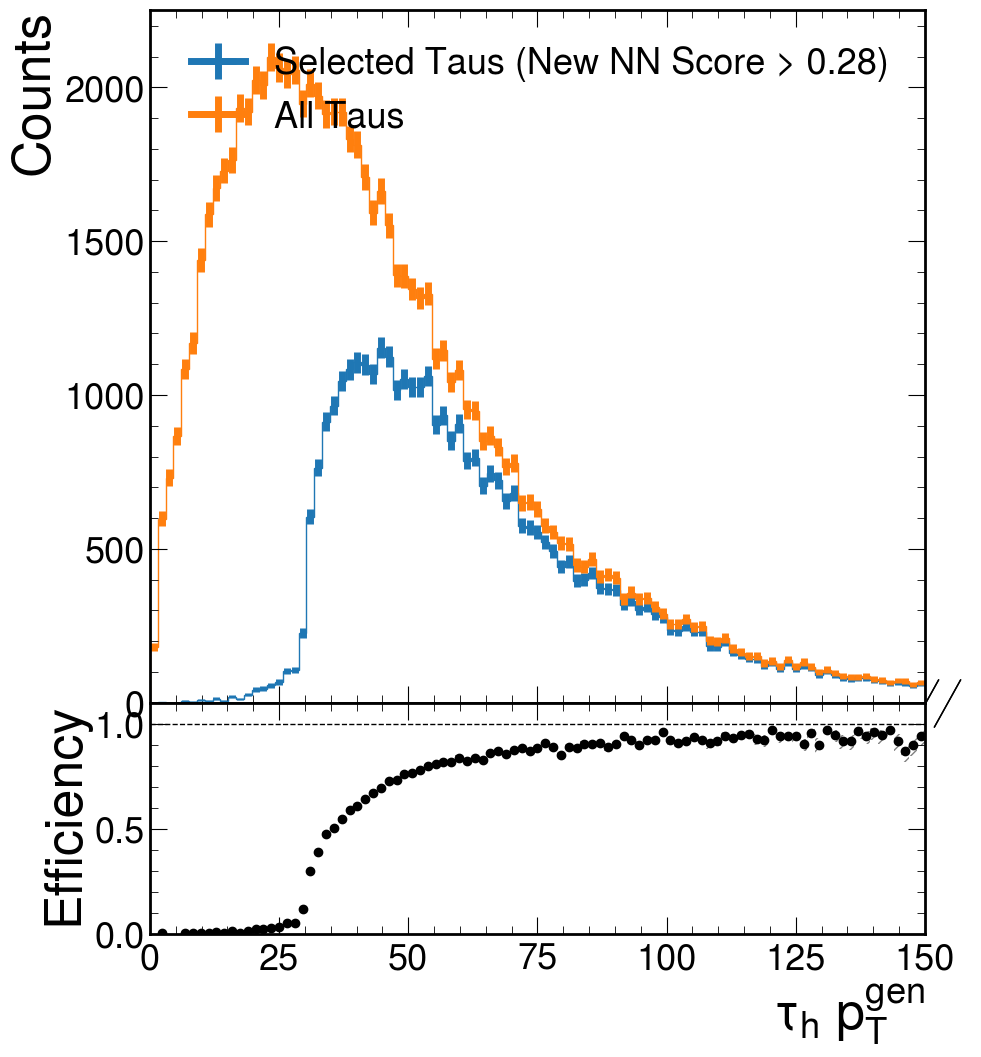

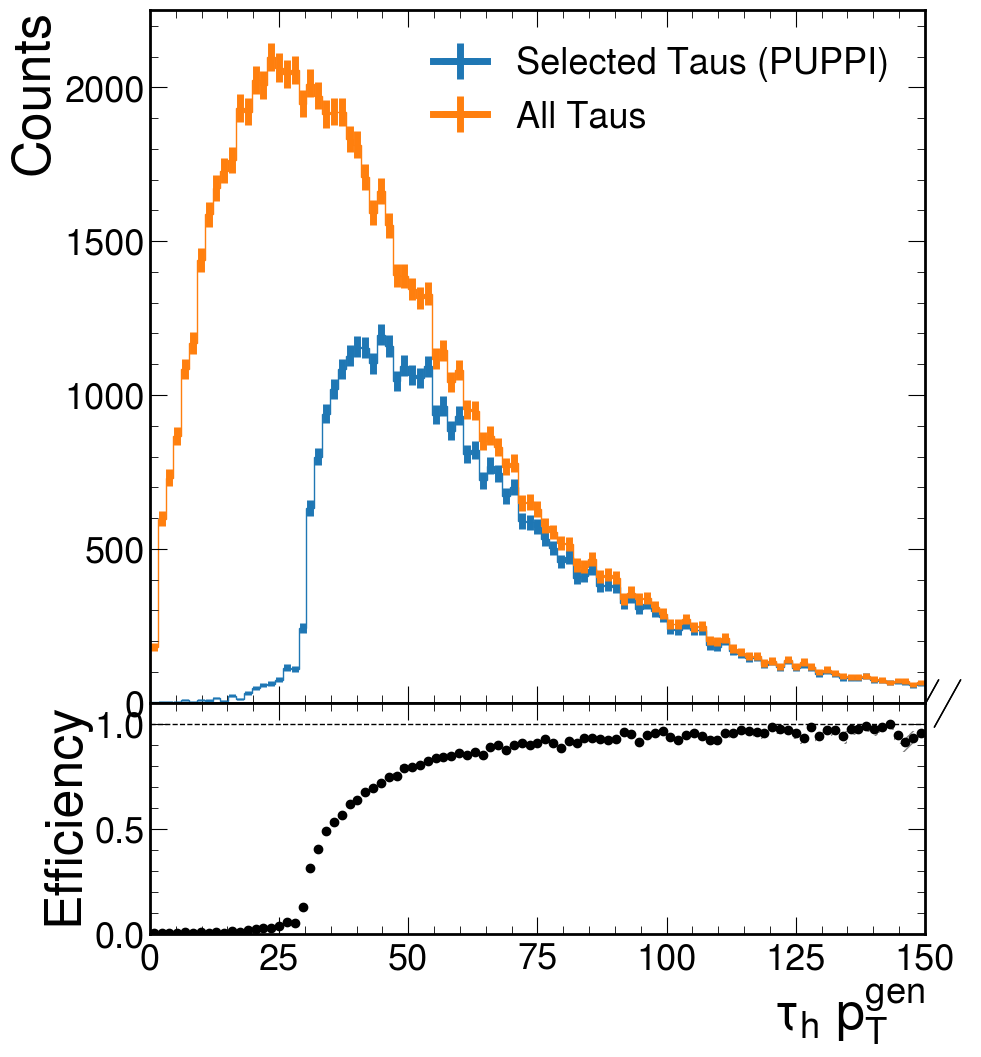

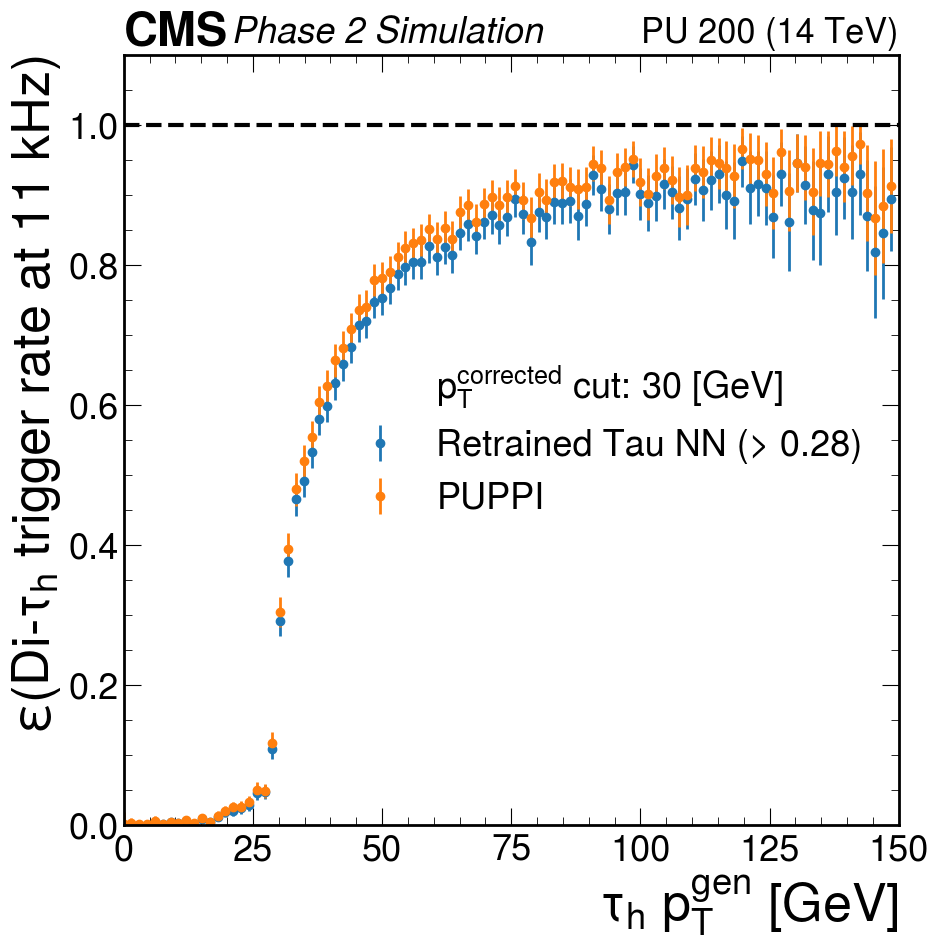

[0.         0.1262619  0.         0.         0.18896319 0.04840201
 0.0332046  0.00823417 0.02026876 0.00487483 0.02106149 0.0083256
 0.0202347  0.03091799 0.0310694  0.03591534 0.04119982 0.06491665
 0.06490688 0.14581252 0.39155093 0.48918593 0.59696149 0.63122303
 0.68019504 0.71731679 0.7293305  0.77498978 0.78180824 0.8238282
 0.8519771  0.83981403 0.87718884 0.87757248 0.88032165 0.89469816
 0.90009878 0.91226717 0.92296442 0.92311489 0.91112603 0.92431451
 0.92413005 0.95541185 0.95394552 0.94659109 0.94546074 0.95551544
 0.94837989 0.95929088 0.96790787 0.96831462 0.93637633 0.96158807
 0.96828676 0.96323088 0.98231517 0.96589655 0.97426629 0.97111176
 0.98258943 0.97709647 0.93468742 0.98257955 0.97349507 0.98352731
 0.96743951 0.96273737 0.97801715 0.97113618 0.97145221 0.981858
 0.9514882  0.97705798 0.97909858 0.98491156 1.         0.98375692
 0.98065738 0.99051765 0.98931622 0.99110074 0.97852634 0.97164876
 1.         0.96205601 0.96184918 1.         1.         1.
 1.    

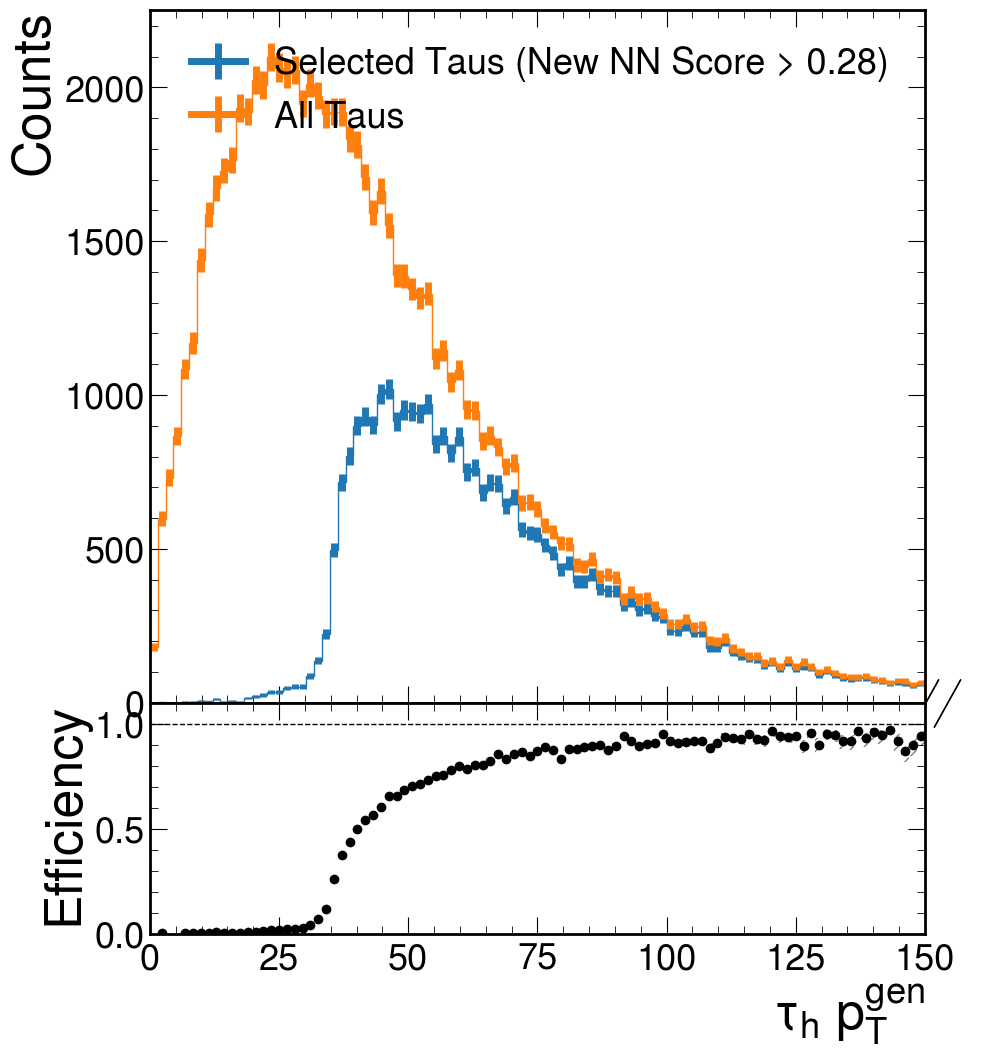

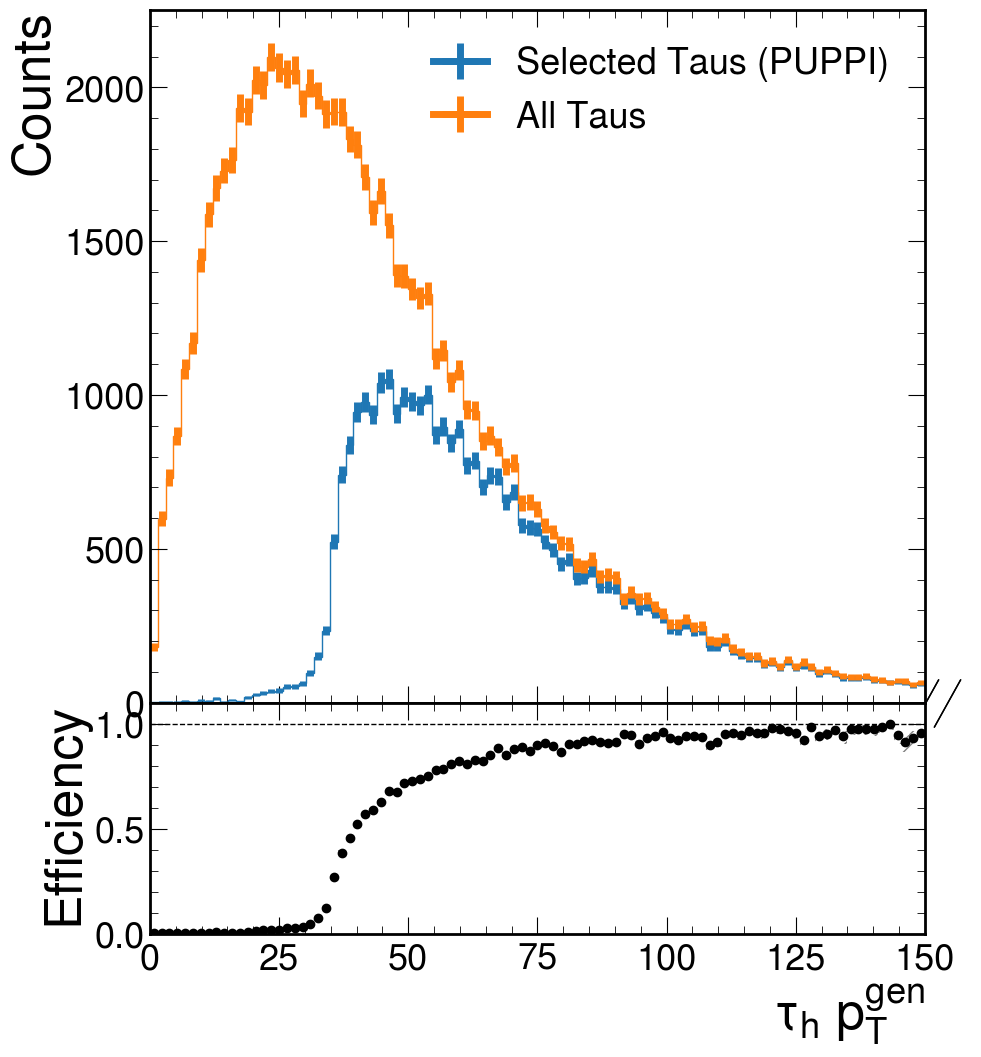

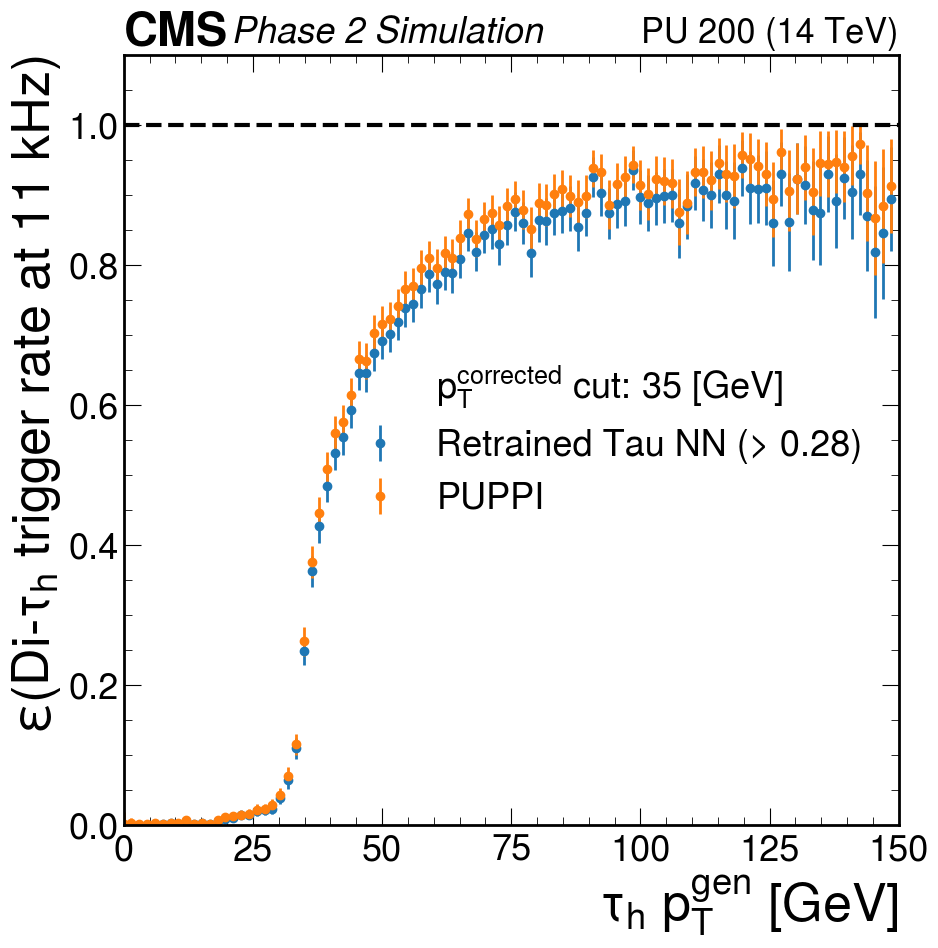

[0.         0.1262619  0.         0.         0.0713465  0.04840201
 0.02297315 0.00604595 0.018429   0.00121515 0.00489539 0.00147118
 0.01079397 0.0143054  0.01514282 0.02085596 0.01973431 0.02805567
 0.02973232 0.03090535 0.05218521 0.08221069 0.14014218 0.31914396
 0.46190149 0.52738081 0.59053854 0.65295567 0.6579912  0.71413505
 0.77034482 0.75237026 0.79053246 0.80627575 0.80418495 0.81642388
 0.83412445 0.84451953 0.87797888 0.87865014 0.86649802 0.88438324
 0.8940192  0.91382883 0.93869318 0.92083907 0.92500301 0.93435196
 0.91840542 0.94643074 0.9480438  0.95362742 0.91836083 0.94814459
 0.96040783 0.94764327 0.96975208 0.95464274 0.95722474 0.95679391
 0.97914017 0.97061015 0.92794044 0.96531682 0.95853808 0.97543192
 0.9628473  0.96273737 0.97365526 0.95227446 0.96674991 0.95792222
 0.93964039 0.97140961 0.97909858 0.96271157 1.         0.98375692
 0.98065738 0.98123713 0.98931622 0.98228443 0.97852634 0.962304
 1.         0.96205601 0.93891269 1.         1.         1.
 1.  

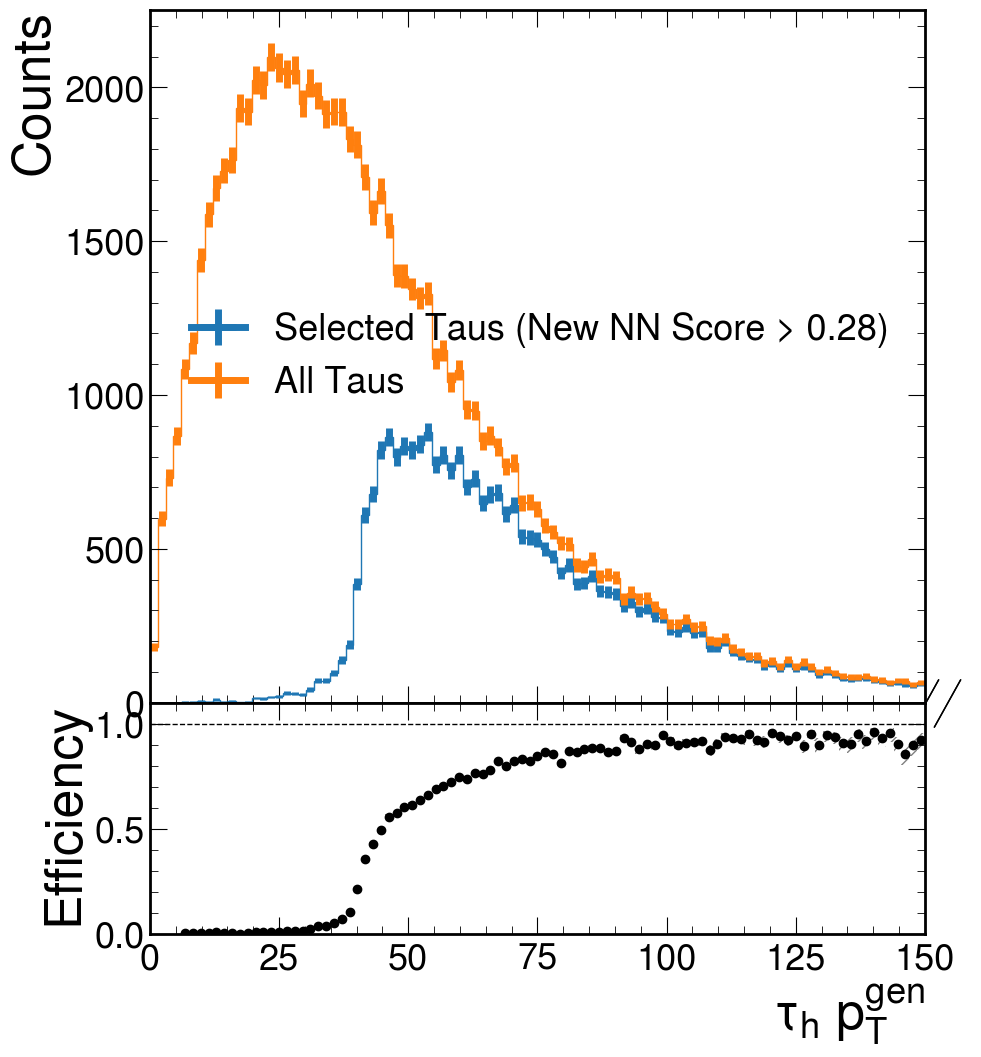

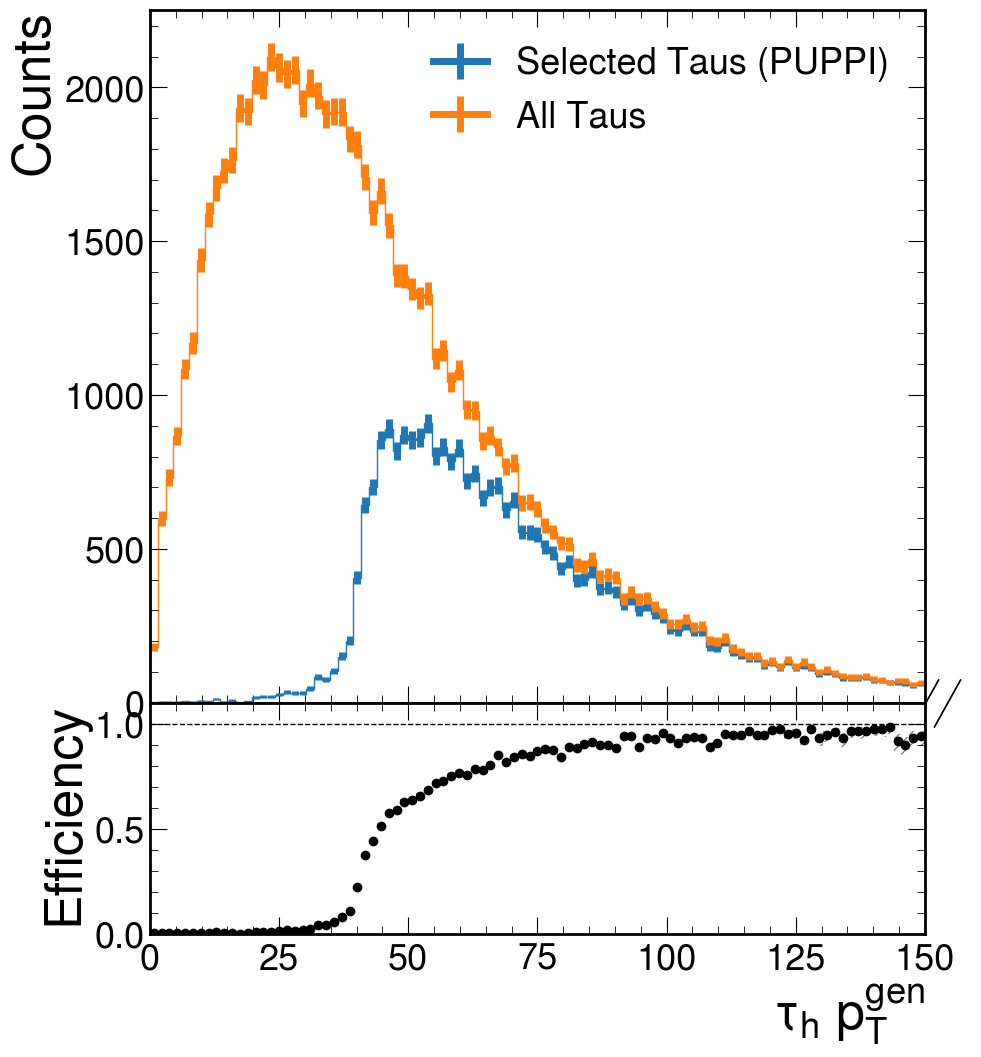

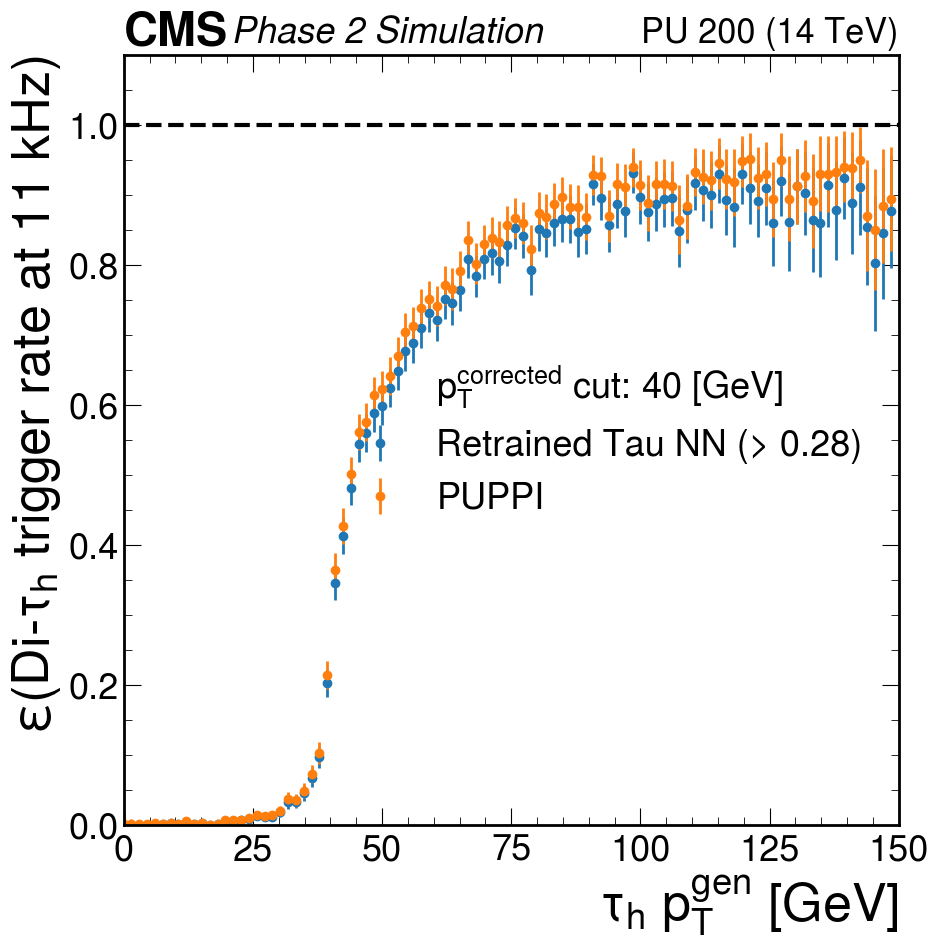

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 7.13464989e-02 4.84020054e-02 1.80233717e-02 2.05249583e-03
 1.47923228e-02 1.21515405e-03 4.89538983e-03 1.85840687e-04
 1.32043502e-03 9.71009305e-03 7.46897127e-03 1.02008202e-02
 1.15119435e-02 1.71433380e-02 1.60144375e-02 1.44294376e-02
 2.38585591e-02 4.13460279e-02 4.20814519e-02 5.78720058e-02
 8.48639502e-02 1.18874563e-01 2.47039558e-01 4.24227602e-01
 4.90215499e-01 5.81009653e-01 6.48884309e-01 6.53531049e-01
 6.90672755e-01 6.97707395e-01 7.16114694e-01 7.36837839e-01
 7.65427213e-01 7.81153704e-01 8.14183619e-01 8.16517955e-01
 8.08894069e-01 8.41021505e-01 8.44962700e-01 8.63151938e-01
 8.98661582e-01 8.81634611e-01 8.87196753e-01 8.95782595e-01
 8.92087238e-01 9.15342026e-01 9.22383876e-01 9.32733816e-01
 8.91441849e-01 9.34748144e-01 9.42087338e-01 9.32133261e-01
 9.57237937e-01 9.37844396e-01 9.48733112e-01 9.31185536e-01
 9.68845124e-01 9.64144987e-01 9.11144546e-01 9.65316823e-01
 9.43685624e-01 9.714111

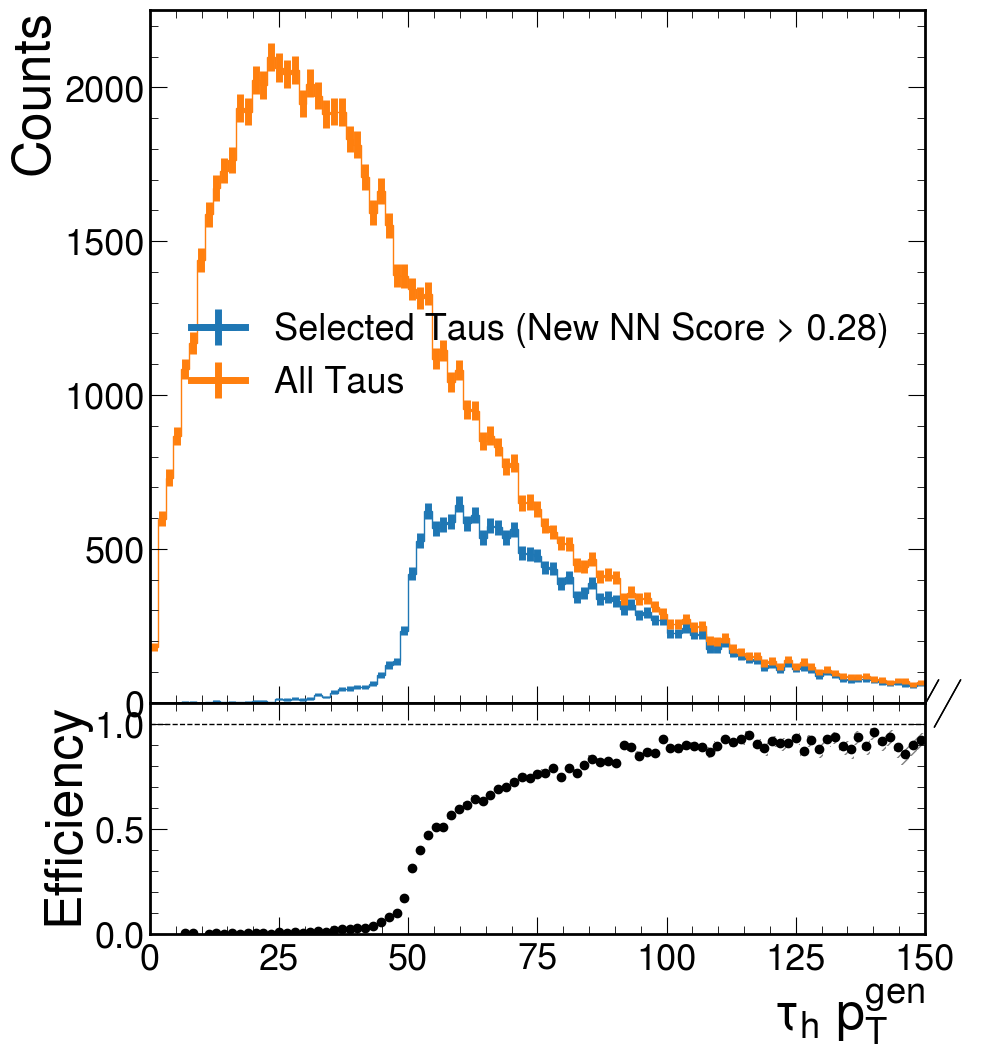

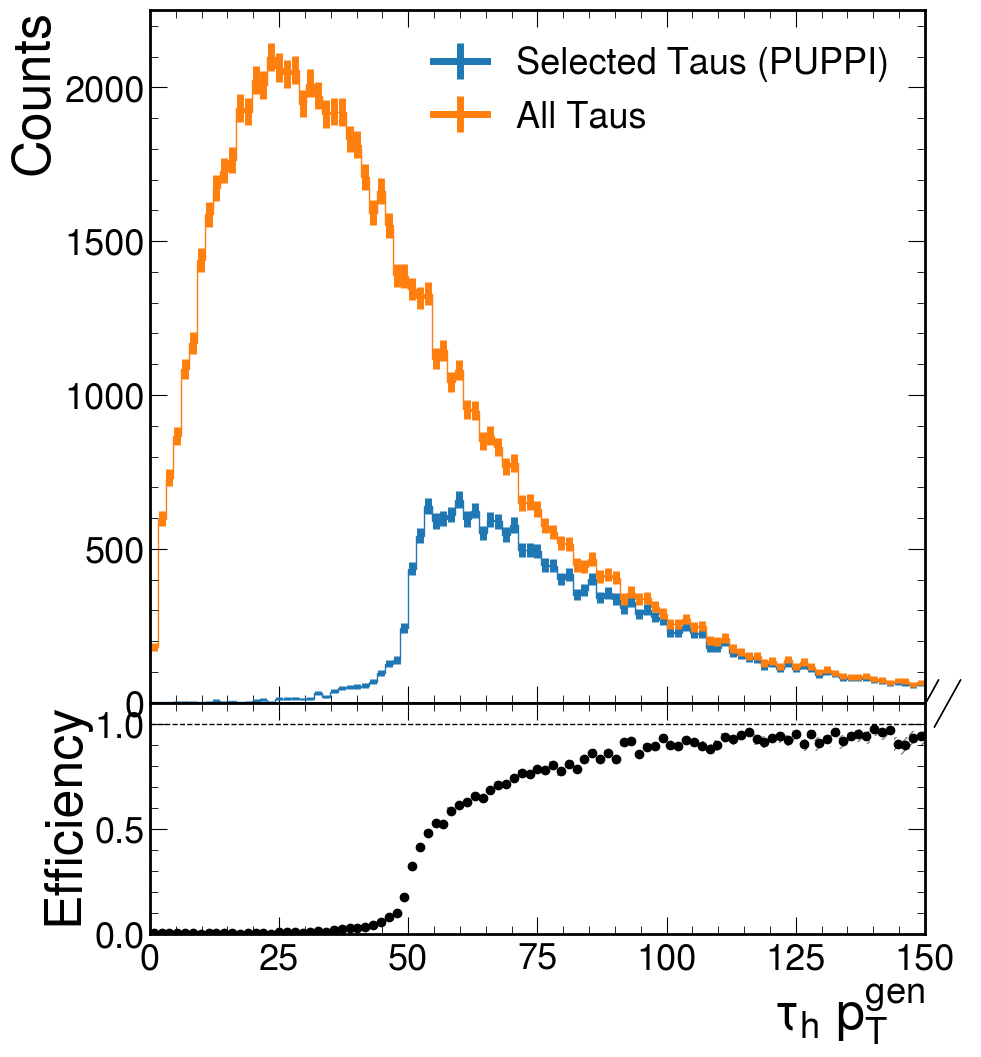

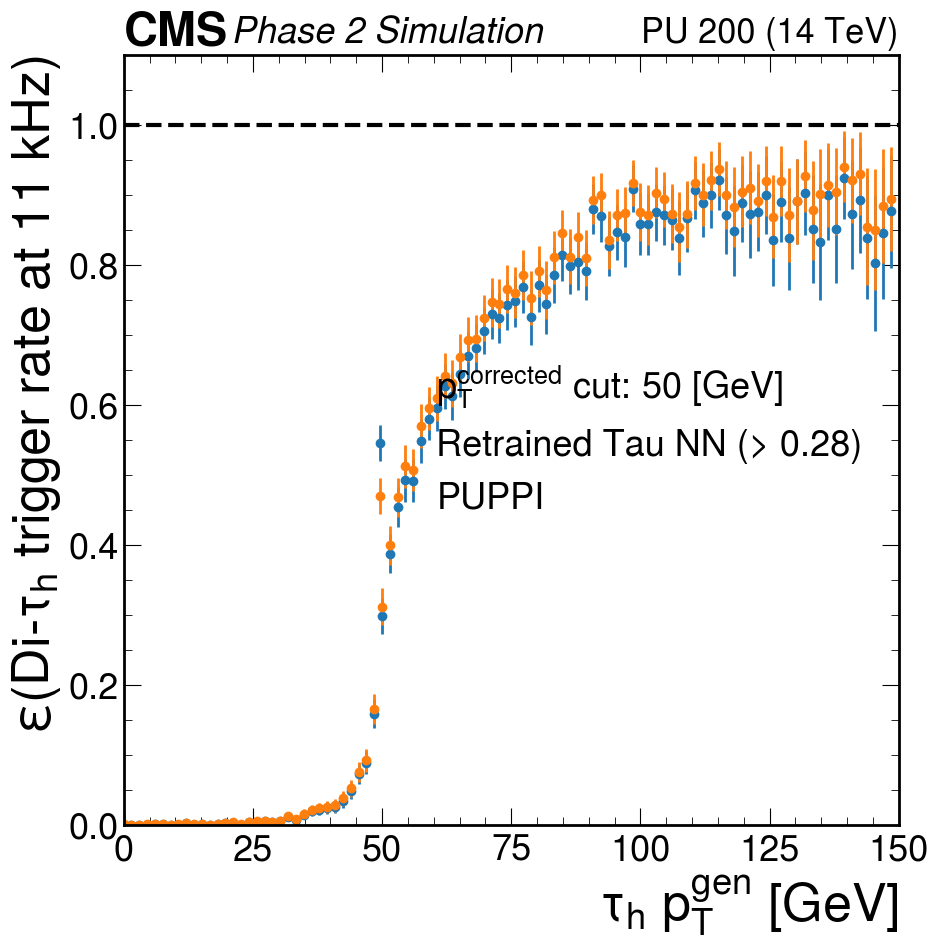

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.69478325e-02 2.50659736e-02 0.00000000e+00 5.00609698e-04
 7.76884972e-03 2.96383171e-04 1.84859034e-03 1.85840687e-04
 6.83853574e-04 3.14562445e-03 2.86296513e-03 1.27621602e-04
 6.00453377e-03 4.80876817e-03 6.39138964e-03 4.74765534e-03
 6.33259330e-03 1.38159457e-02 9.26537710e-03 1.82941803e-02
 2.42914133e-02 2.59363589e-02 2.89310830e-02 3.09474441e-02
 4.04983924e-02 5.86284258e-02 8.57117114e-02 1.03252626e-01
 1.86313682e-01 3.47957459e-01 4.43866178e-01 5.16289427e-01
 5.56004016e-01 5.57820568e-01 6.28850169e-01 6.48398480e-01
 6.68355157e-01 7.01175576e-01 6.94985958e-01 7.28287174e-01
 7.44392235e-01 7.66494305e-01 7.74831462e-01 8.00301647e-01
 8.01564657e-01 8.21179570e-01 8.09395881e-01 8.52000217e-01
 8.15723972e-01 8.46341076e-01 8.28417411e-01 8.50368163e-01
 9.00167718e-01 8.65900517e-01 9.00918443e-01 8.66457538e-01
 9.31611798e-01 9.35270929e-01 8.77809921e-01 9.20969595e-01
 9.03257915e-01 9.475771

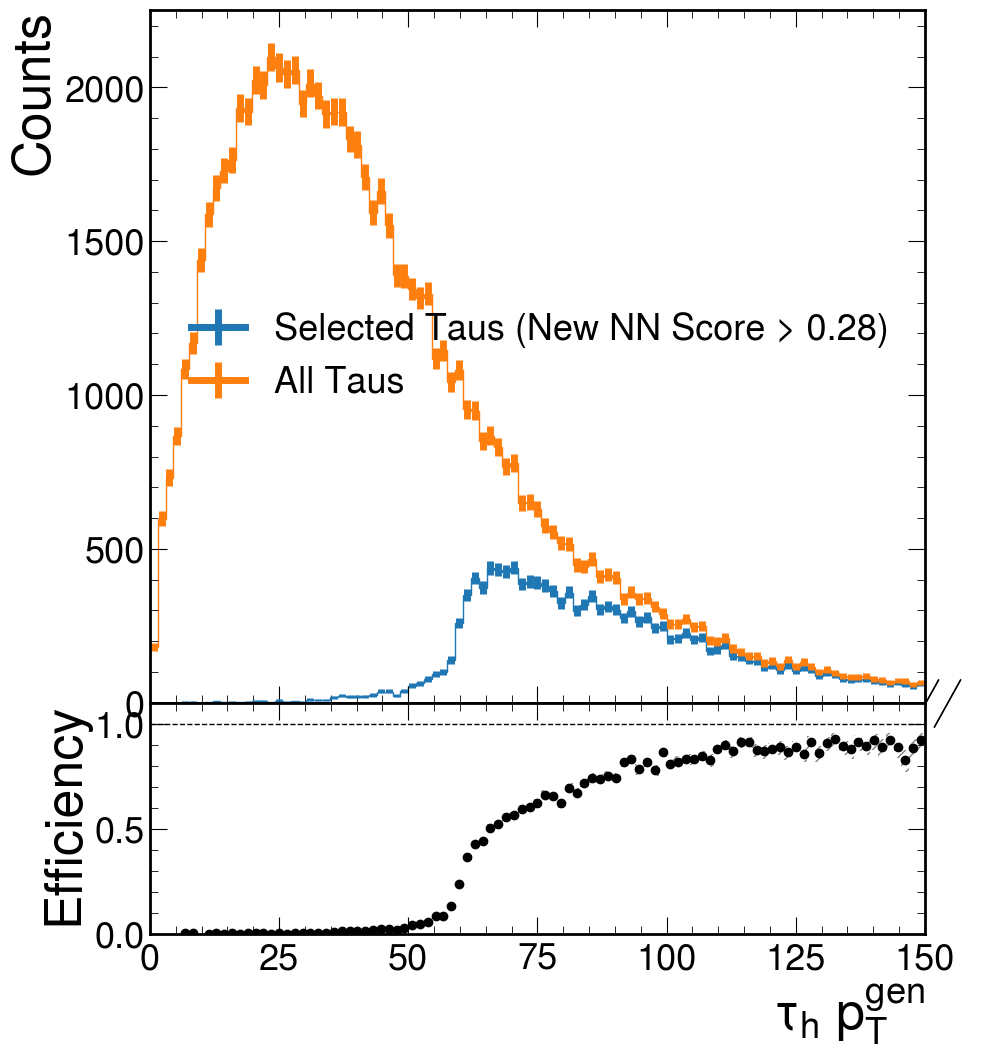

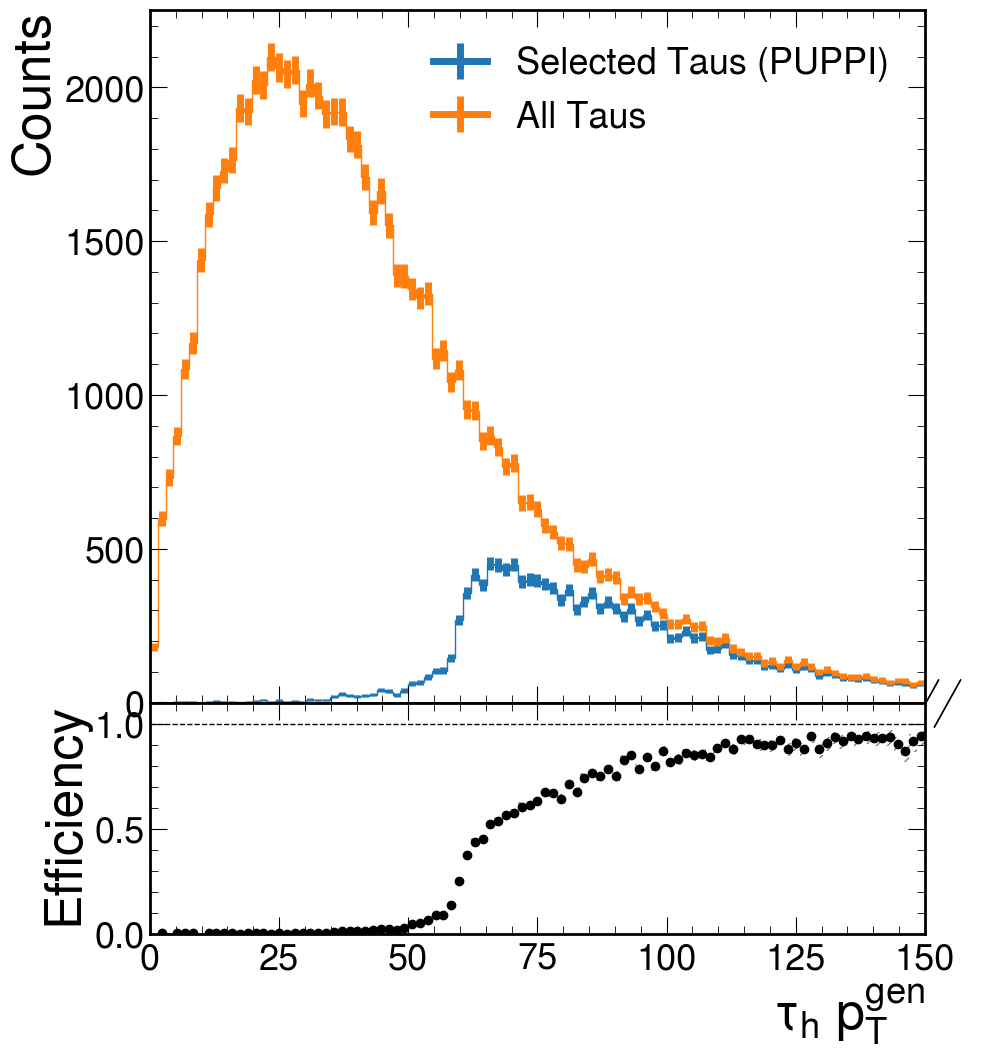

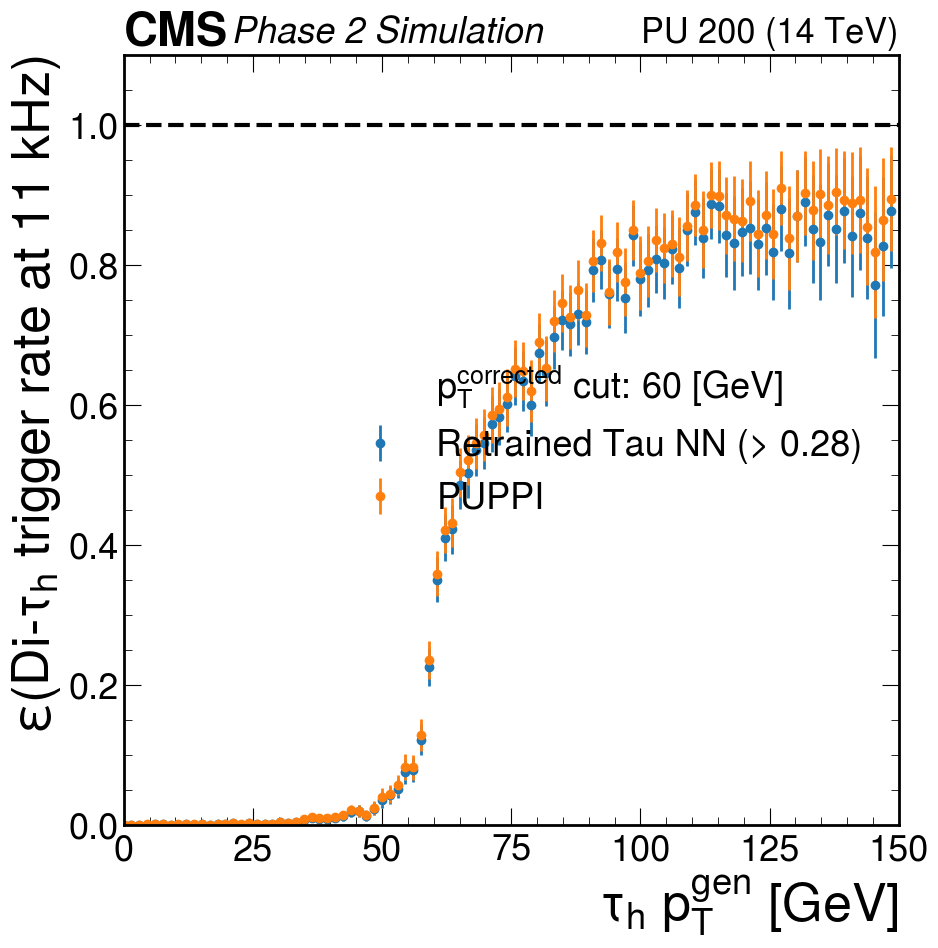

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.69478325e-02 2.50659736e-02 0.00000000e+00 5.00609698e-04
 4.47530891e-03 2.96383171e-04 1.84859034e-03 1.85840687e-04
 6.83853574e-04 2.46792506e-03 2.86296513e-03 1.27621602e-04
 3.08988428e-03 4.93953397e-04 1.41133891e-03 4.87664975e-04
 4.62169005e-03 3.99501291e-03 4.06589107e-03 8.65757897e-03
 1.21434950e-02 1.05296505e-02 1.04766351e-02 1.18464616e-02
 1.49699361e-02 2.18374951e-02 2.31540614e-02 1.45897248e-02
 2.70468088e-02 4.14366802e-02 4.81786357e-02 5.85703240e-02
 8.46506554e-02 8.86666029e-02 1.39700050e-01 2.51969745e-01
 3.93196693e-01 4.59134416e-01 4.78745355e-01 5.49114383e-01
 5.58470229e-01 6.02357527e-01 5.98409666e-01 6.29004128e-01
 6.45053247e-01 6.63962345e-01 6.94171953e-01 7.03034832e-01
 6.74851428e-01 7.39517388e-01 7.19010152e-01 7.54689843e-01
 7.97401407e-01 7.75935274e-01 8.17500355e-01 7.85875856e-01
 8.38996467e-01 8.68894863e-01 8.05369830e-01 8.63791589e-01
 8.09340902e-01 8.779077

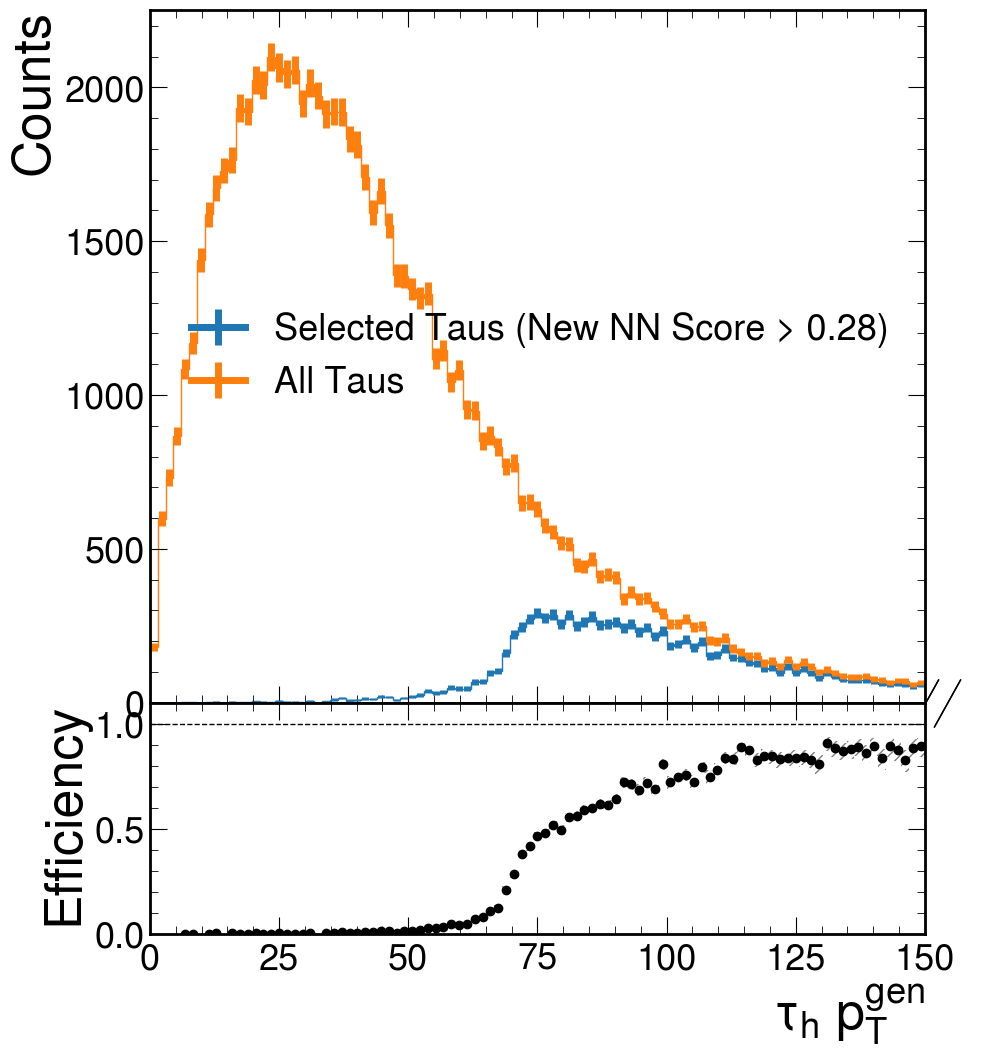

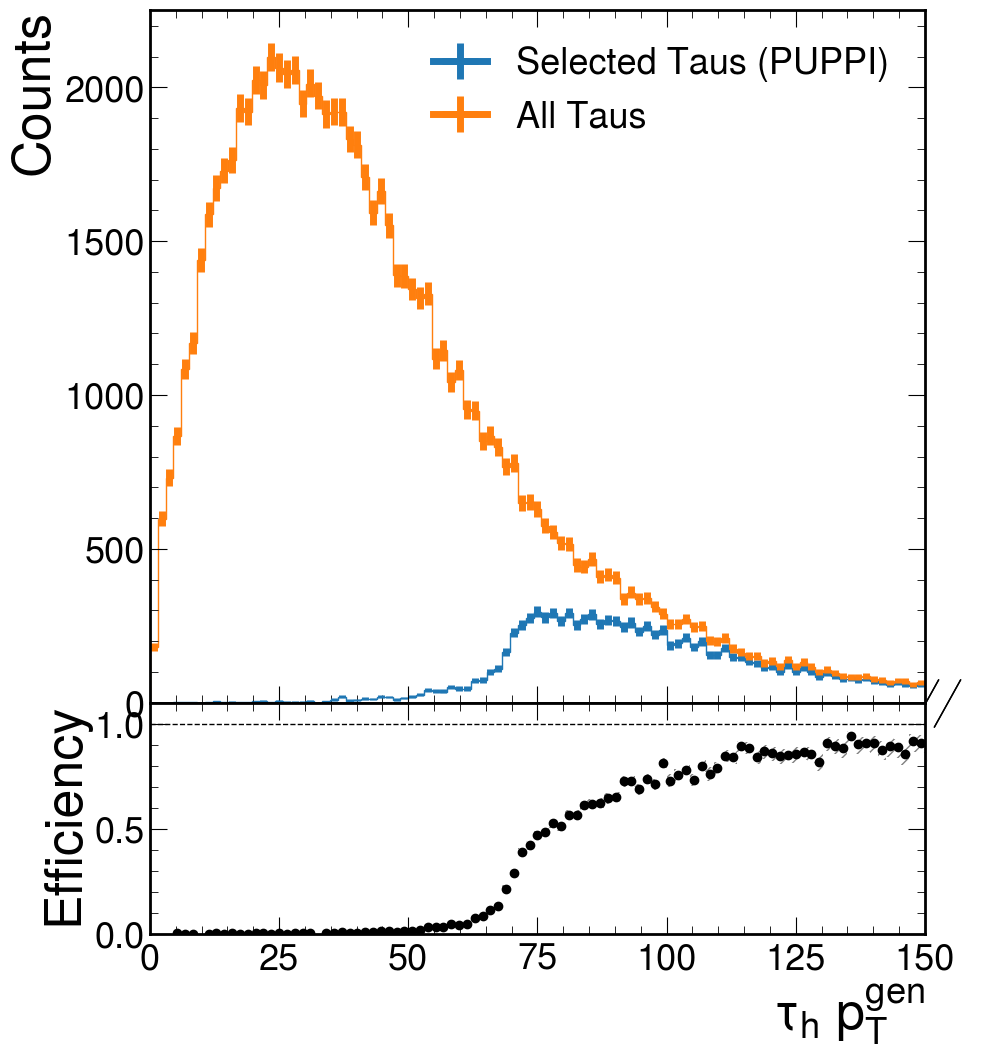

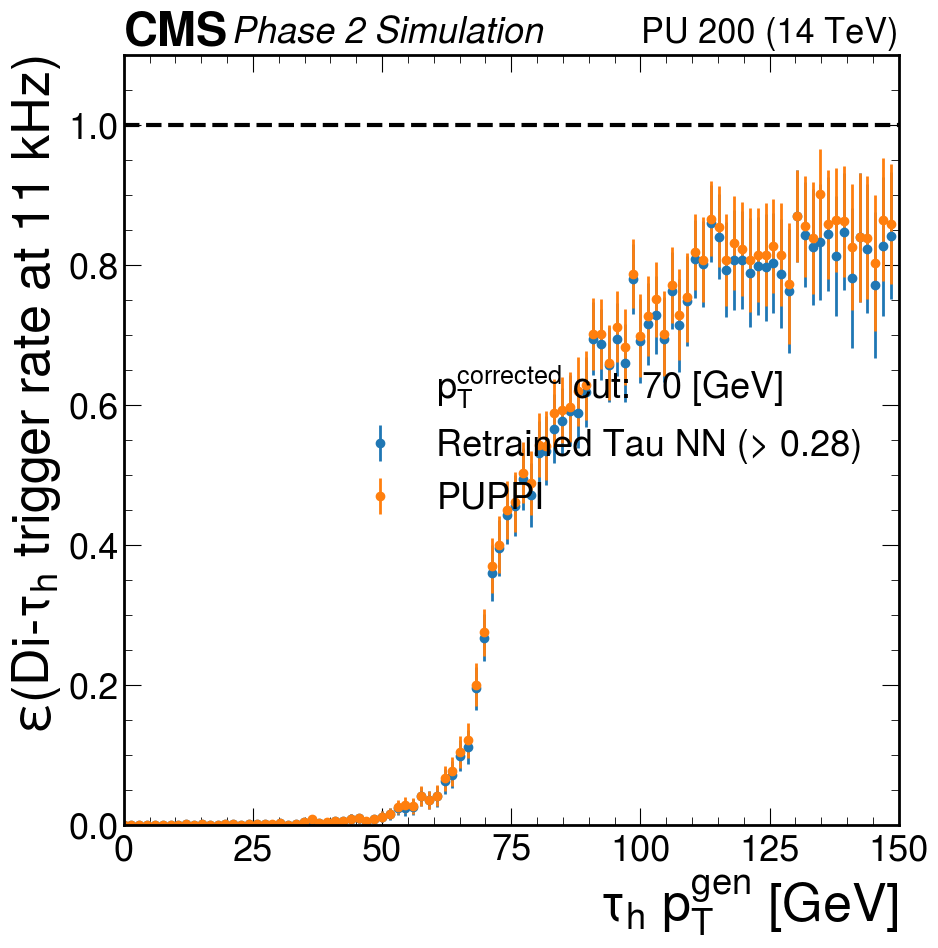

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.01107122e-03 6.11334257e-03 0.00000000e+00 5.00609698e-04
 2.93362799e-03 0.00000000e+00 9.57377801e-04 1.85840687e-04
 1.66798111e-04 1.81210651e-03 5.59923027e-04 1.27621602e-04
 1.98602889e-03 4.93953397e-04 4.79147060e-04 1.18946118e-04
 2.42737710e-03 0.00000000e+00 1.39977371e-03 4.61740776e-03
 7.43544670e-03 2.98748917e-03 3.51959239e-03 6.79546647e-03
 5.77634986e-03 1.06703217e-02 1.06325668e-02 4.39743038e-03
 9.47419595e-03 1.35330665e-02 1.75021506e-02 2.65304924e-02
 2.67269492e-02 2.89280763e-02 4.63815278e-02 3.97127111e-02
 4.52751656e-02 6.96485811e-02 8.12992205e-02 1.11592109e-01
 1.23771958e-01 2.19316081e-01 2.93355494e-01 3.94547265e-01
 4.38085757e-01 4.89404156e-01 4.93394353e-01 5.48019672e-01
 5.29169135e-01 5.82418895e-01 5.95768833e-01 6.13098000e-01
 6.38355718e-01 6.41523770e-01 6.58602179e-01 6.76057882e-01
 7.35284392e-01 7.38673858e-01 6.98314937e-01 7.54502941e-01
 7.09882984e-01 8.135384

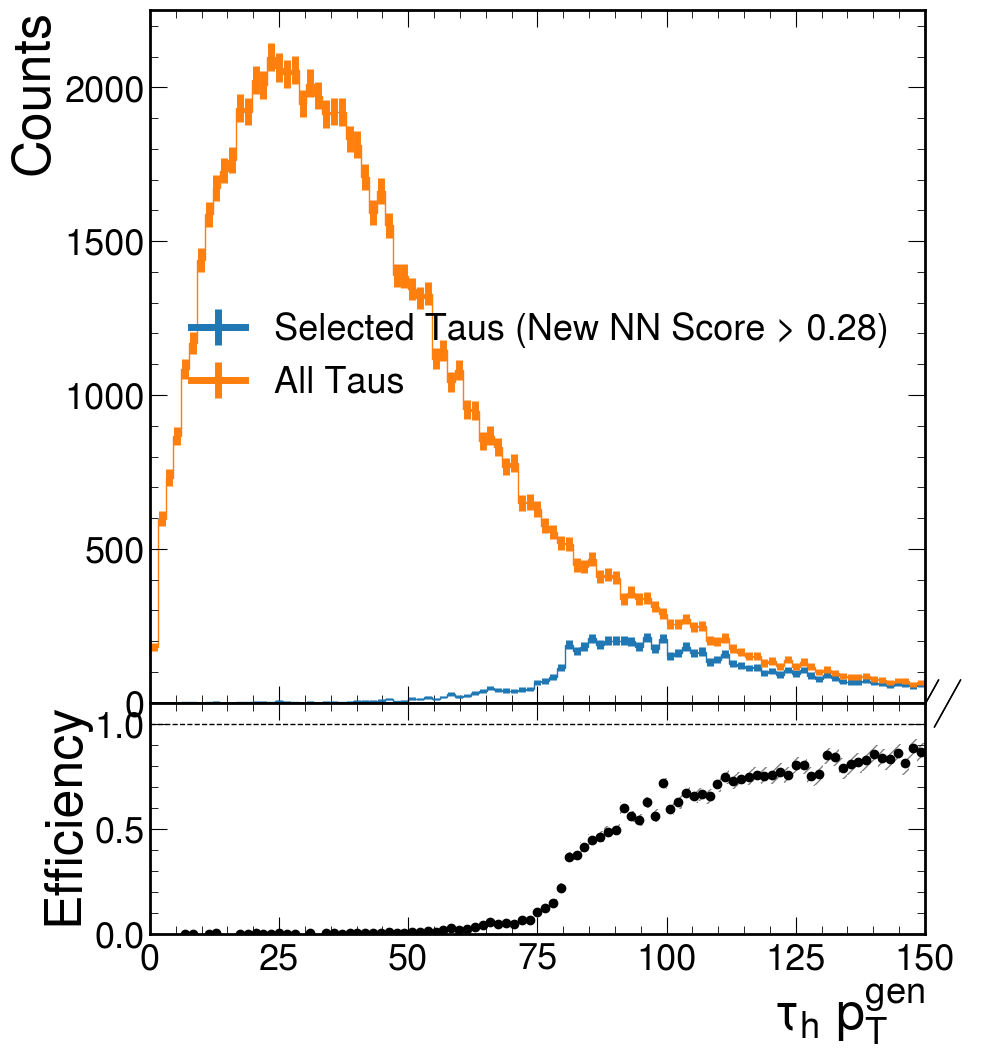

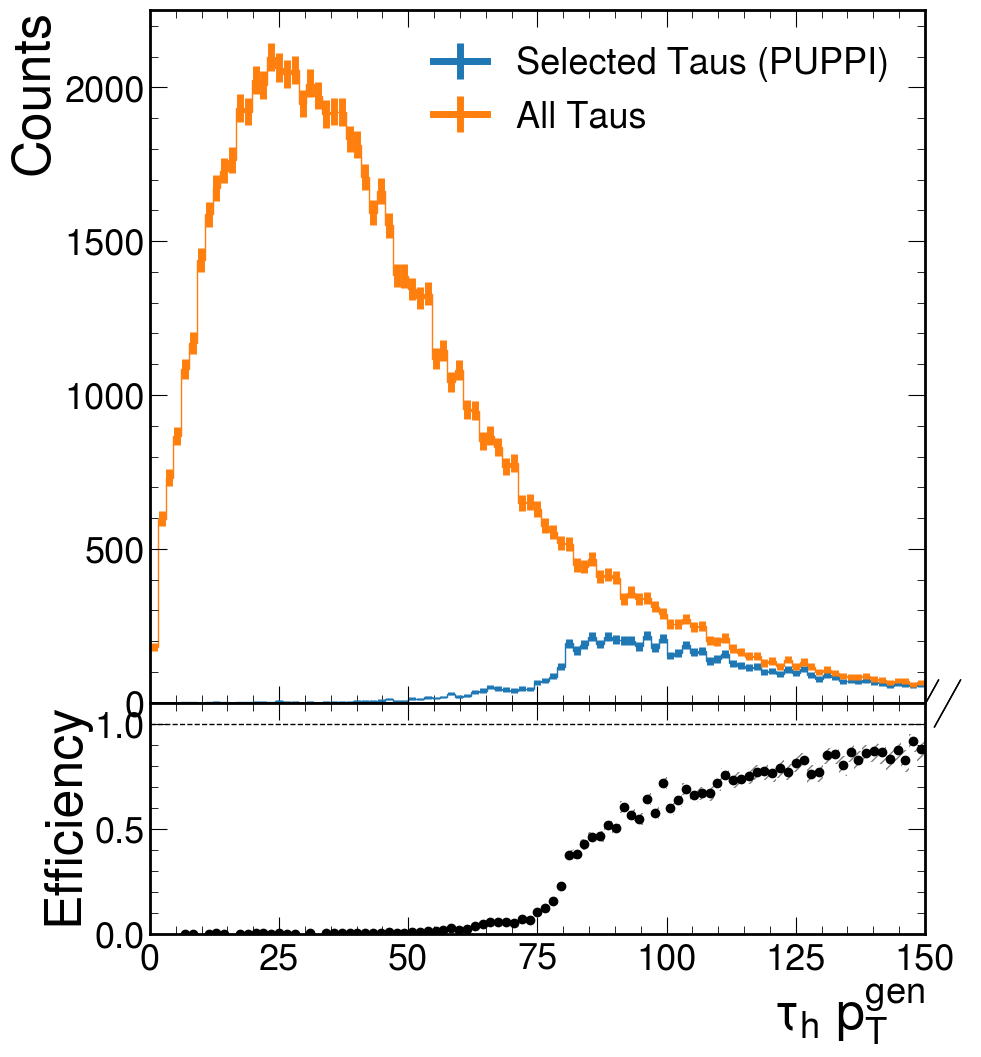

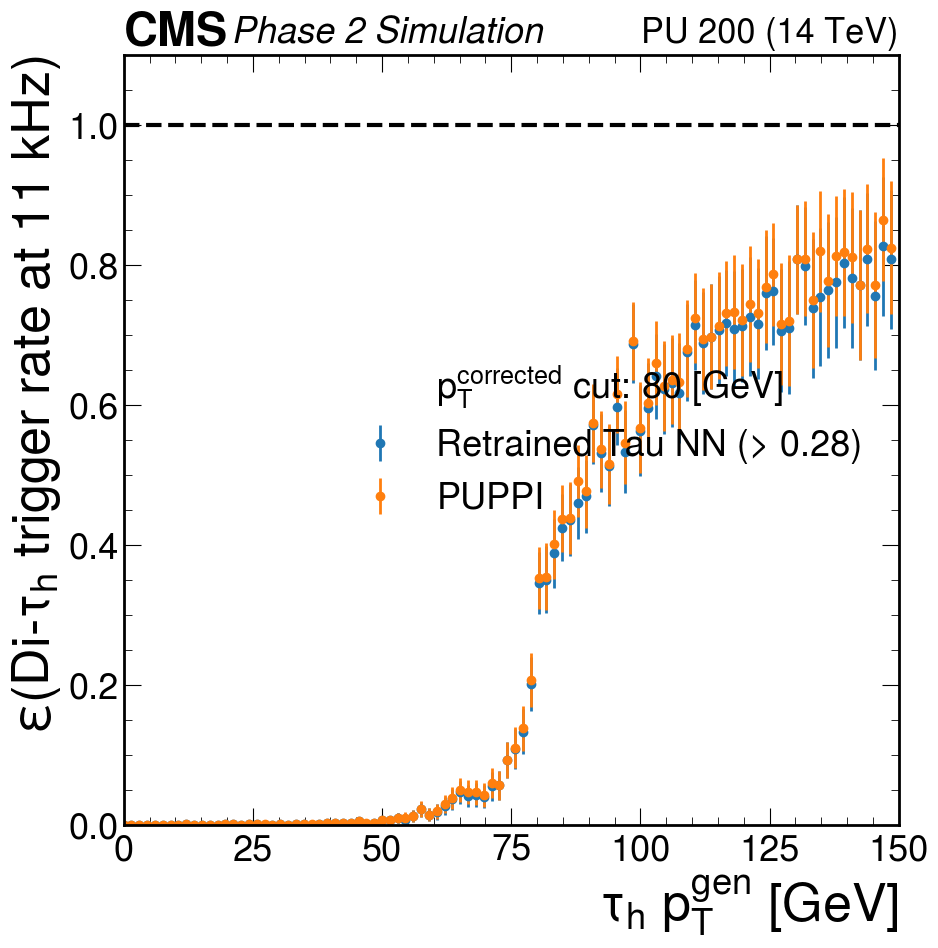

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.01107122e-03 6.11334257e-03 0.00000000e+00 5.00609698e-04
 1.51930652e-03 0.00000000e+00 0.00000000e+00 1.85840687e-04
 1.66798111e-04 1.18787877e-03 5.59923027e-04 1.27621602e-04
 1.98602889e-03 4.93953397e-04 1.16869265e-04 0.00000000e+00
 9.16646781e-04 0.00000000e+00 9.17581132e-04 9.15781289e-04
 1.14899165e-04 4.78654787e-04 2.43515628e-03 2.60466705e-03
 2.12050807e-03 3.21001695e-03 5.95861872e-03 1.75256075e-03
 3.06869443e-03 8.20582927e-03 7.49547493e-03 1.10667176e-02
 7.82987802e-03 1.36995395e-02 2.50770658e-02 1.61154692e-02
 2.04730757e-02 3.00989224e-02 4.13802047e-02 5.24750636e-02
 4.52716160e-02 4.82476683e-02 4.37556686e-02 6.03766498e-02
 6.21882500e-02 1.02500500e-01 1.17070186e-01 1.47184715e-01
 2.26230821e-01 3.78889478e-01 3.89983417e-01 4.19858254e-01
 4.69753116e-01 4.72019558e-01 5.15477043e-01 5.13552566e-01
 6.04496029e-01 5.71339263e-01 5.45046649e-01 6.50032647e-01
 5.73394468e-01 7.166841

In [6]:
results = plot_pt_eff_puppi_no_nn('../../models/Feb_4_2023_JetMetTalk_v1_pTShape_EMSeed.h5',
                            '../models/pt_regress_v1.h5',
                            '../../ntuples/Jan_25_2023/test_sig_v12_emseed.root',
                            corrected_pt_cut=0,
                            cut_point = 0.28)
no_cut_x = np.asarray(results[0])
no_cut_y = np.asarray(results[1])


threshold_list = [15, 20, 25,30,35,40,50,60,70,80]
gen_pT_list = []
for i in threshold_list:
    result = plot_pt_eff_puppi_no_nn('../../models/Feb_4_2023_JetMetTalk_v1_pTShape_EMSeed.h5',
                            '../models/pt_regress_v1.h5',
                            '../../ntuples/Jan_25_2023/test_sig_v12_emseed.root',
                            corrected_pt_cut=i,
                            cut_point = 0.28)
    cut_x = np.asarray(result[0])
    cut_y = np.asarray(result[1])
    y_norm = np.divide(cut_y, no_cut_y)
    print(y_norm)
    for i in range(10):
        if y_norm[i] == 1:
            y_norm[i] = 0
        else:
            break
    gen_pT_list.append(cut_x[y_norm > 0.95][0])
#gen_pT_list = [cut(i) for i in threshold_list]
gen_pT_list_no_nn = gen_pT_list


In [7]:
print(gen_pT_list_no_nn)
print(gen_pT_list_nn)

[33.333333333333336, 48.484848484848484, 56.06060606060606, 65.15151515151516, 77.27272727272728, 84.84848484848484, 103.03030303030303, 115.15151515151516, 134.84848484848487, 146.96969696969697]
[21.21212121212121, 28.78787878787879, 36.36363636363636, 45.45454545454545, 54.54545454545455, 65.15151515151516, 77.27272727272728, 84.84848484848484, 103.03030303030303, 115.15151515151516]


In [8]:
def plot_95th(gen_pT_no_nn, gen_pT_nn, threshold_list):
    a, b = np.polyfit(threshold_list, gen_pT_nn, 1)
    c, d = np.polyfit(threshold_list, gen_pT_no_nn, 1)
    fig = plt.figure()
    plt.plot(threshold_list, [a*i + b for i in threshold_list], "--", linewidth = 1)
    plt.plot(threshold_list, gen_pT_nn, "o-", fillstyle='none', linewidth = 1, label = "Merged NN Corrected pT (y = " + str(round(a, 2)) + "x" + " + " + str(round(b, 2)) + ")", color = 'C0')
    plt.plot(threshold_list, [c*i + d for i in threshold_list], "--", linewidth = 1, color = 'r')
    plt.plot(threshold_list, gen_pT_no_nn, "o-", fillstyle='none', linewidth = 1, label = "PUPPI Reco pT (y = " + str(round(c, 2)) + "x" + " + " + str(round(d, 2)) + ")", color = 'r')
    #plt.xlim([20,85])
    #plt.xlim([20,85])
    hep.cms.text("Phase 2 Simulation")
    hep.cms.lumitext("PU 200 (14 TeV)")
    plt.xlabel(r"$p_T$ Cut Threshold [GeV]", fontsize = 25)
    plt.ylabel(r"$95\%$ Efficiency Point [GeV]", fontsize = 25)
    plt.legend(loc = 'upper left', fontsize = 18.5)
    #plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.show()

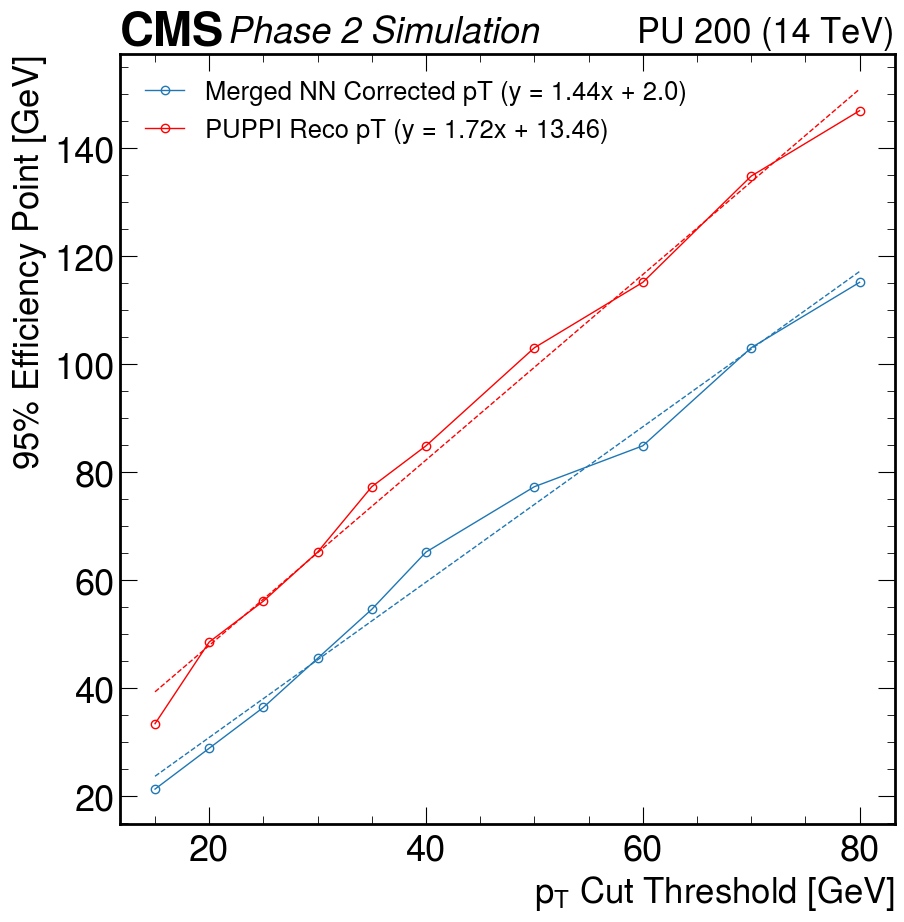

In [9]:

plot_95th(gen_pT_list_no_nn, gen_pT_list_nn, threshold_list)

# maybe make points 